In [108]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import json
from textblob import TextBlob

In [5]:
def get_sp500_stocks():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table', {'id': 'constituents'})
    stocks = []
    for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        ticker = cells[0].text.strip()
        name = cells[1].text.strip()
        stocks.append({'ticker': ticker, 'name': name})
    
    return stocks

<!DOCTYPE html>
<html data-layout-uri="cms.cnn.com/_layouts/layout-no-rail/instances/markets-quotes@published" data-uri="cms.cnn.com/_pages/quotes@published" lang="en">
 <head>
  <style>
   body,h1,h2,h3,h4,h5{font-family:cnn_sans_display,helveticaneue,Helvetica,Arial,Utkal,sans-serif}:root{--web-large-actions-bold-action-1-700-font-family:cnn_sans_display;--web-large-actions-bold-action-1-700-font-size:16px;--web-large-actions-bold-action-1-700-font-style:Bold;--web-large-actions-bold-action-1-700-line-height:24px;--web-large-actions-bold-action-1-700-letter-spacing:0px;--web-large-actions-bold-action-1-700-text-decoration:NONE;--web-large-actions-bold-action-1-700-font-weight:700;--component-button-primary-color:#ffffffff;--web-large-type-body-2-400-font-family:cnn_sans_display;--web-large-type-body-2-400-font-size:16px;--web-large-type-body-2-400-font-style:Regular;--web-large-type-body-2-400-line-height:28px;--web-large-type-body-2-400-letter-spacing:0px;--web-large-type-body-2-400
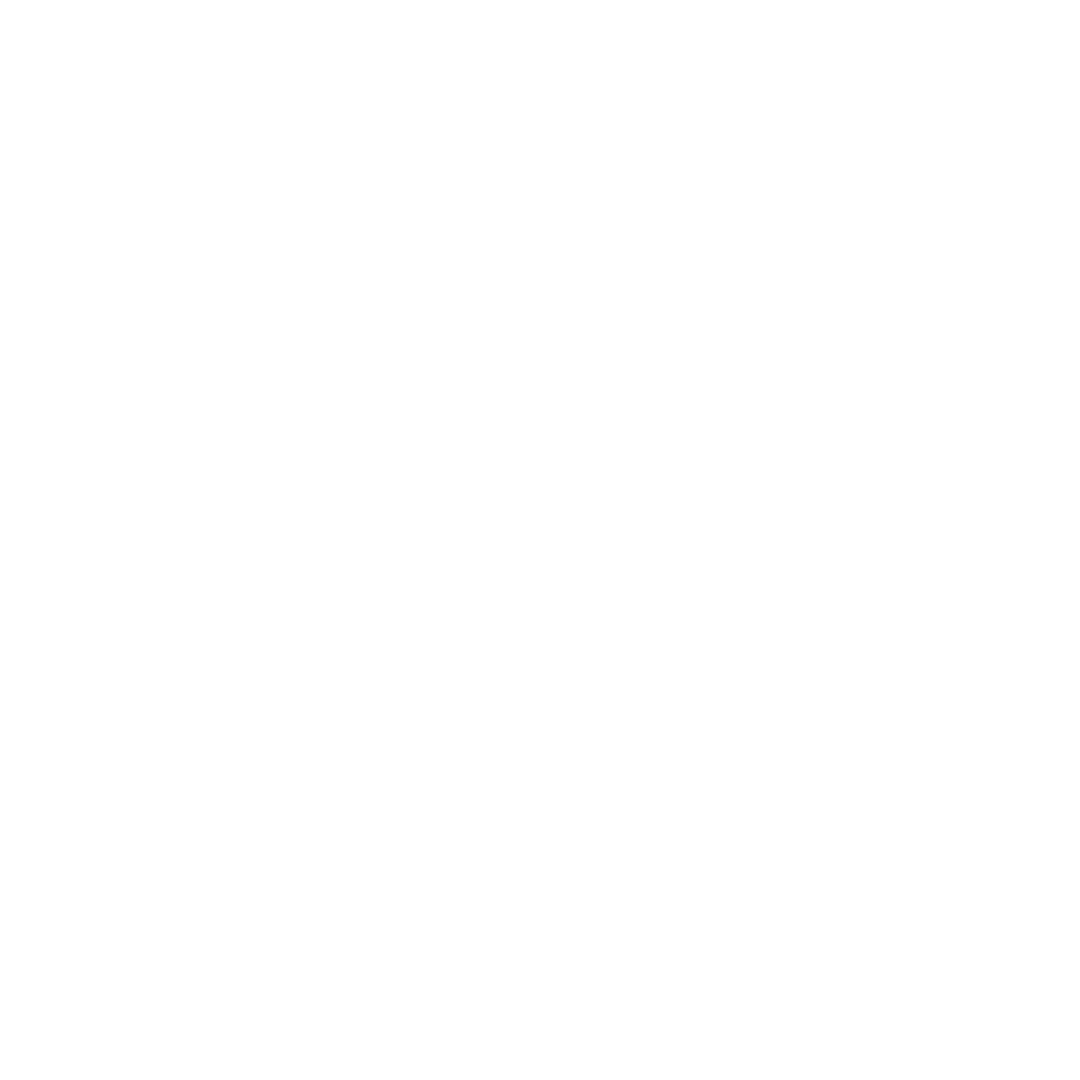
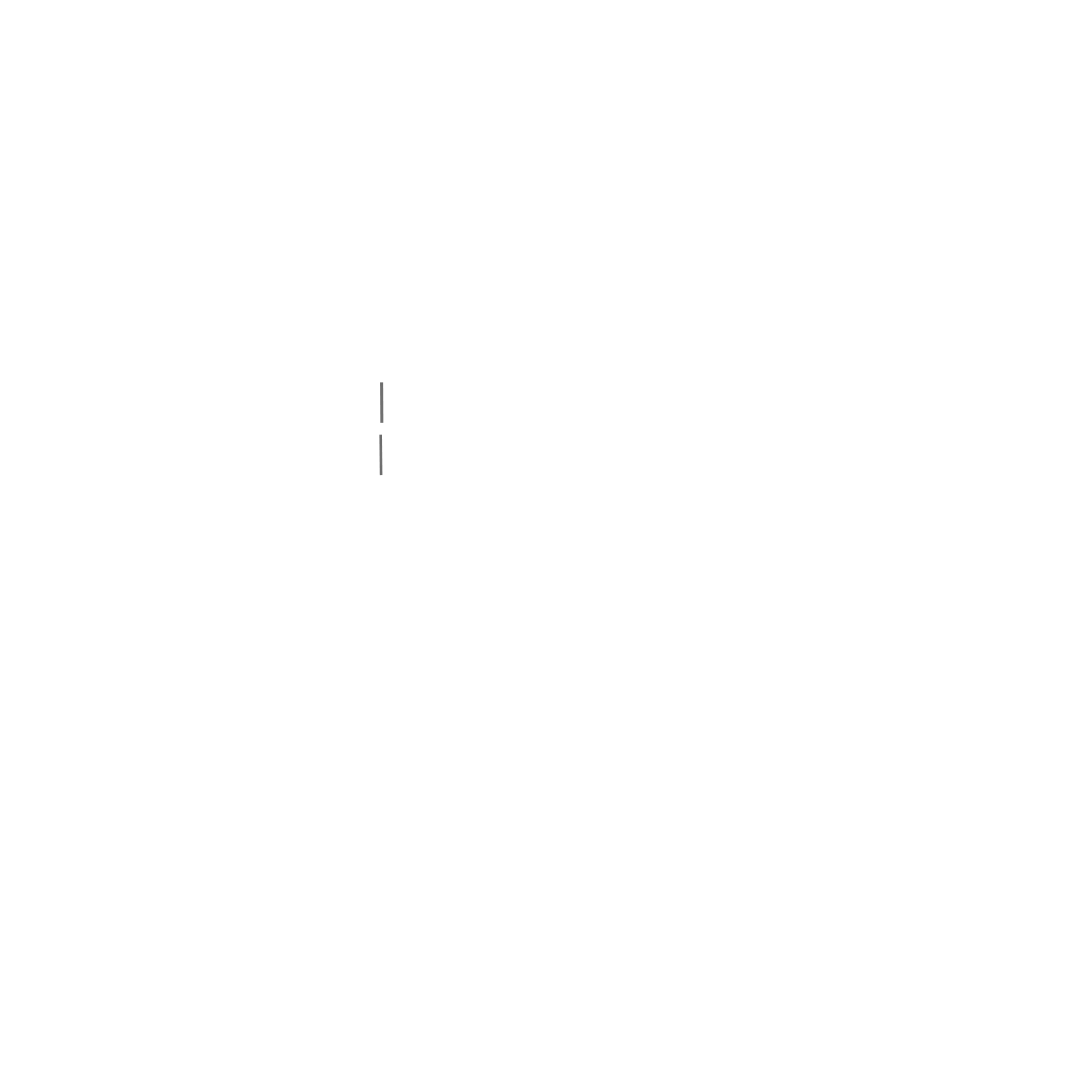
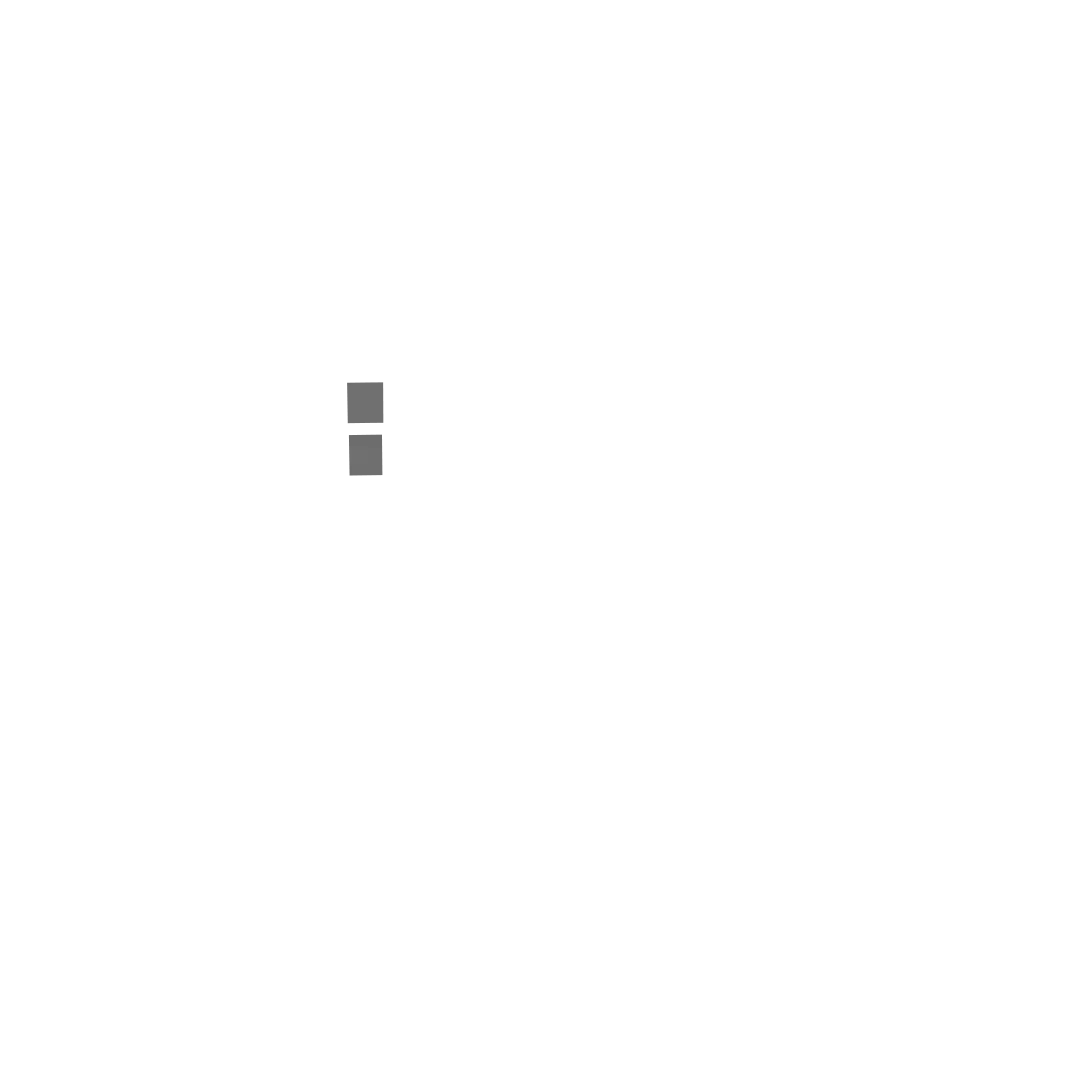
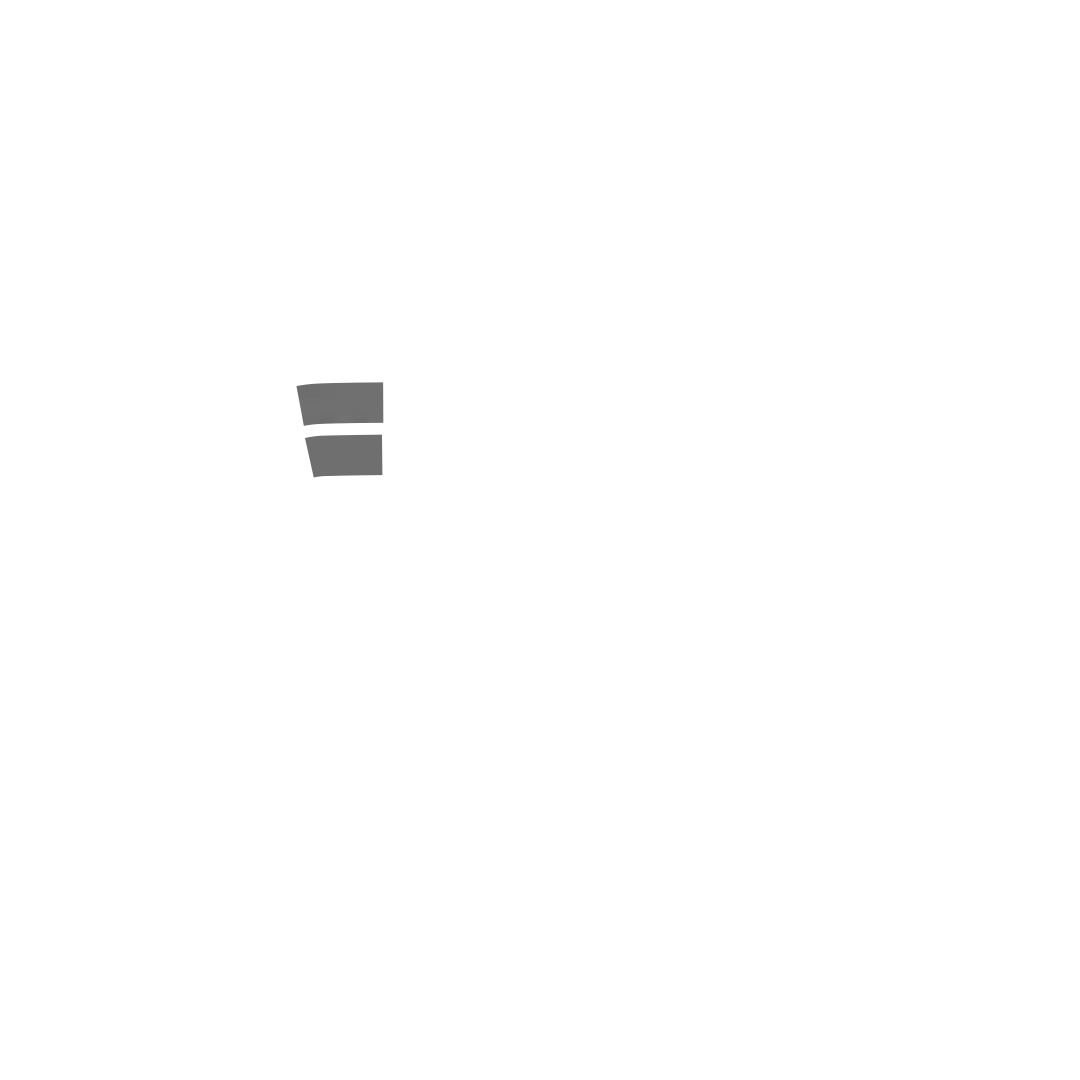
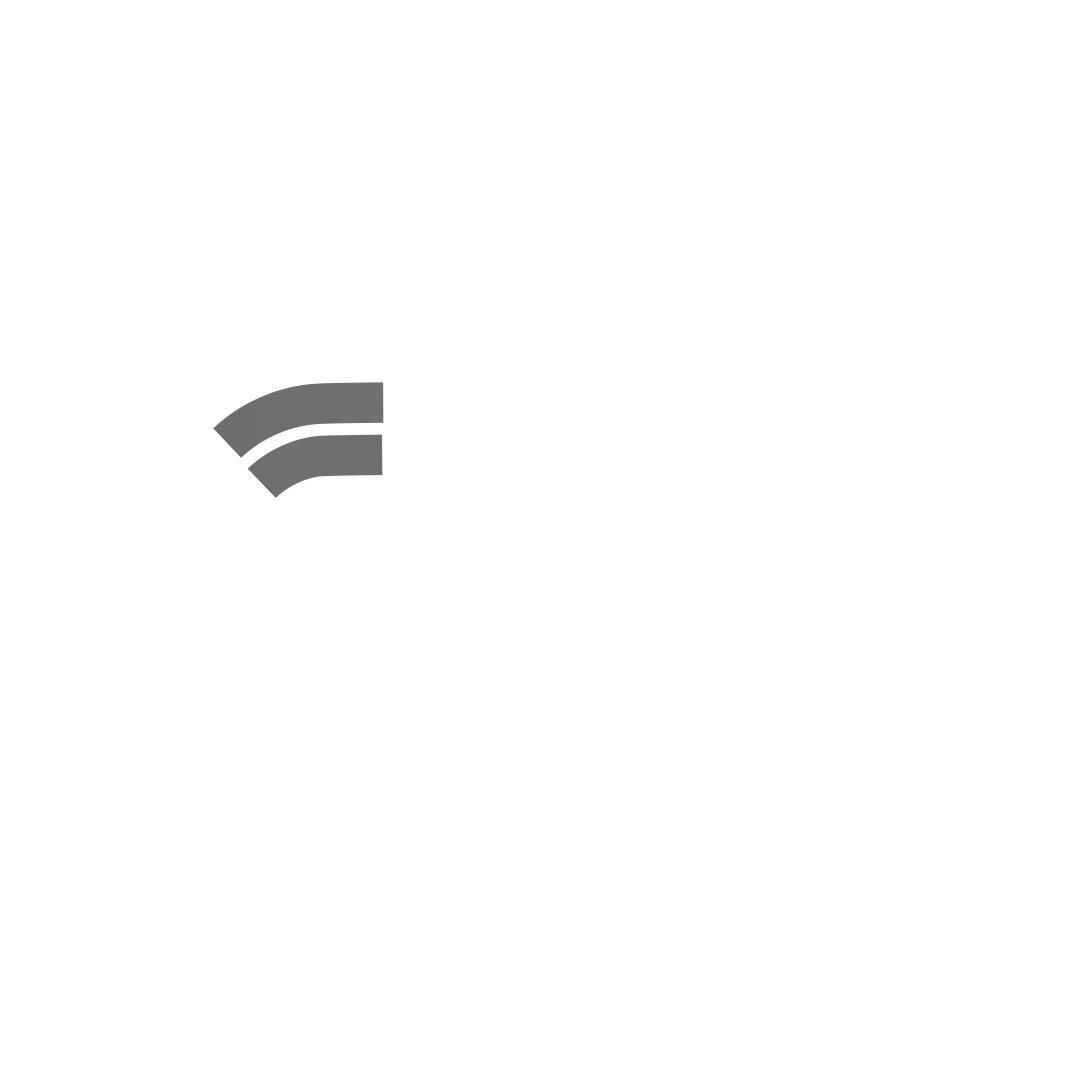
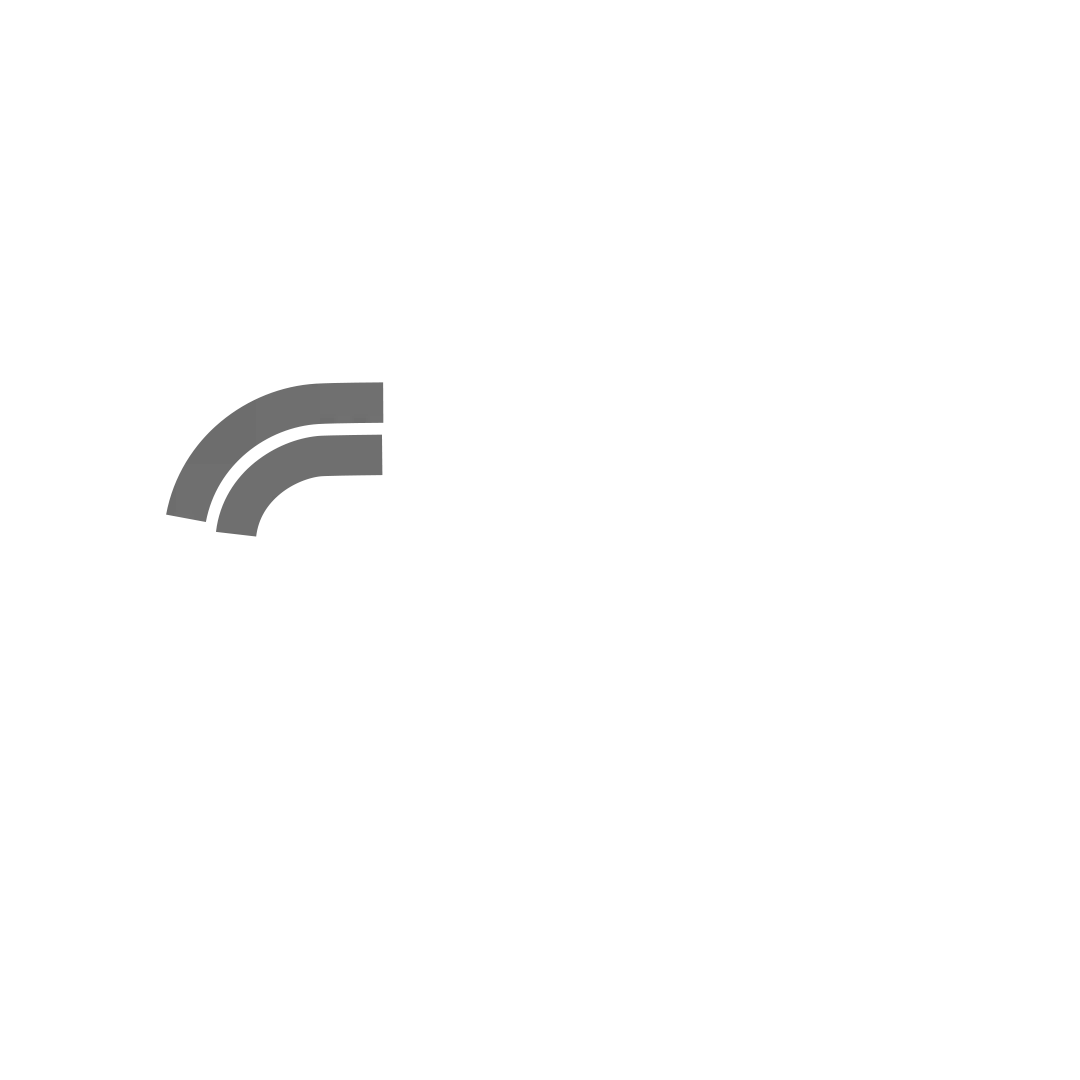
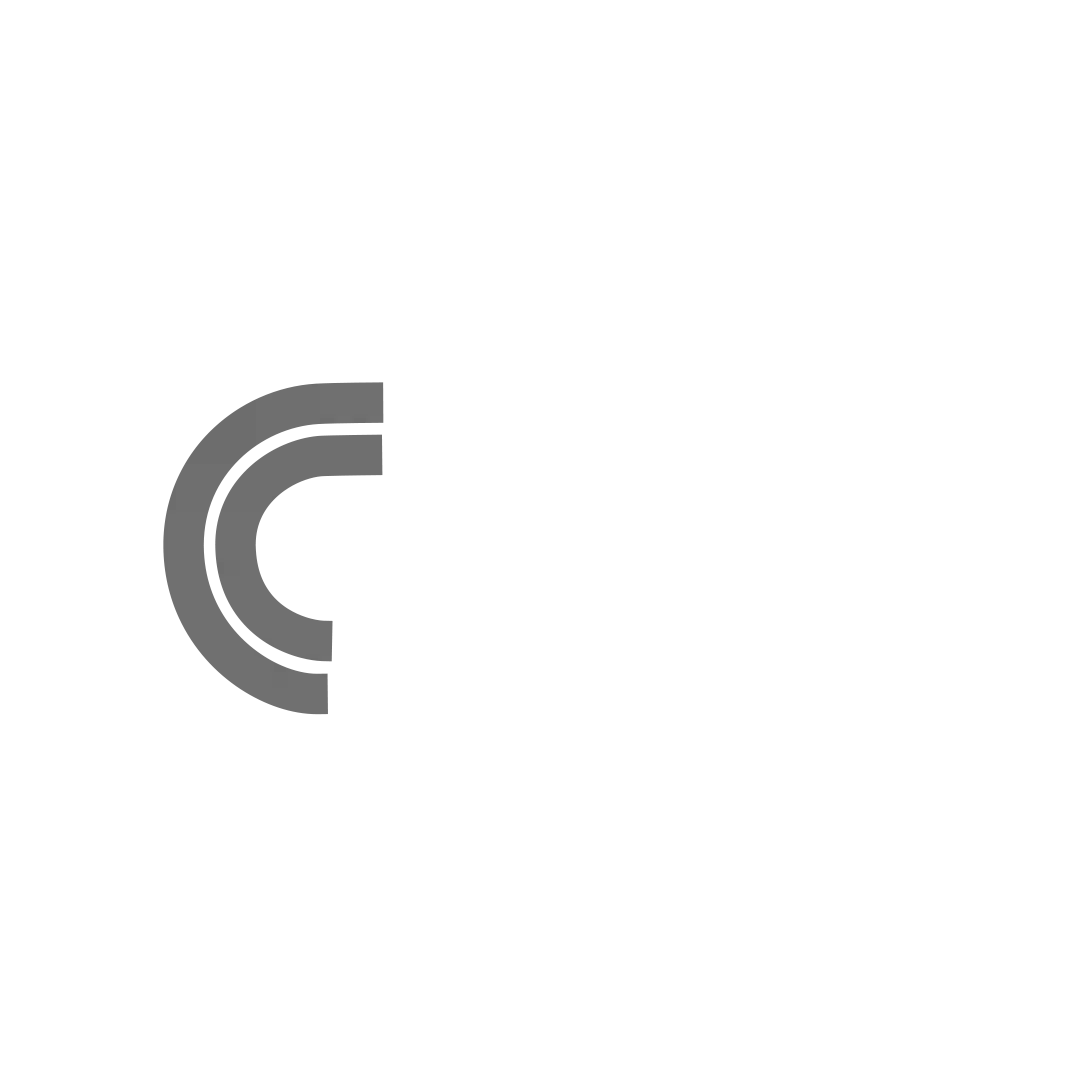
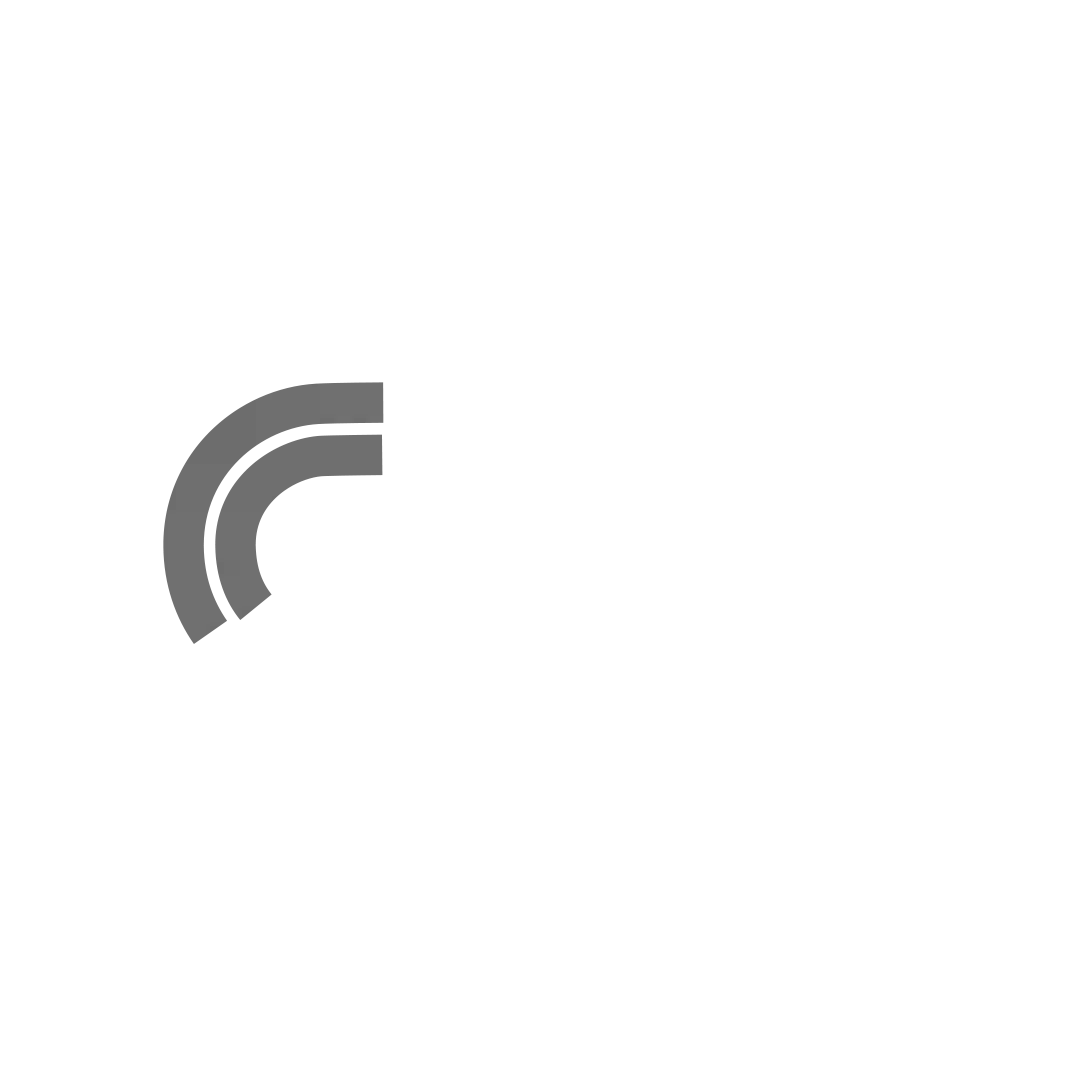
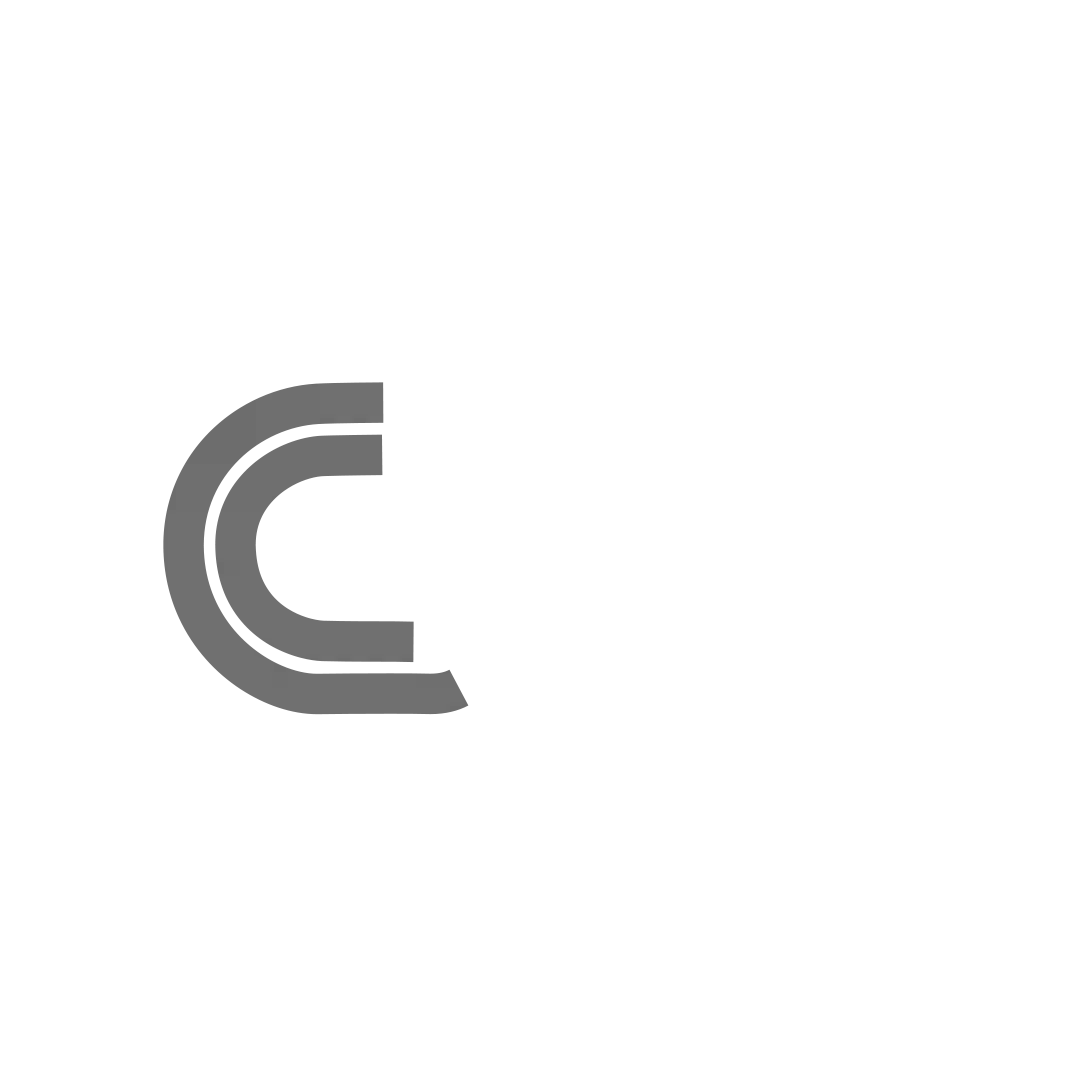
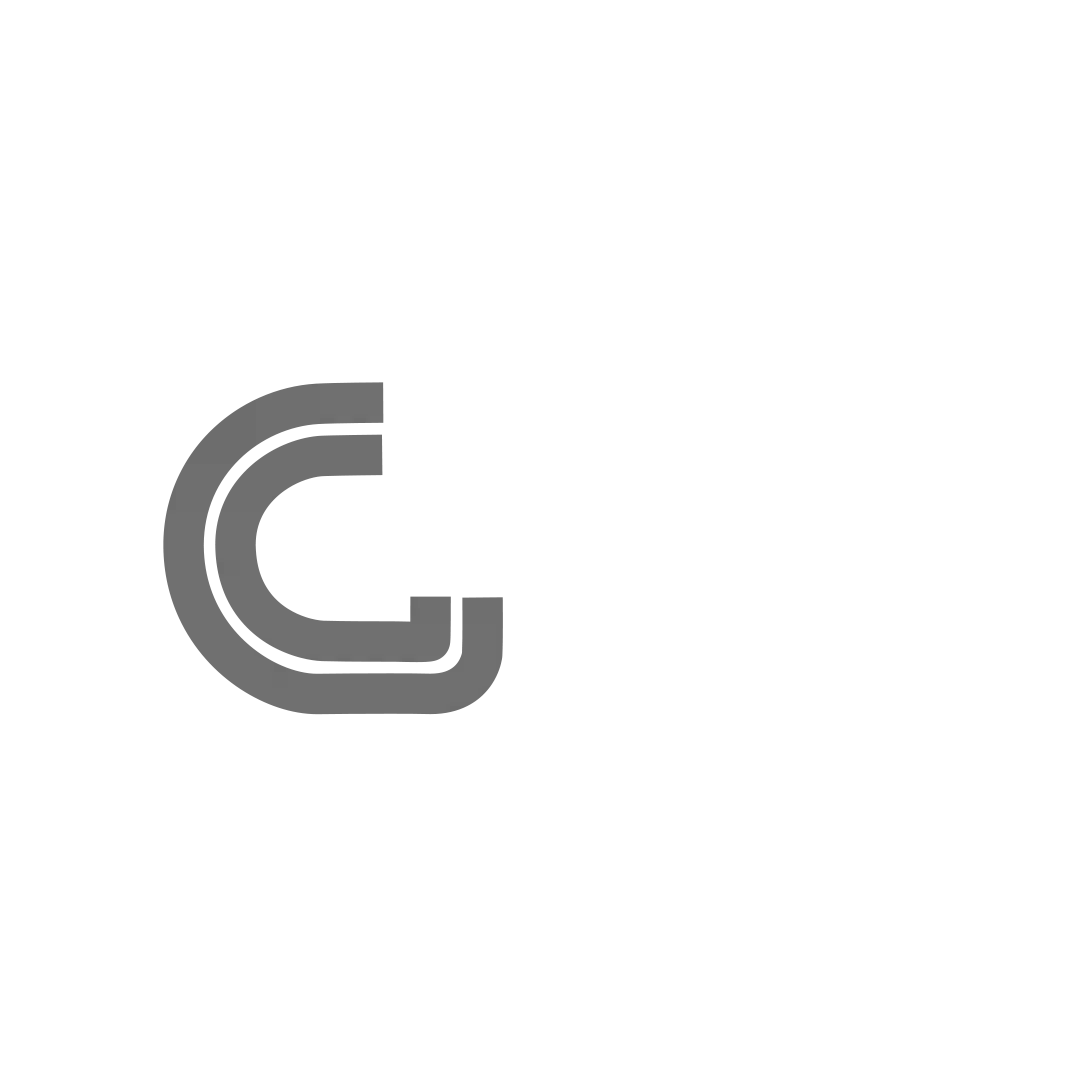
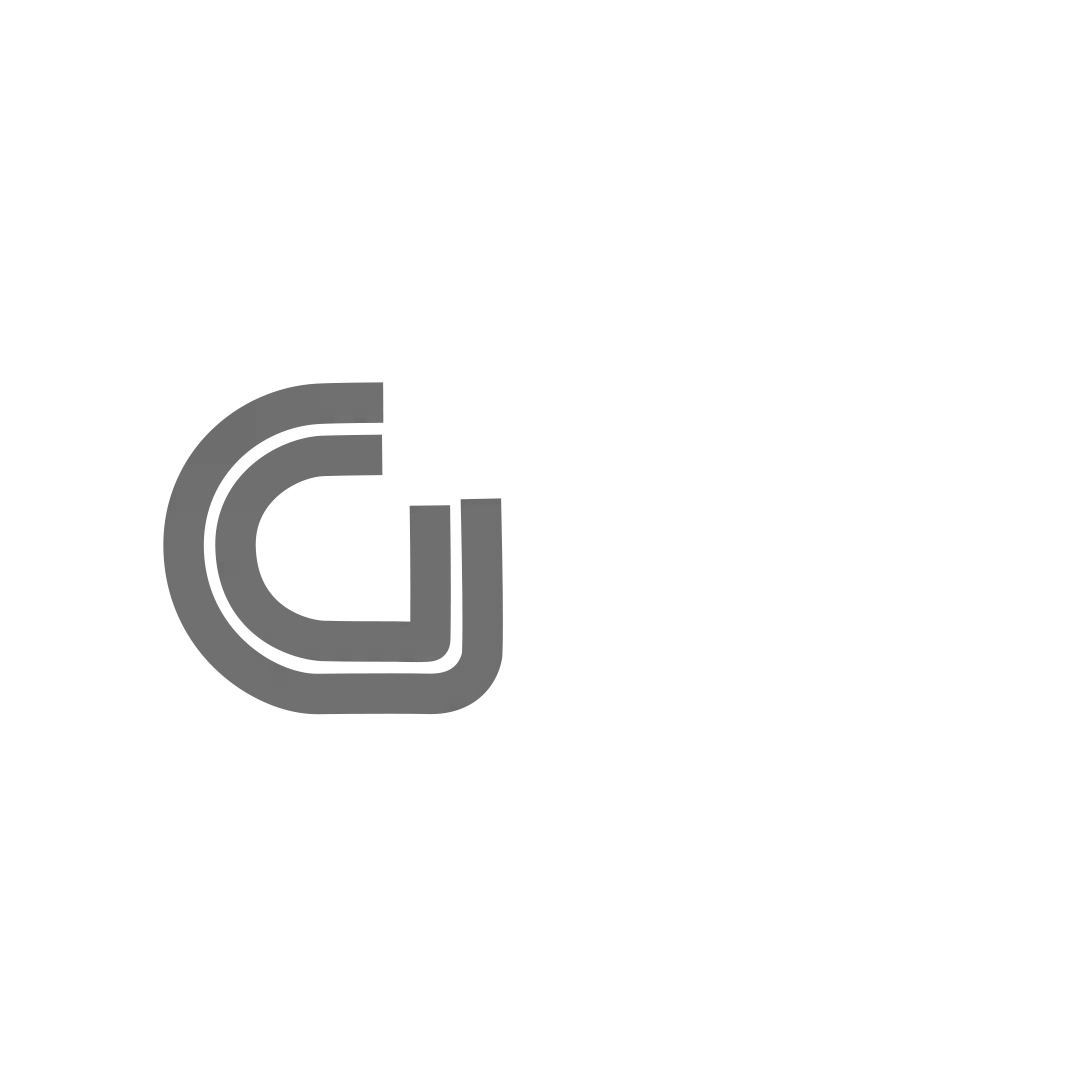
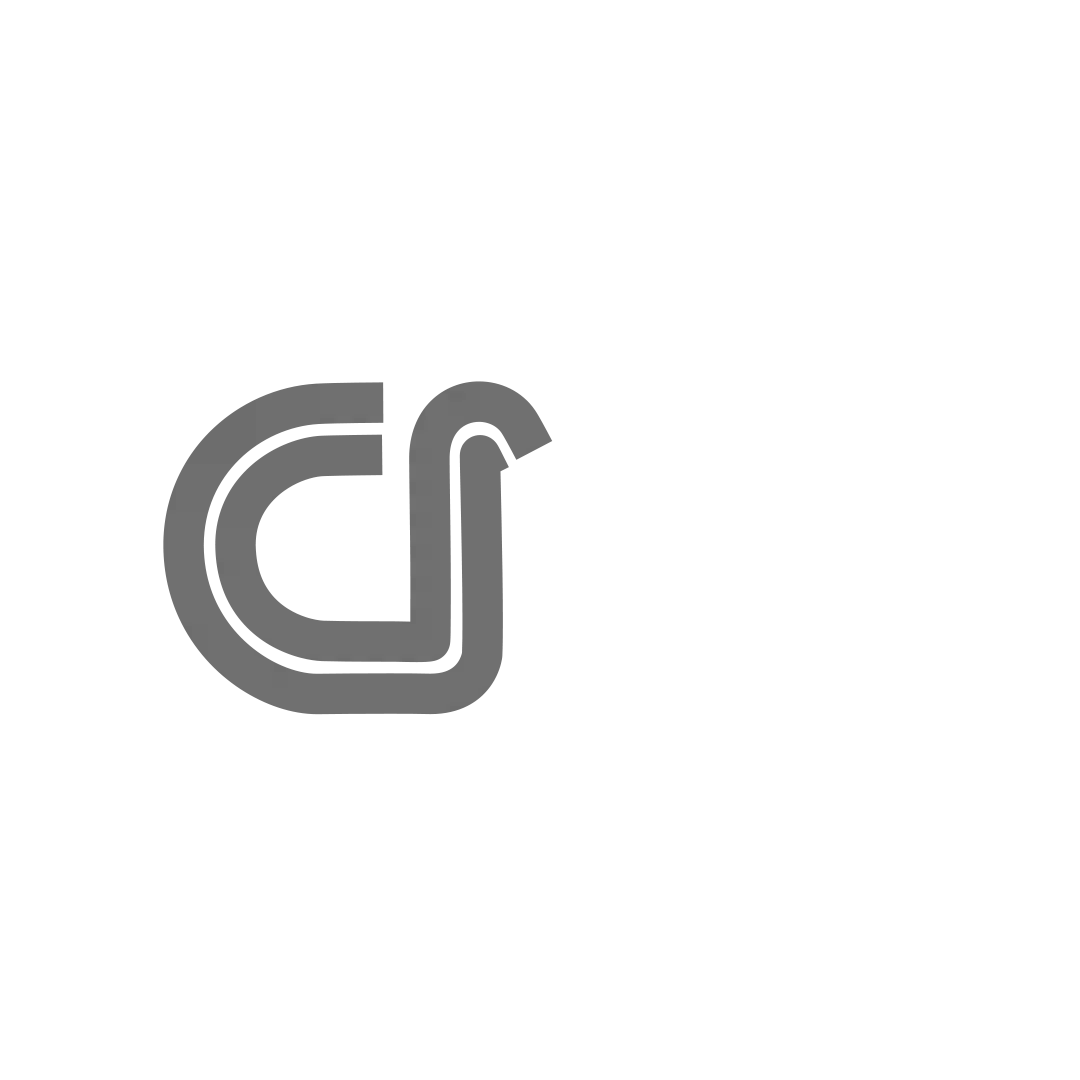
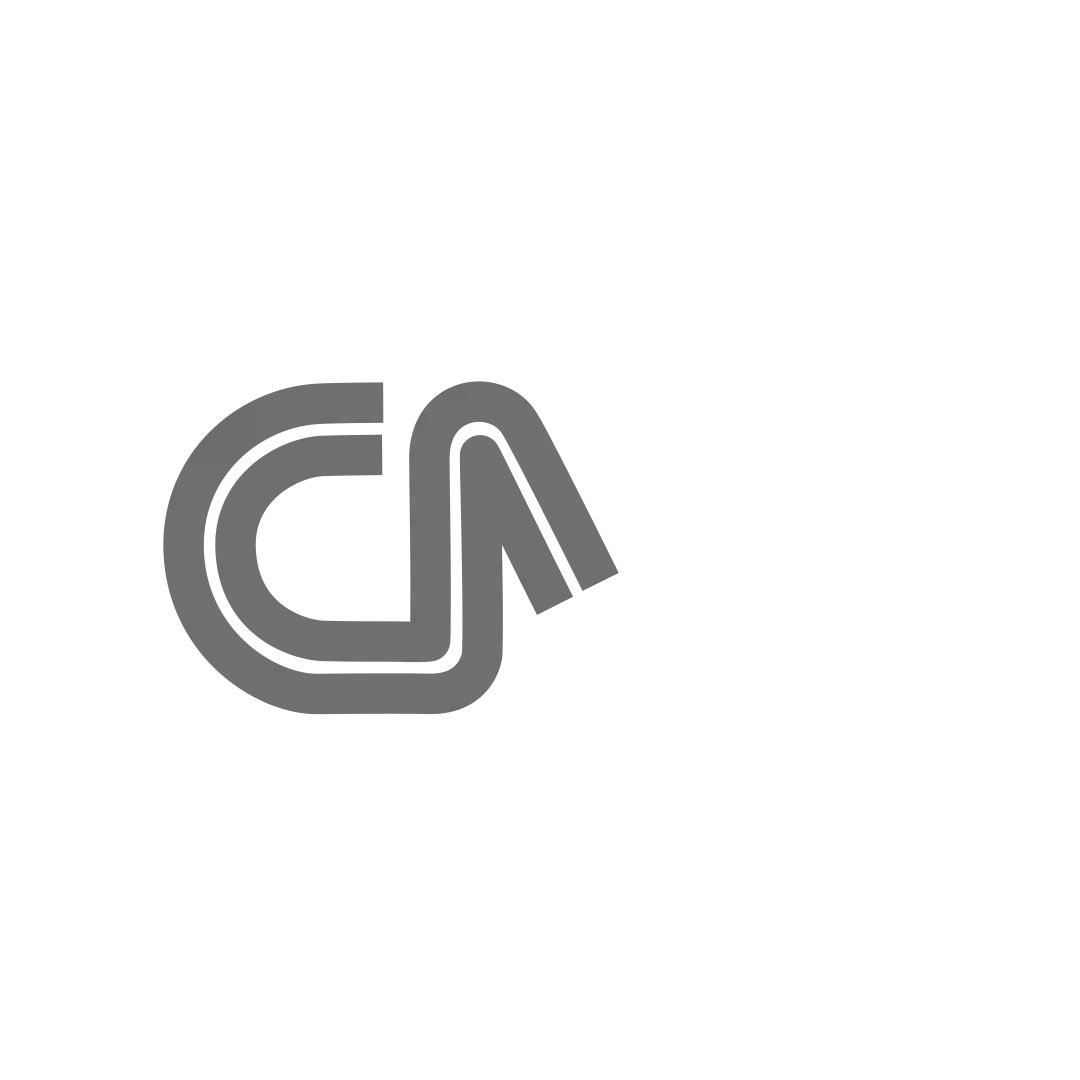
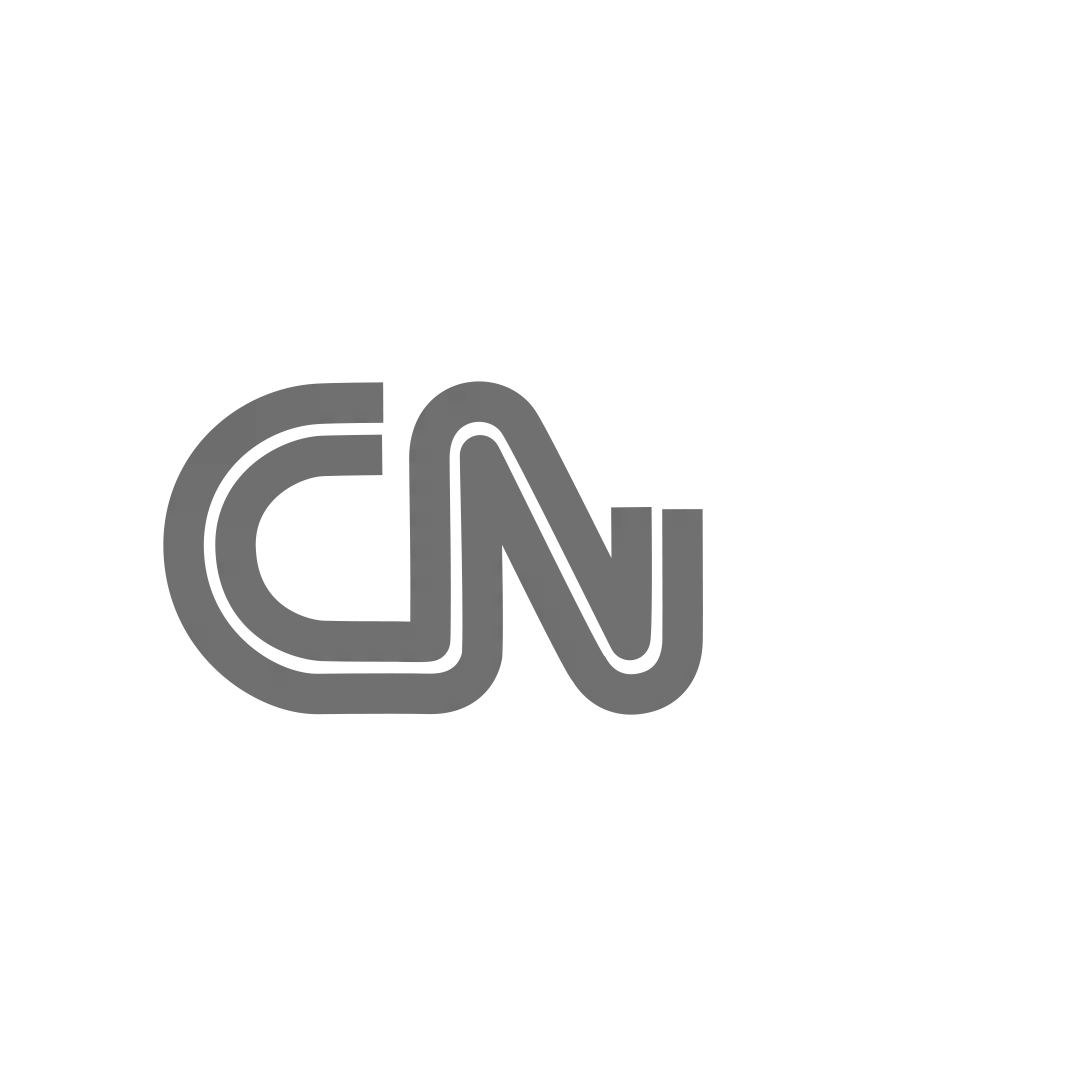
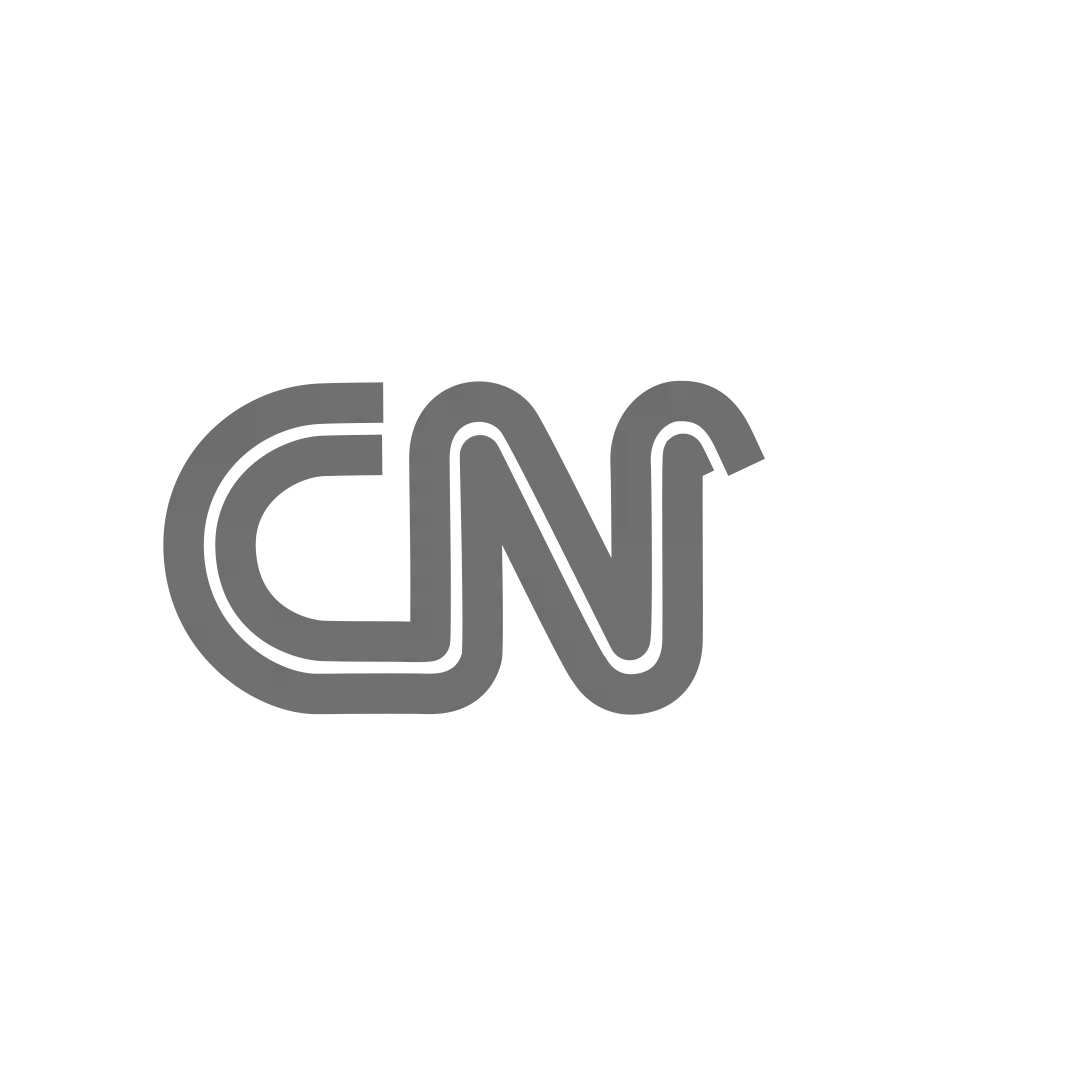
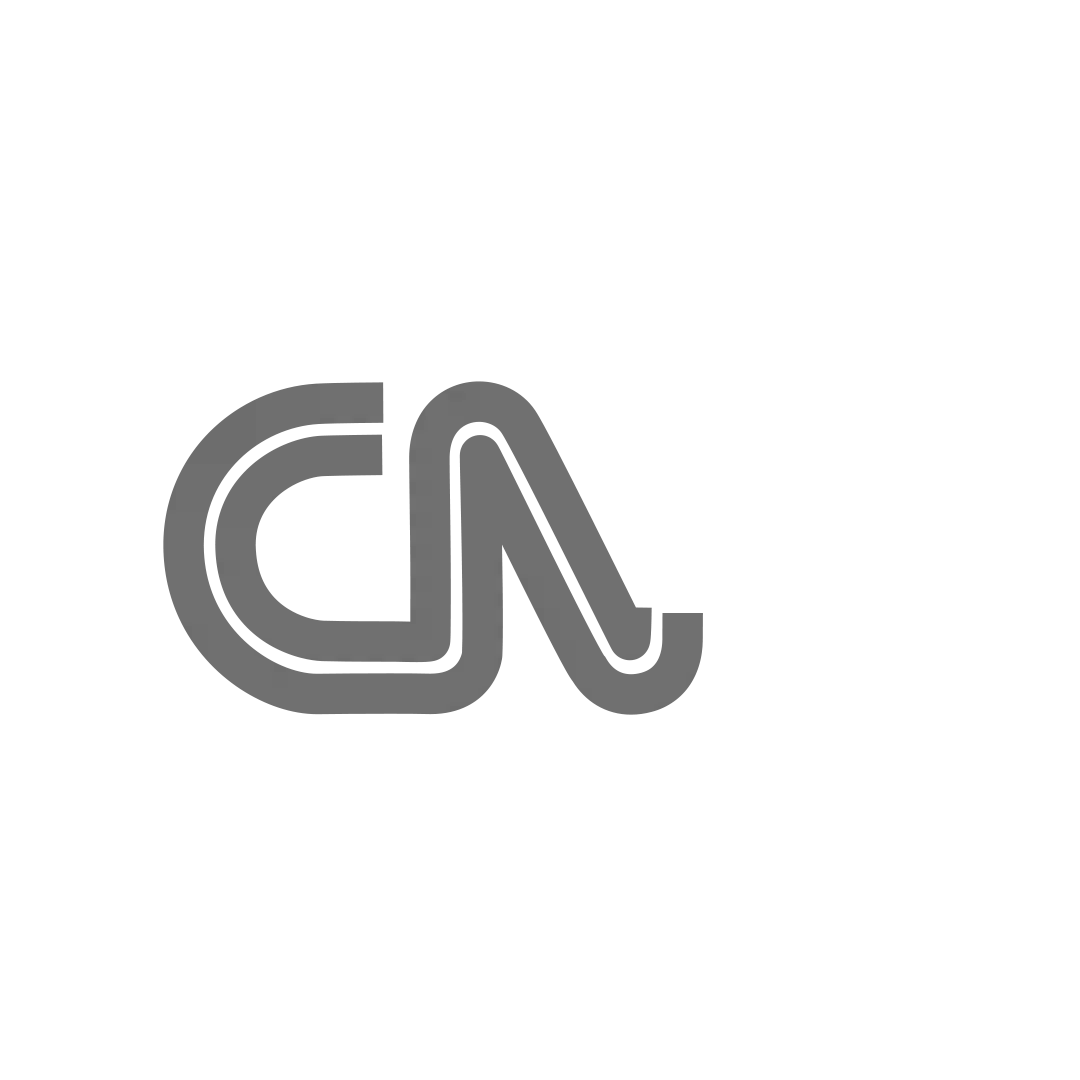
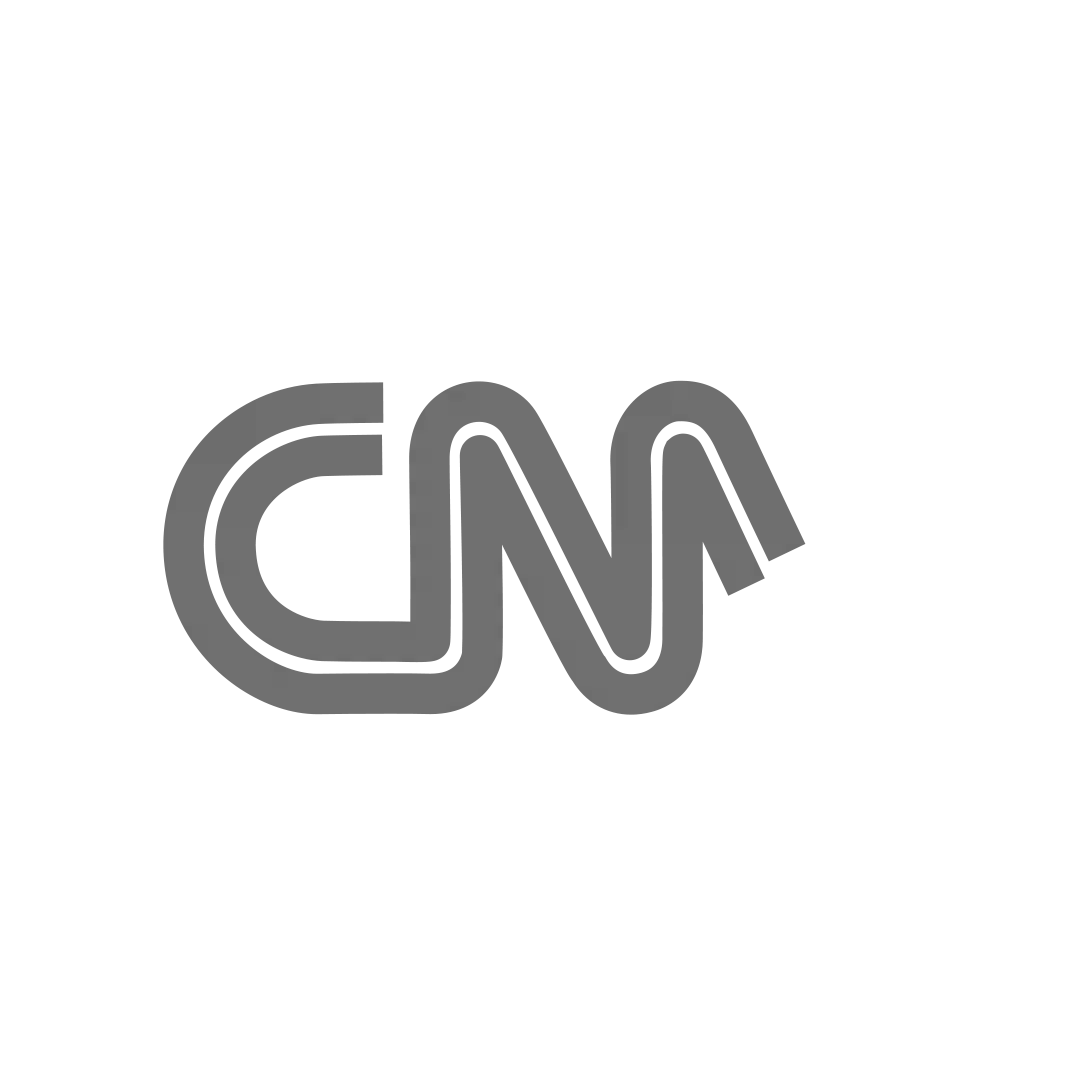
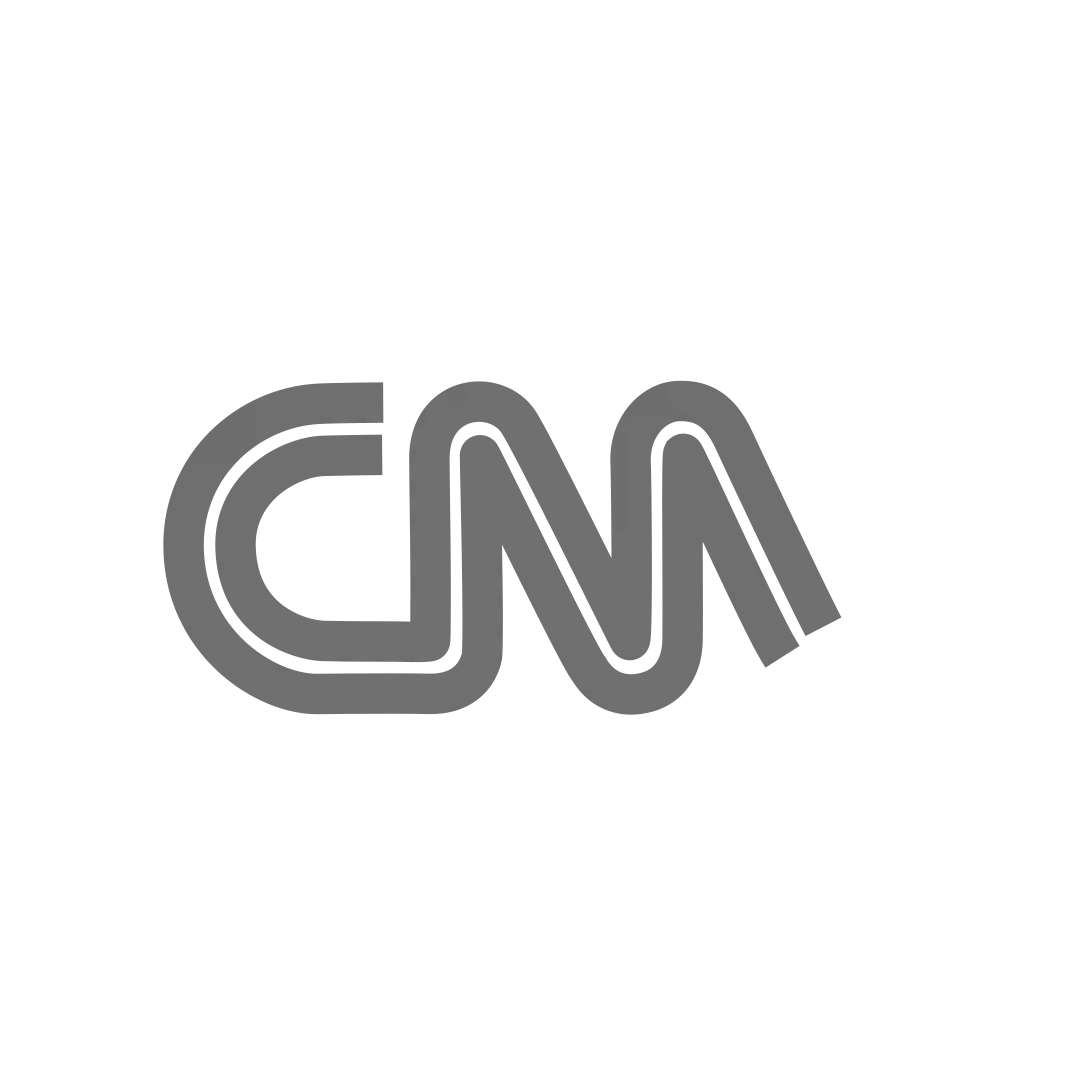
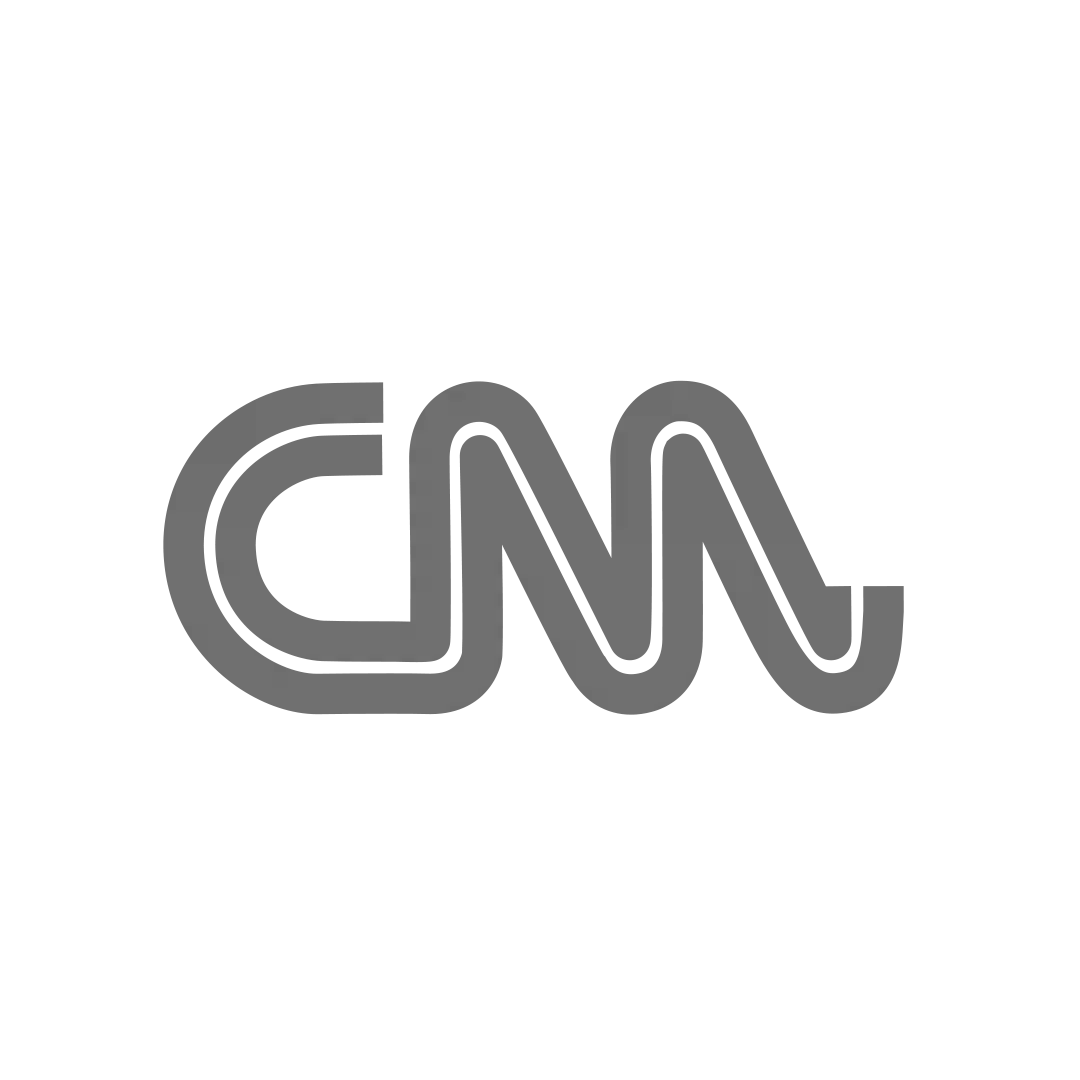
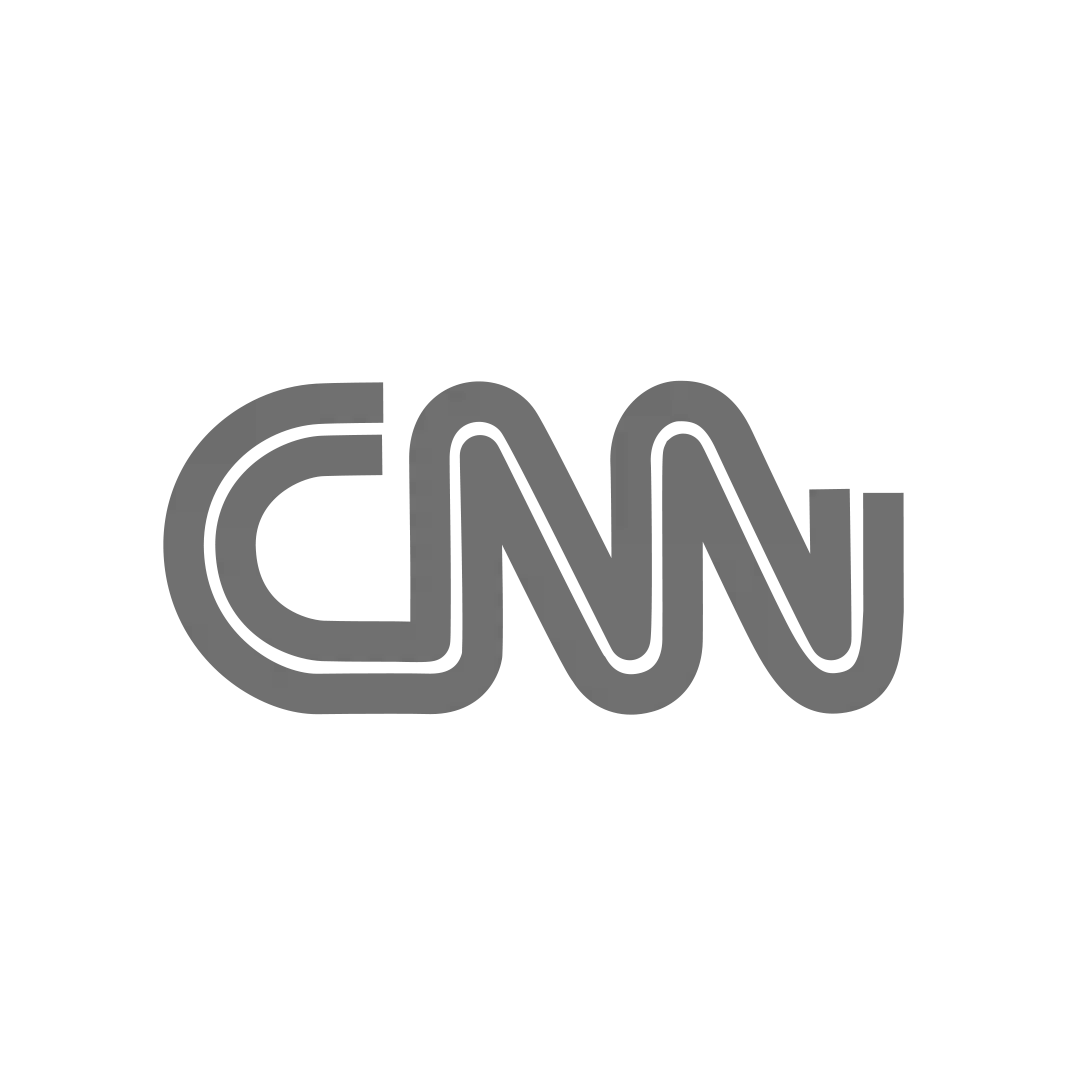
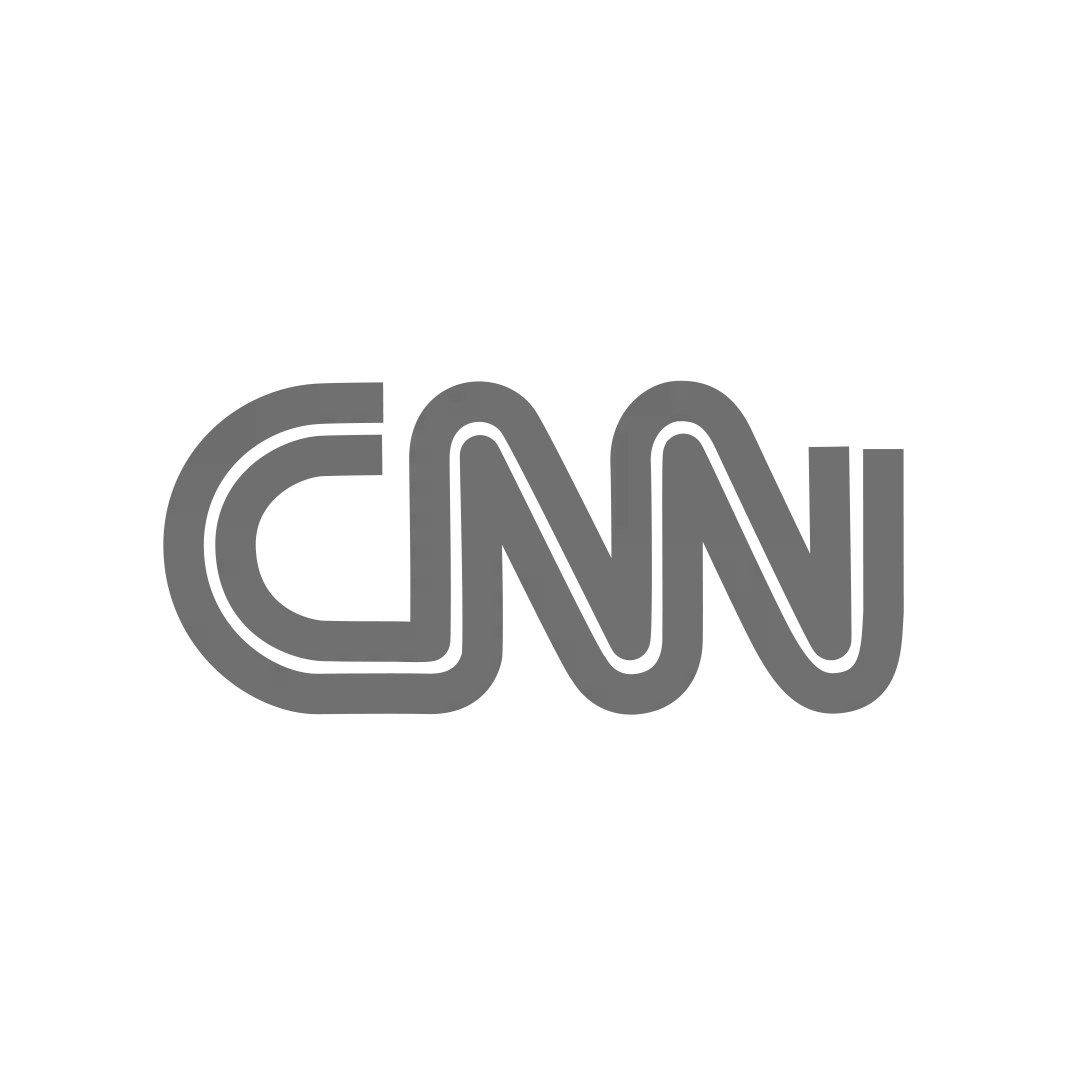
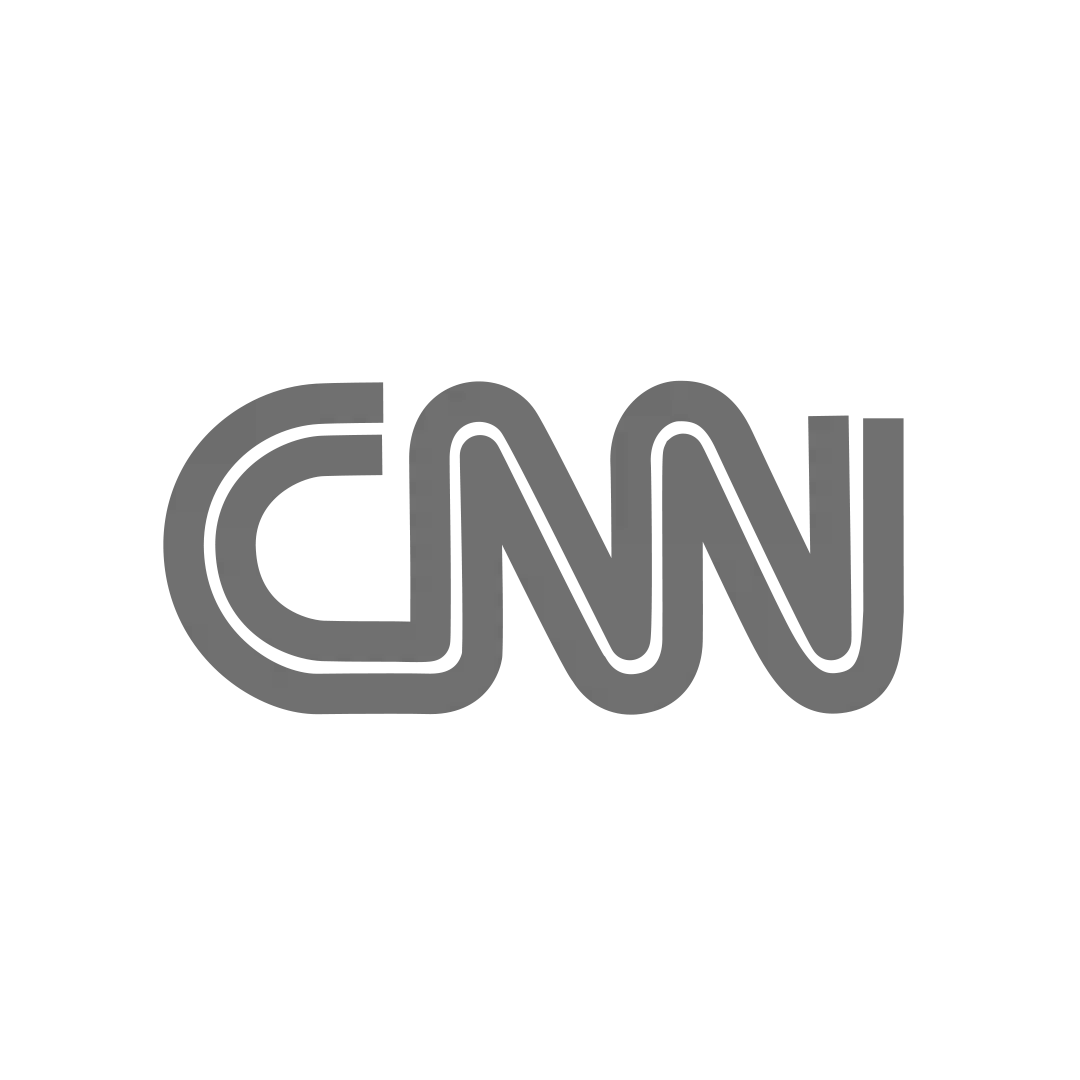
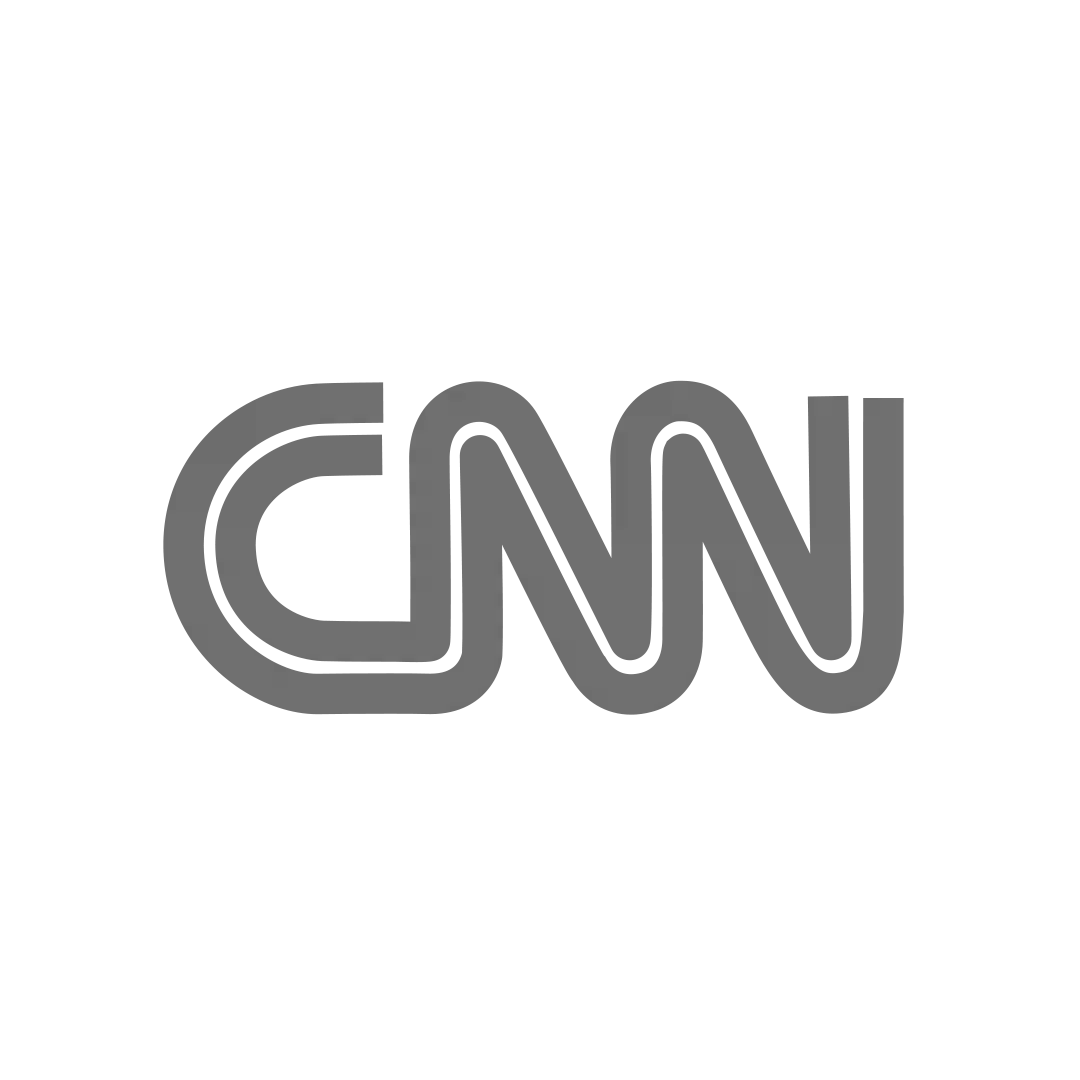
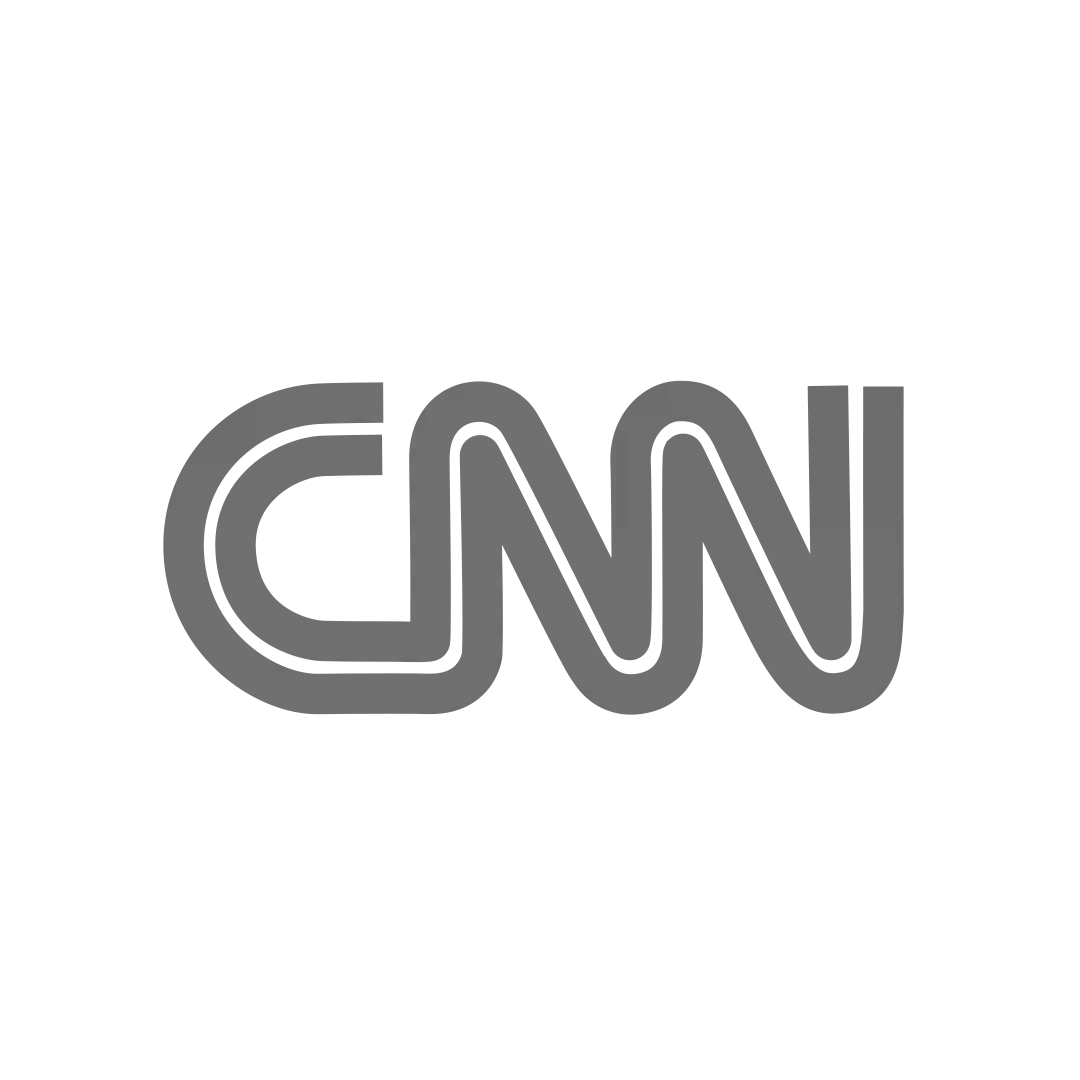
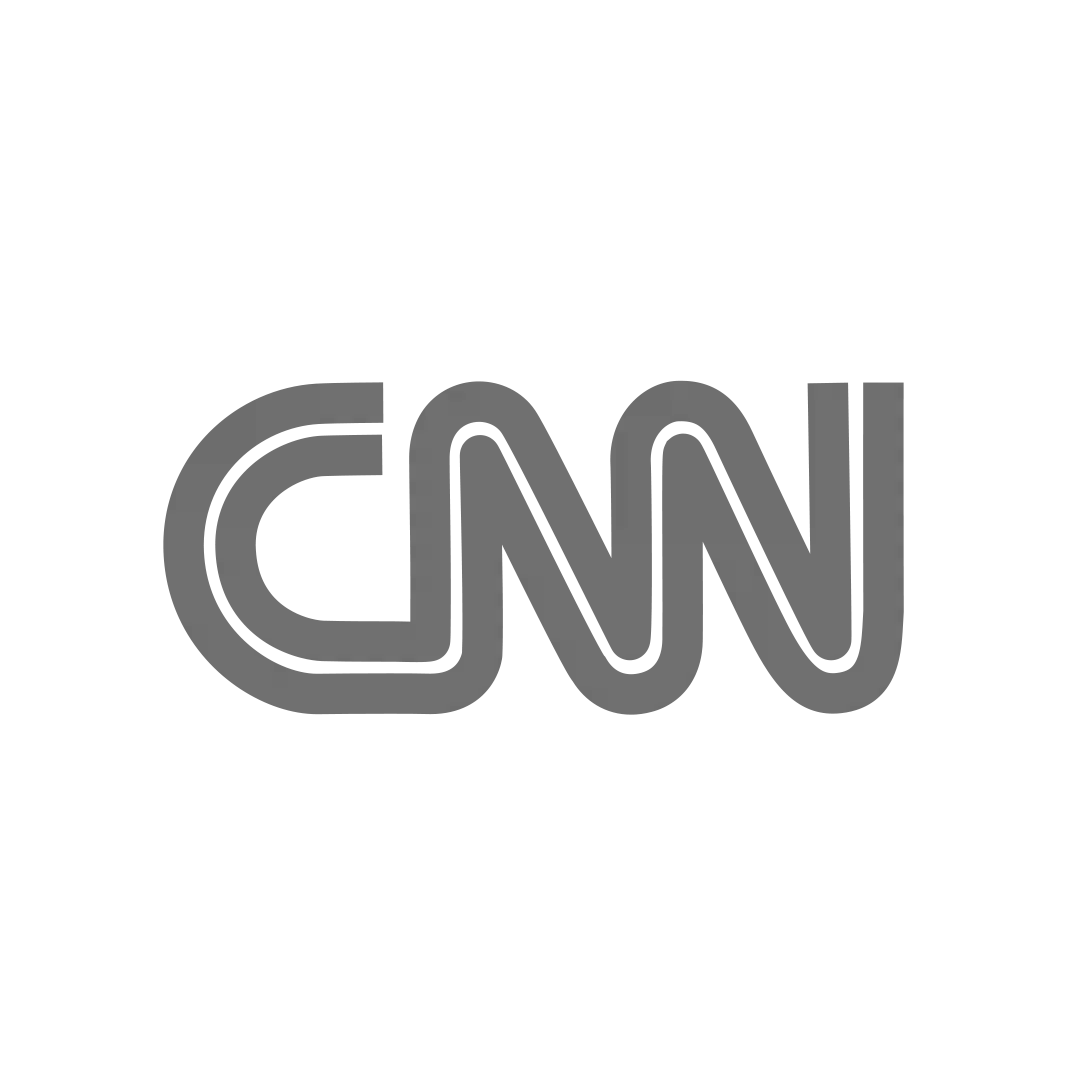
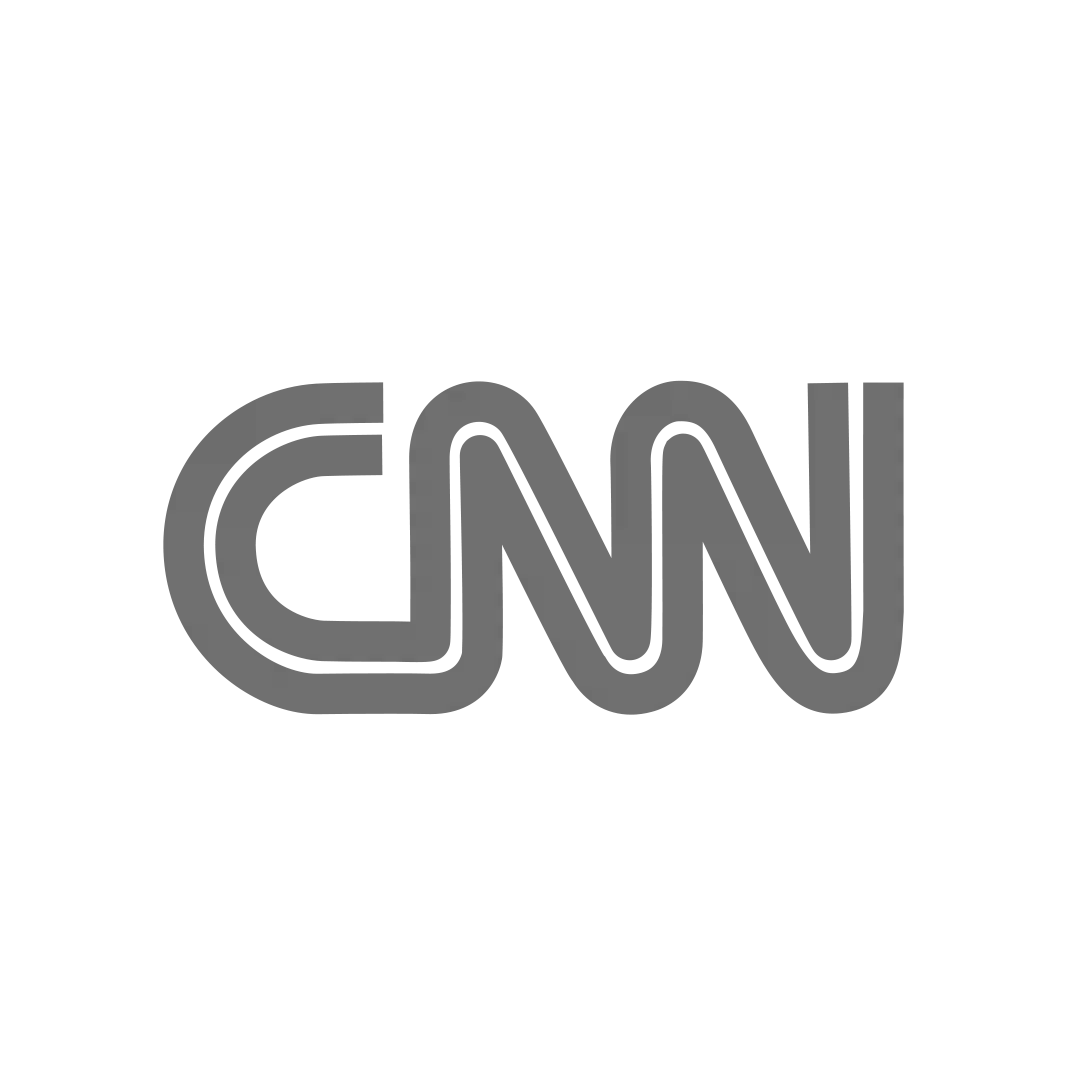
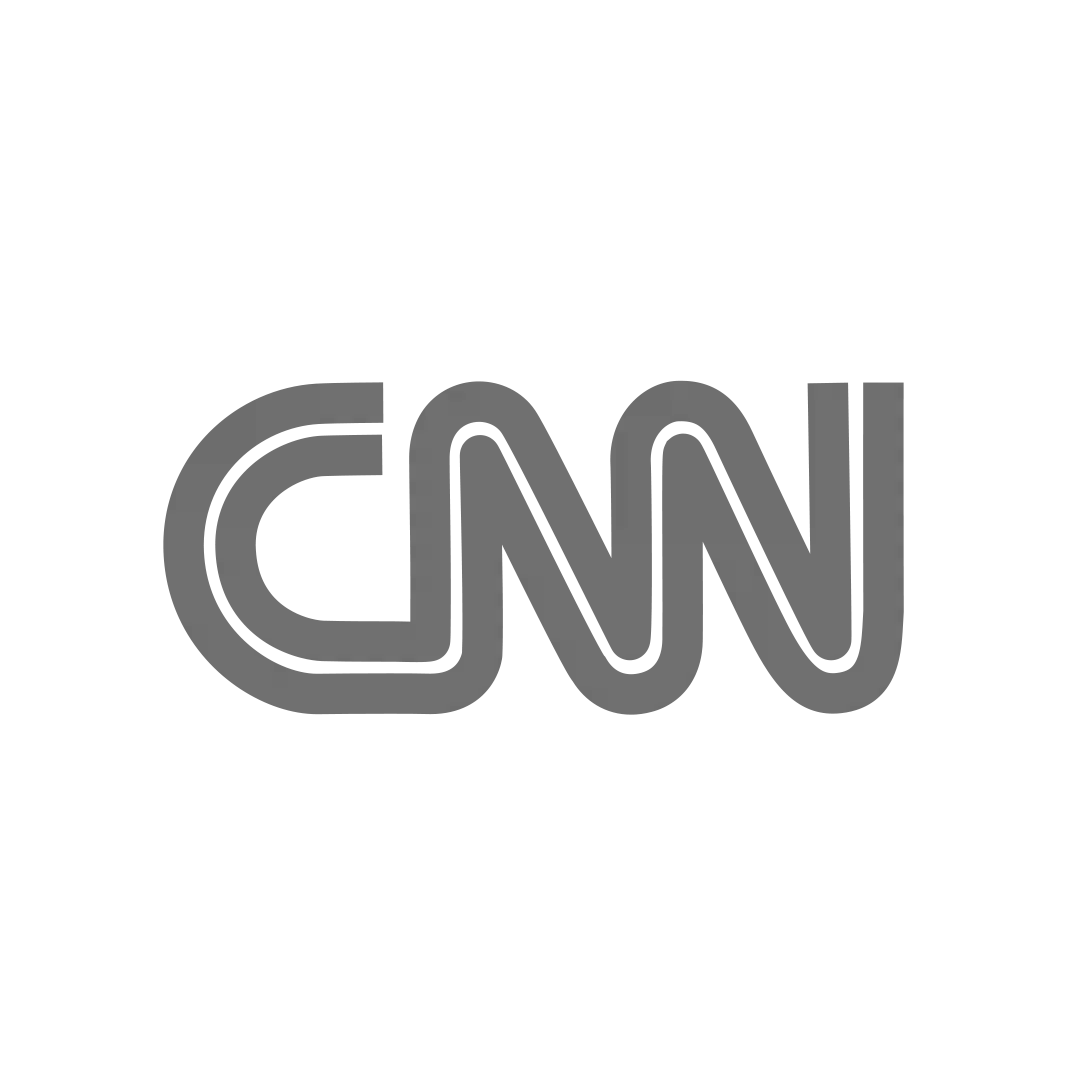
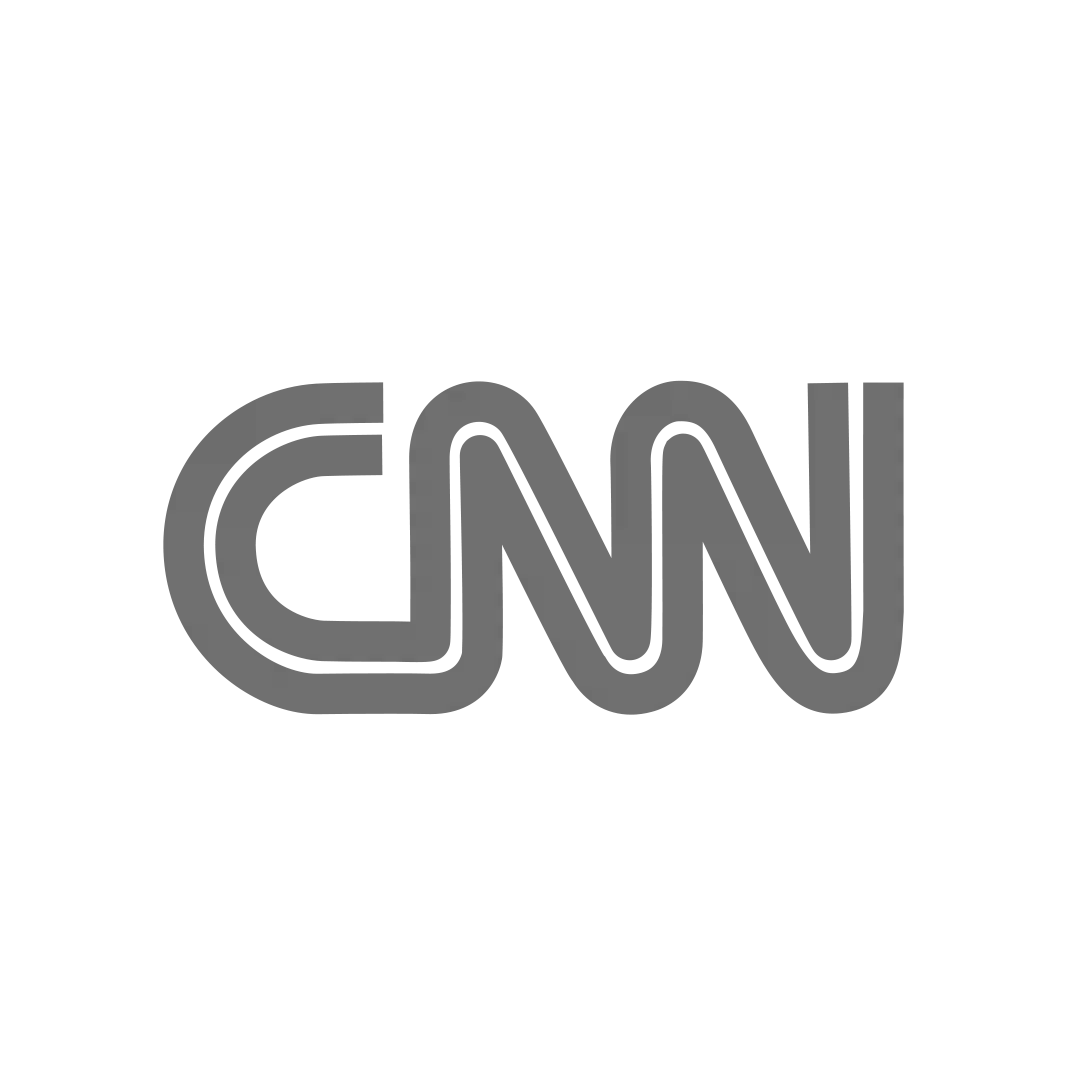
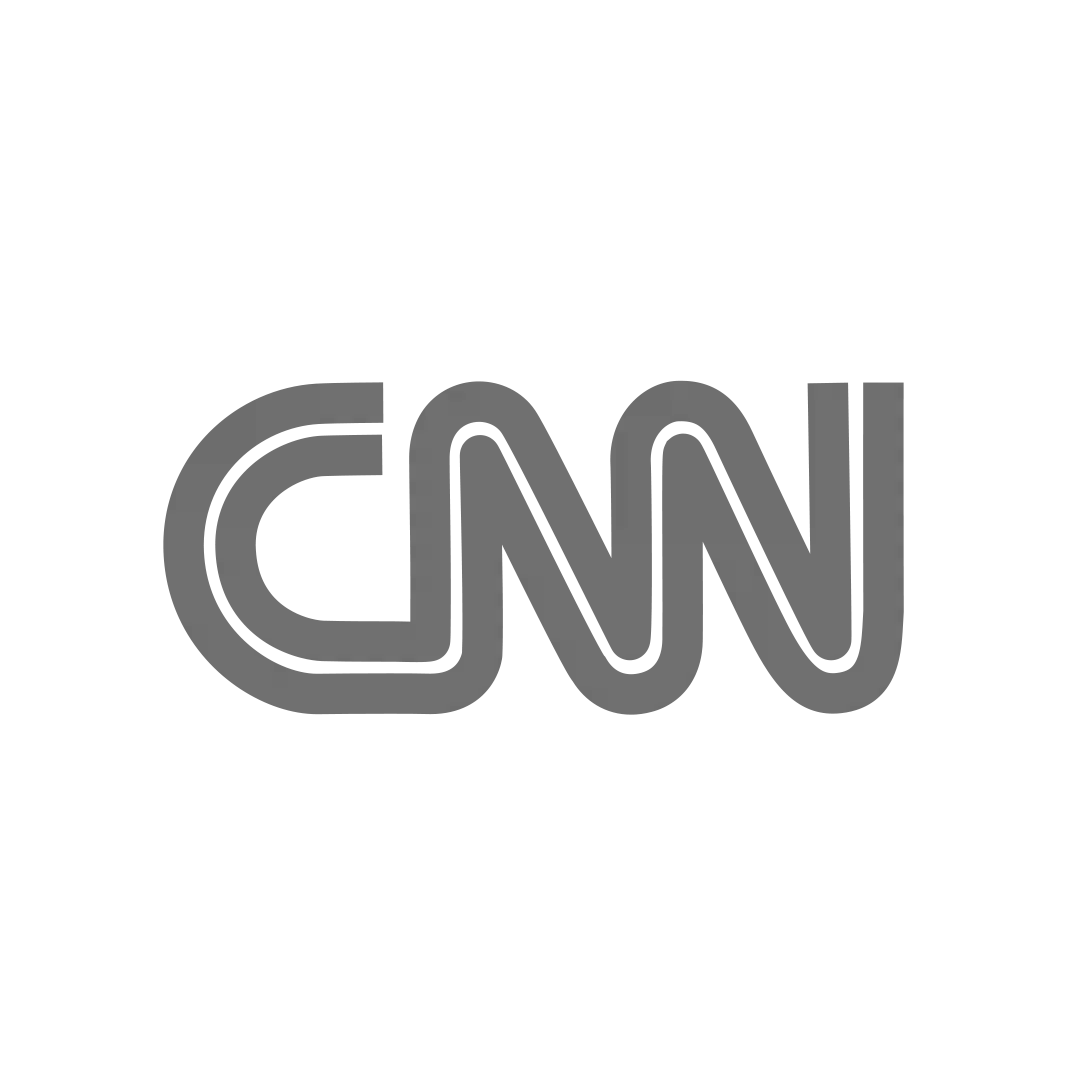
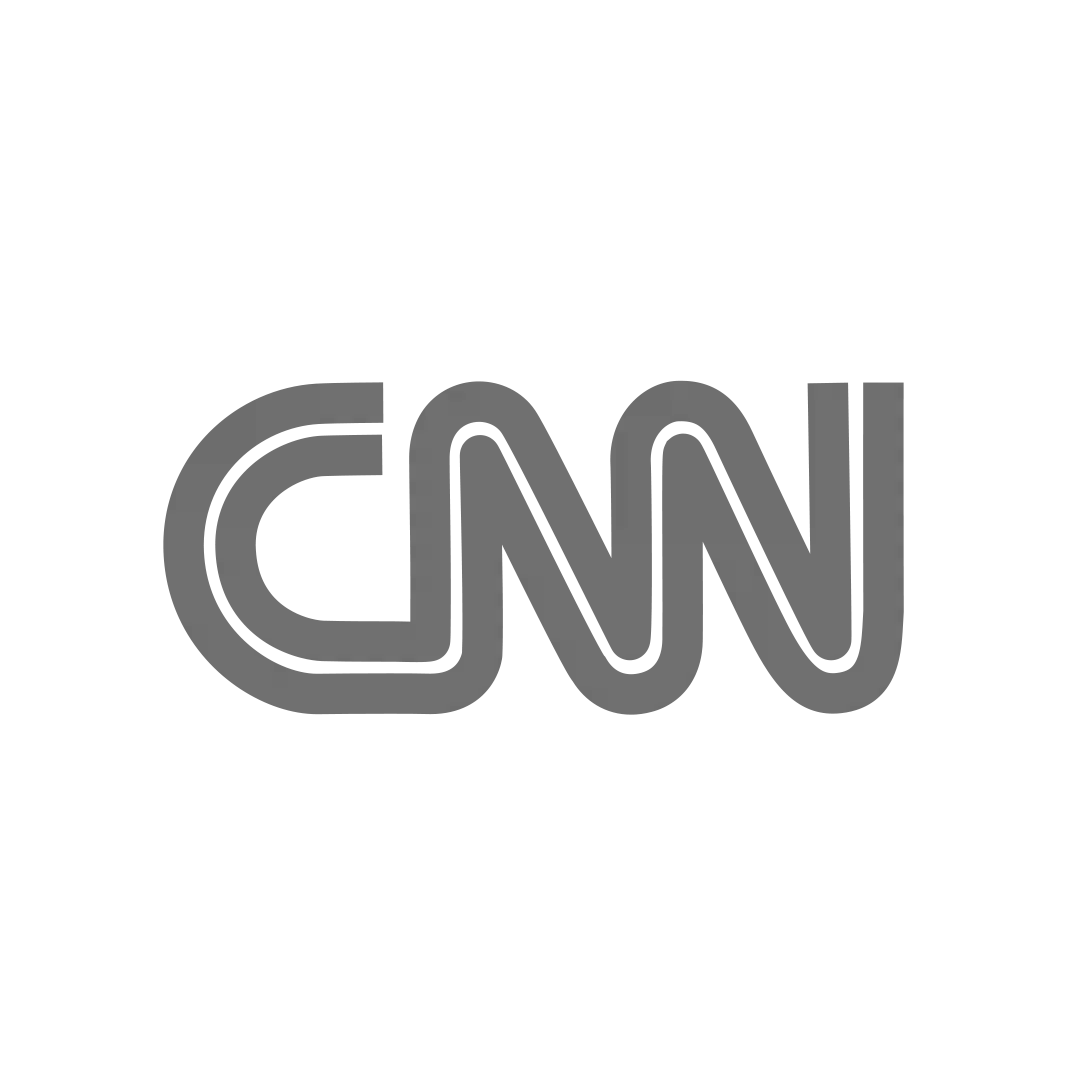
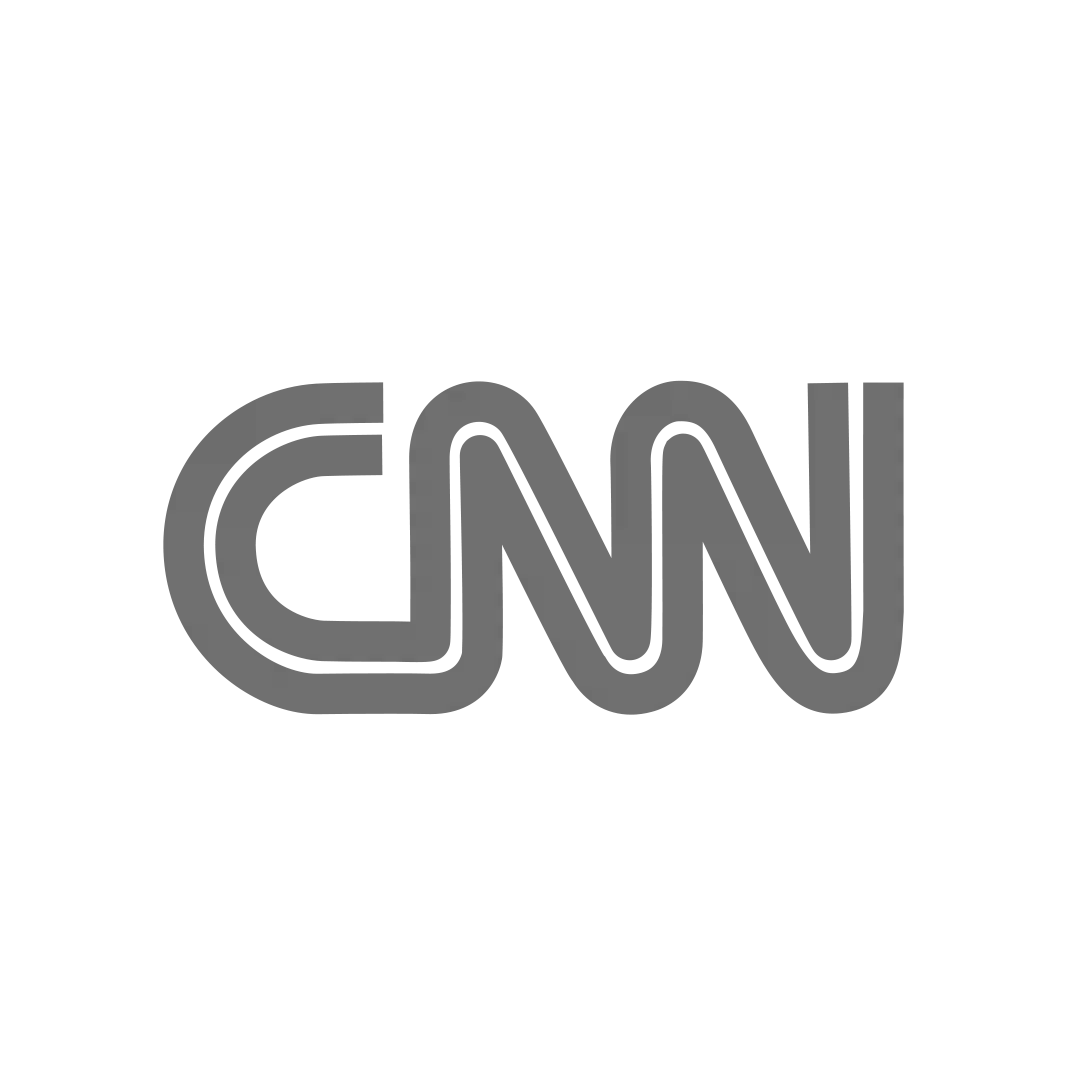
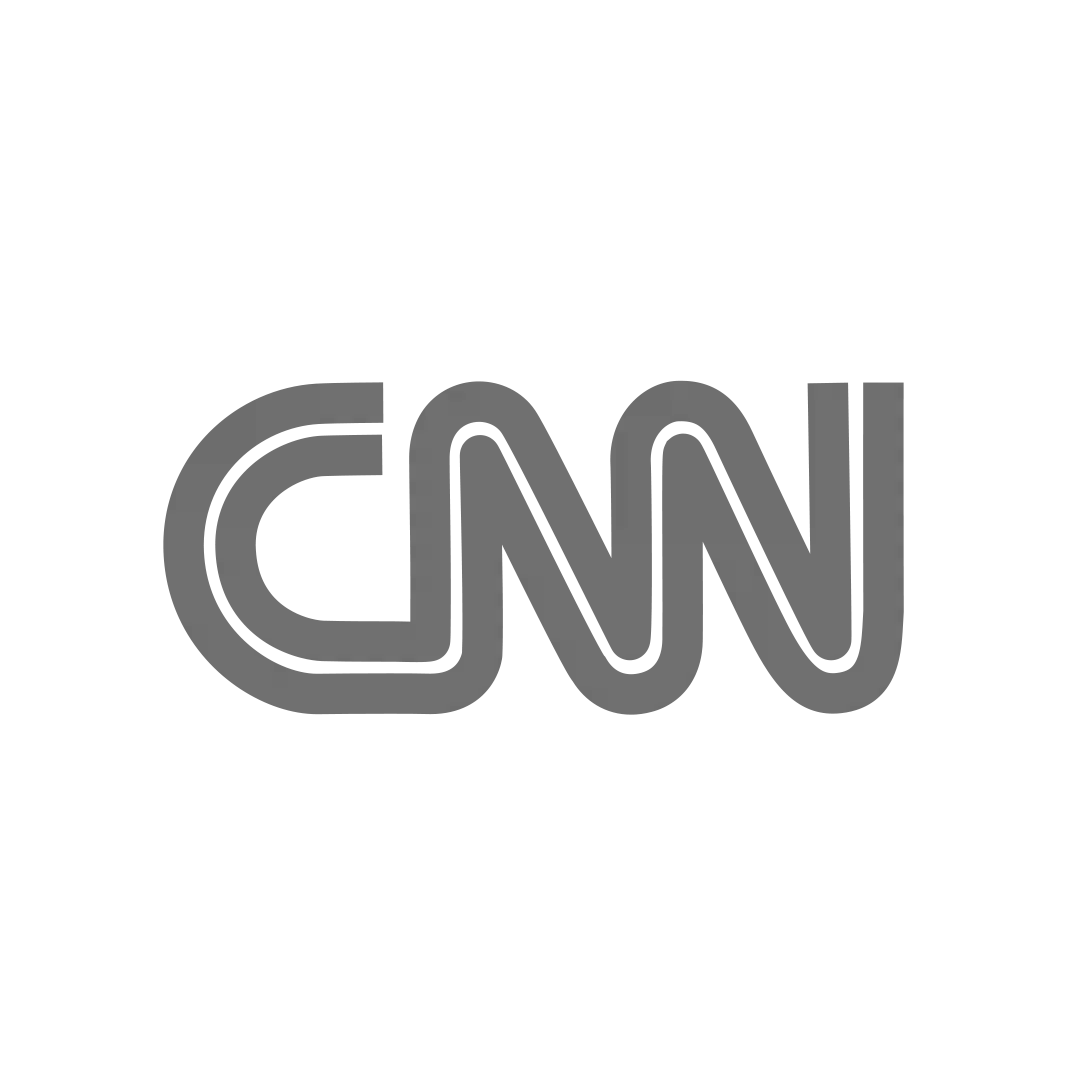
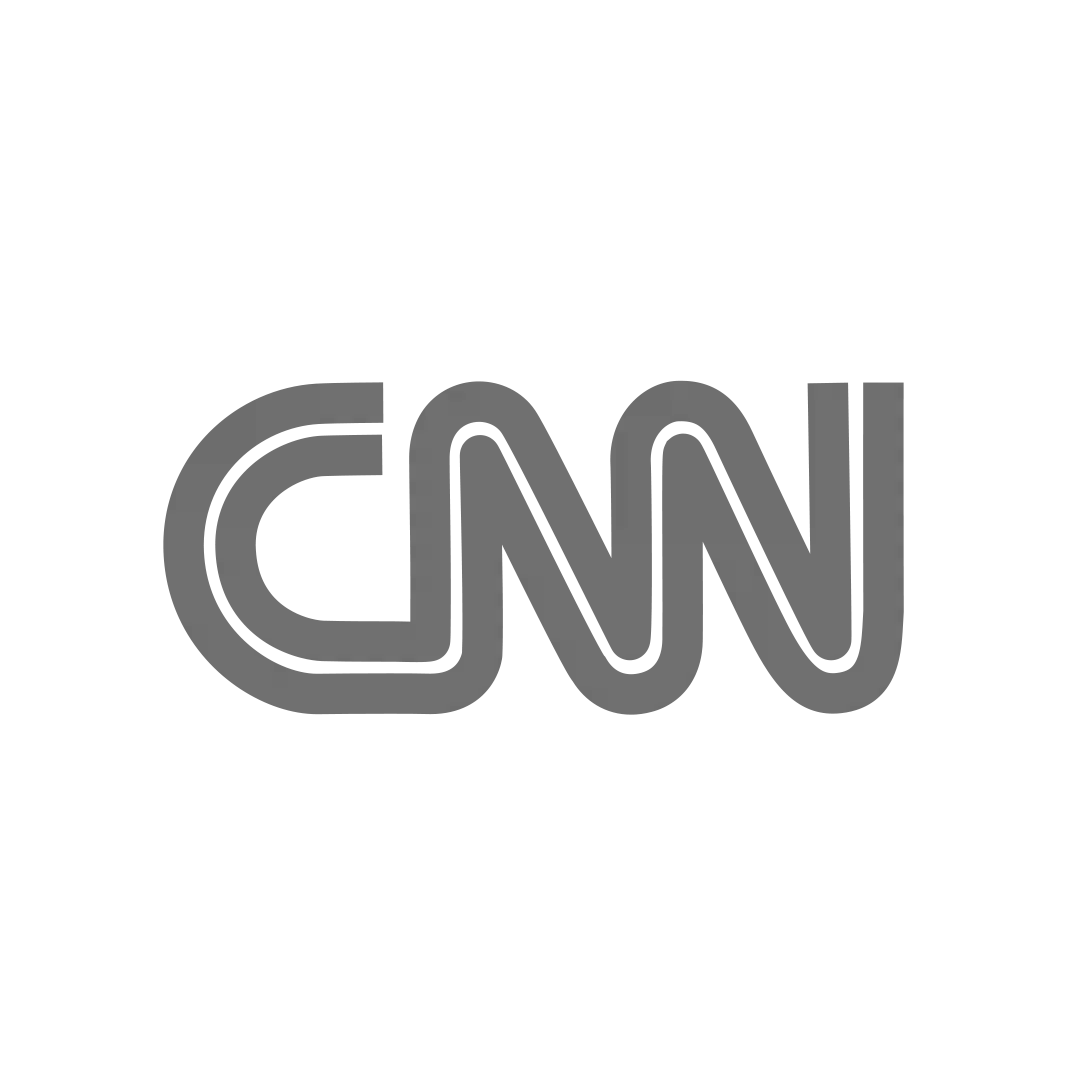
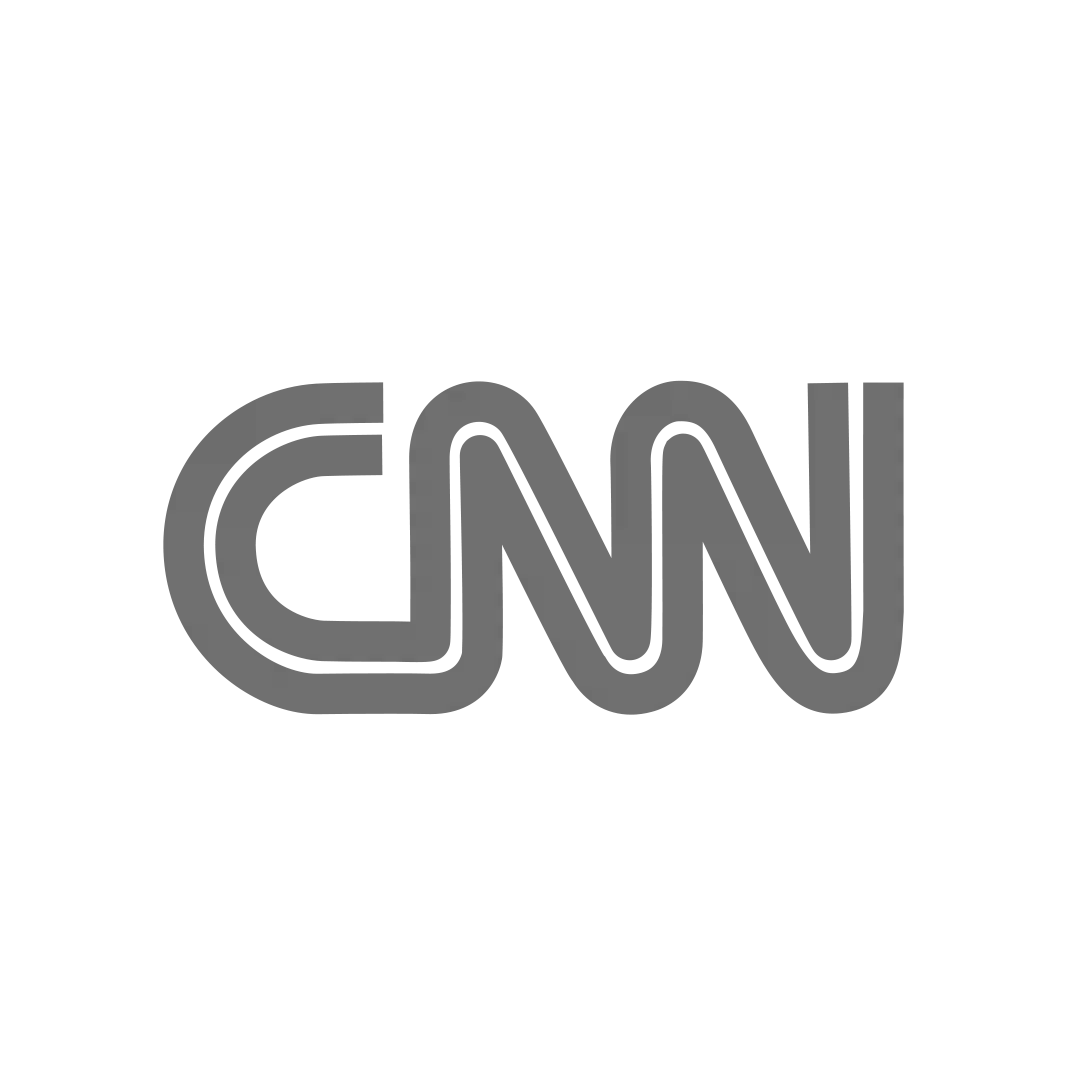
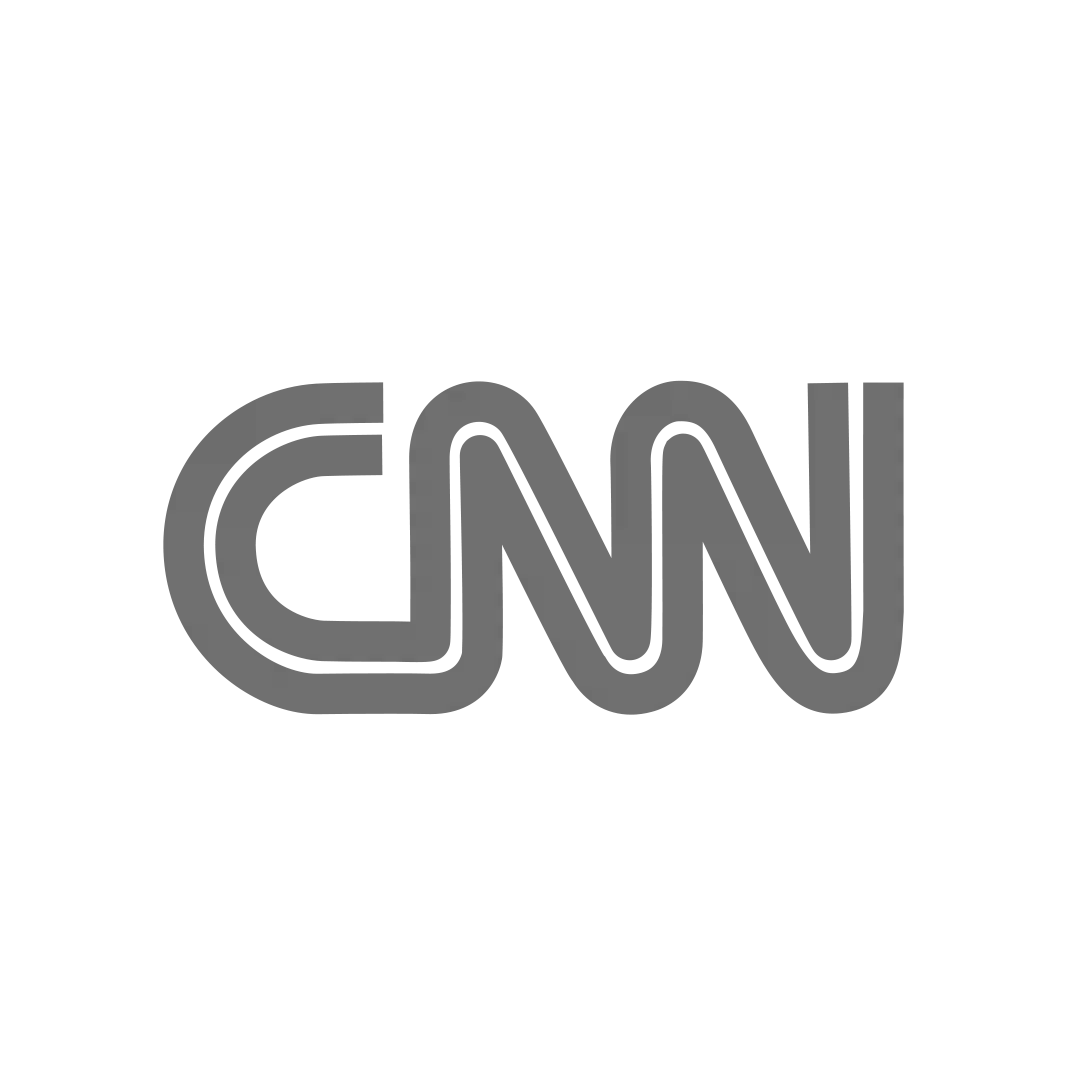
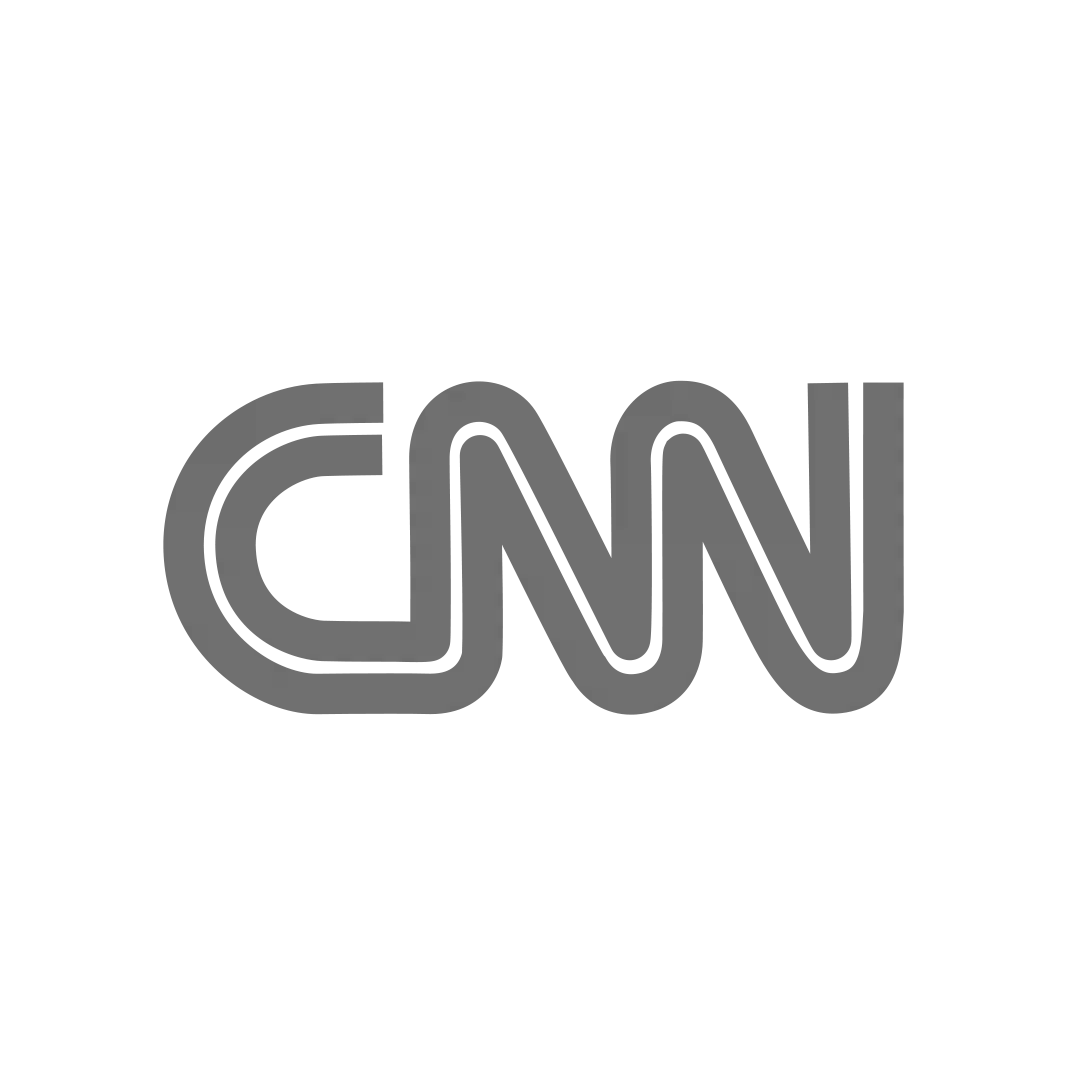
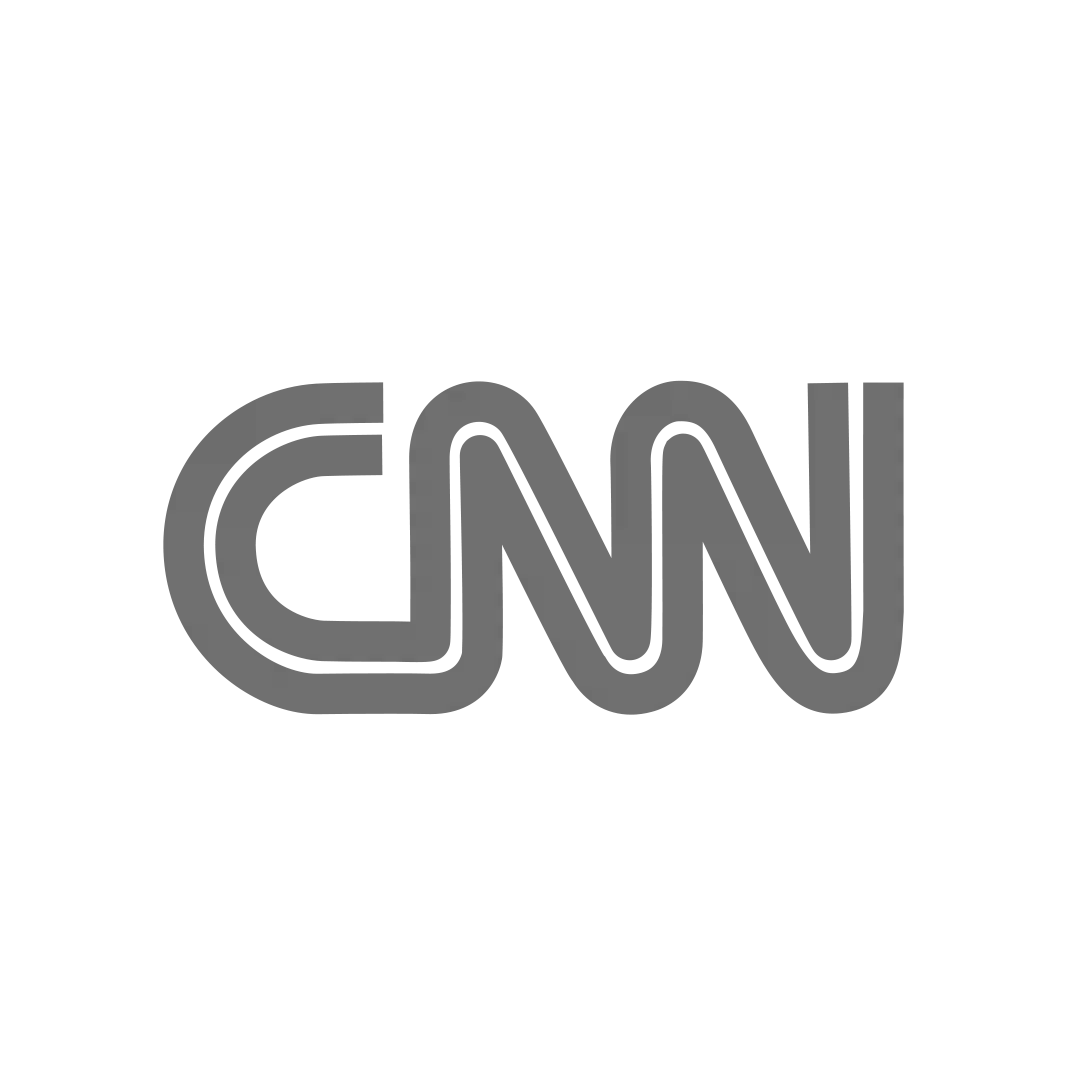
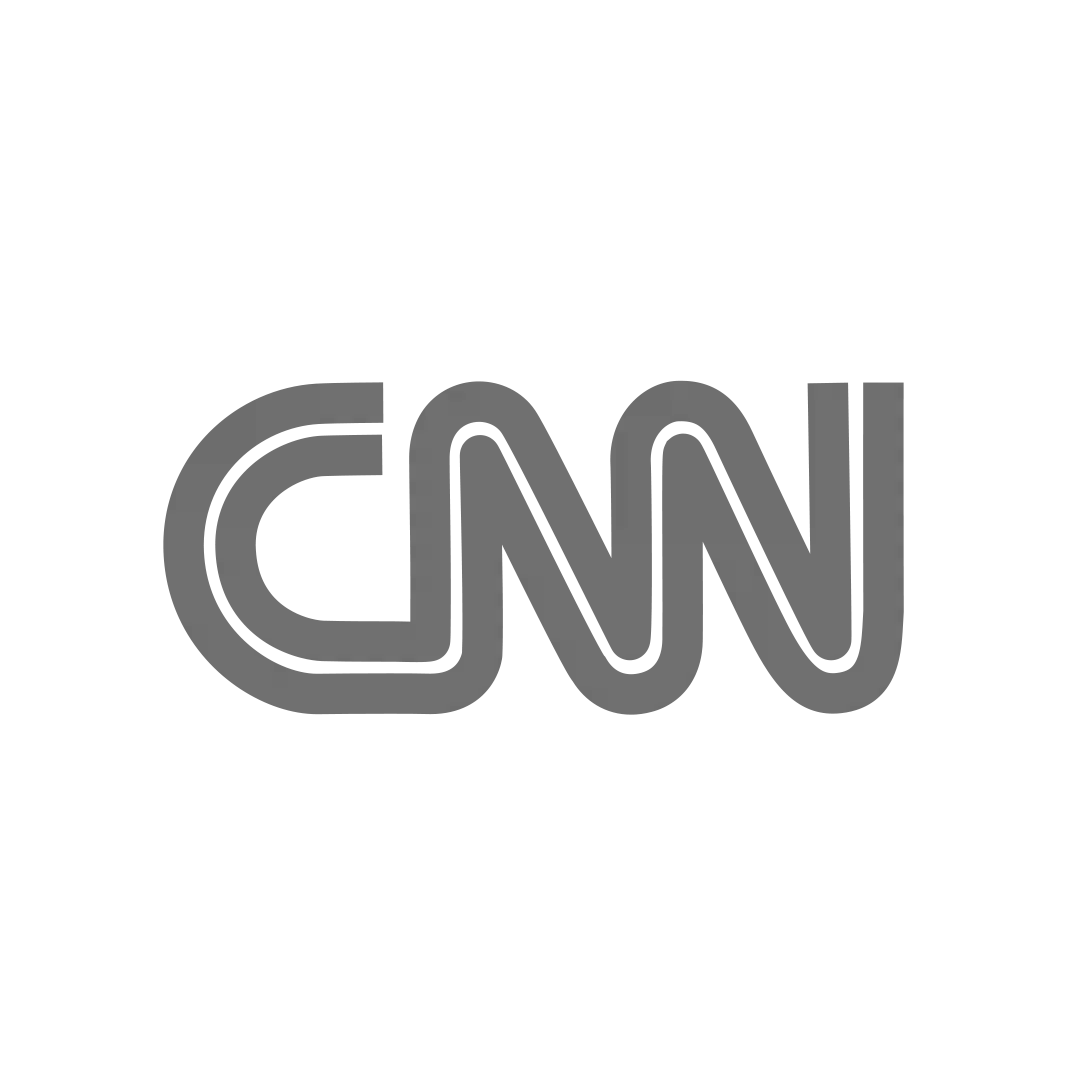
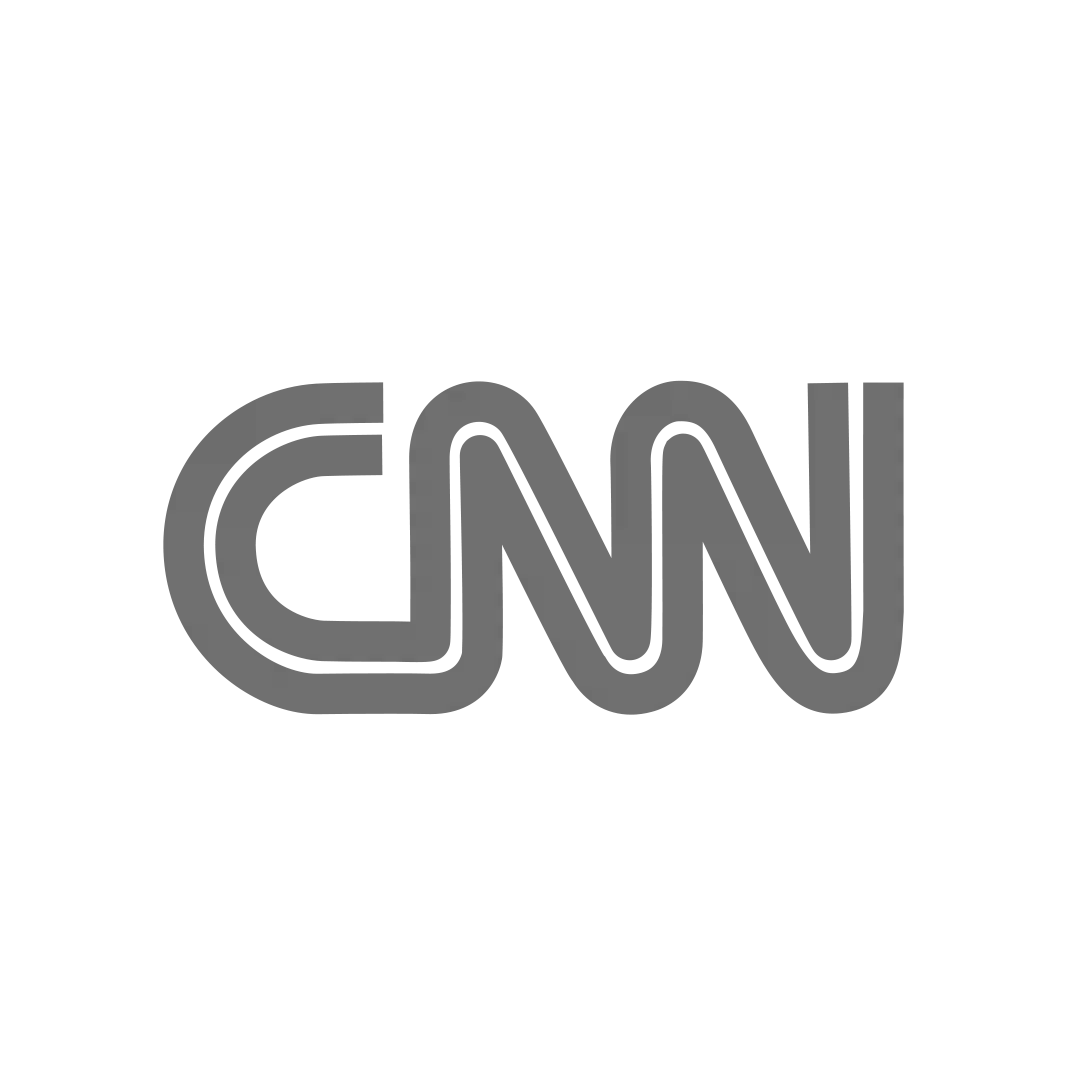
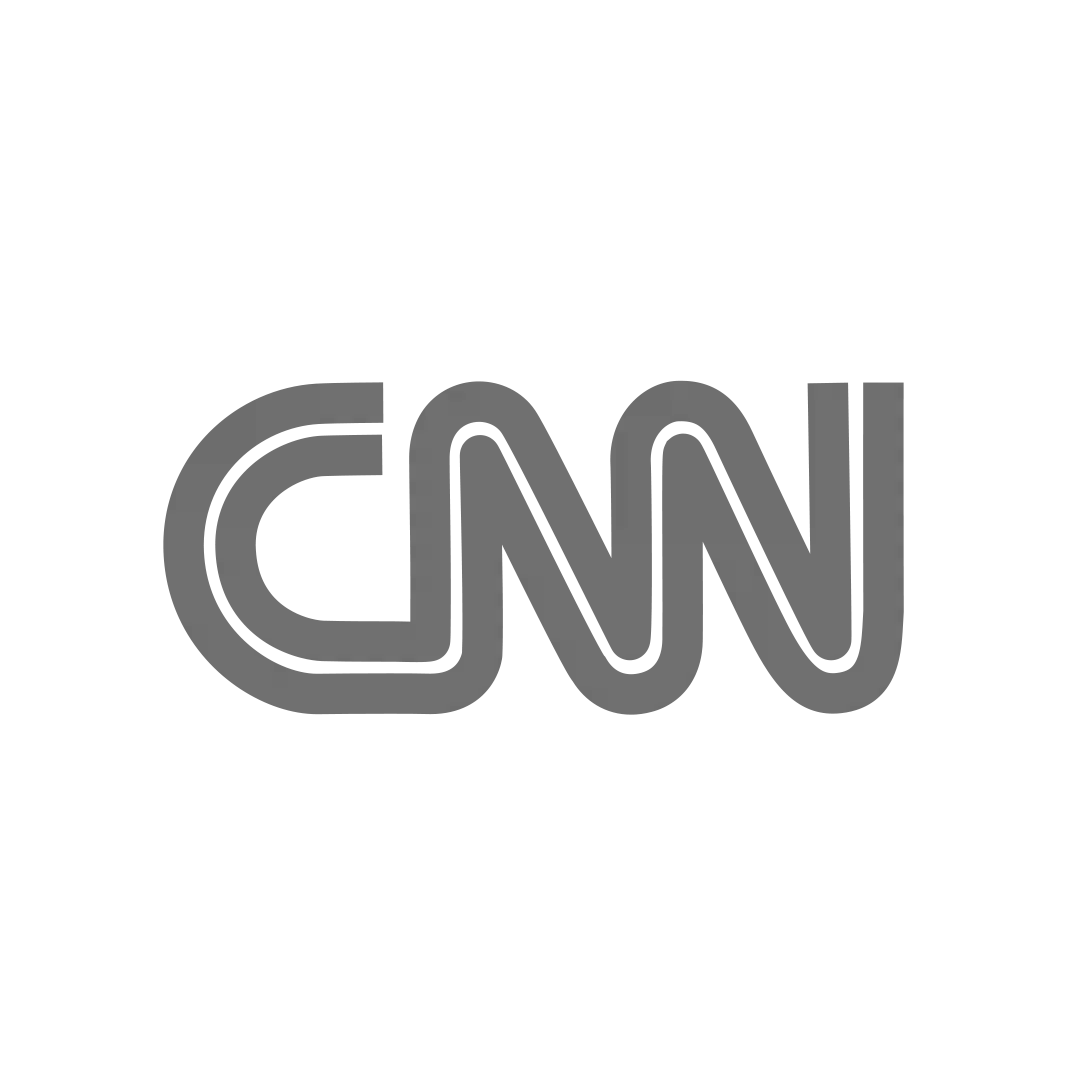
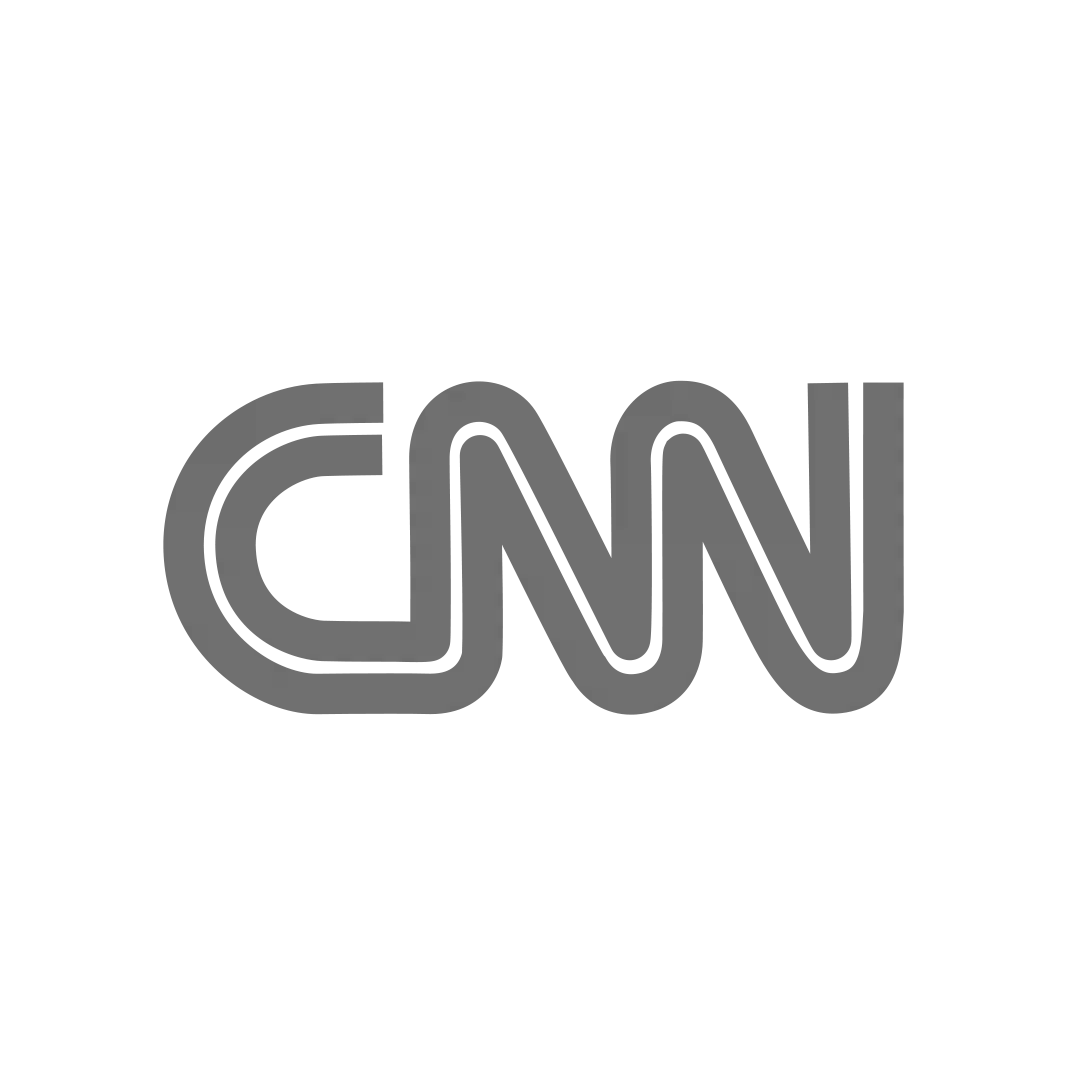
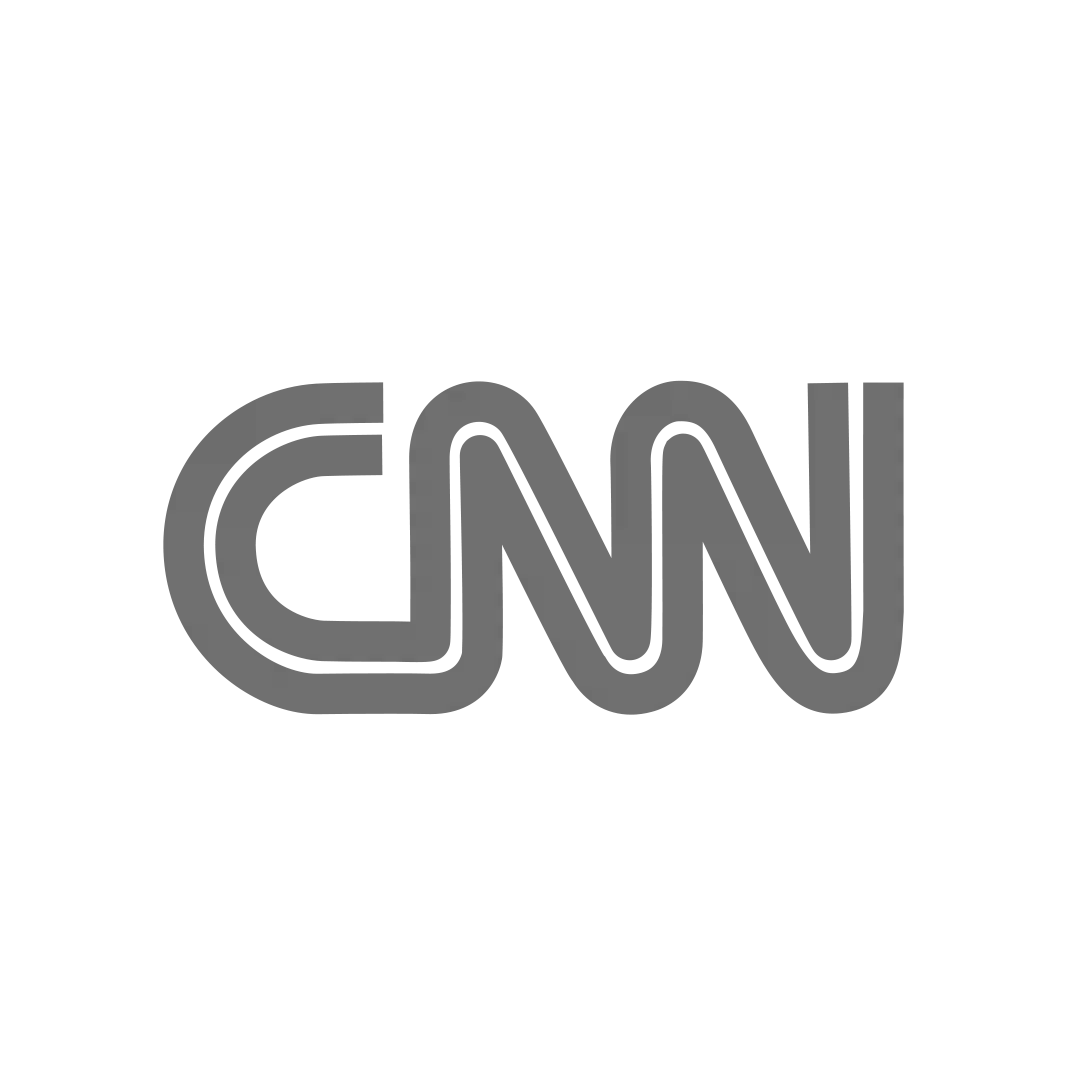
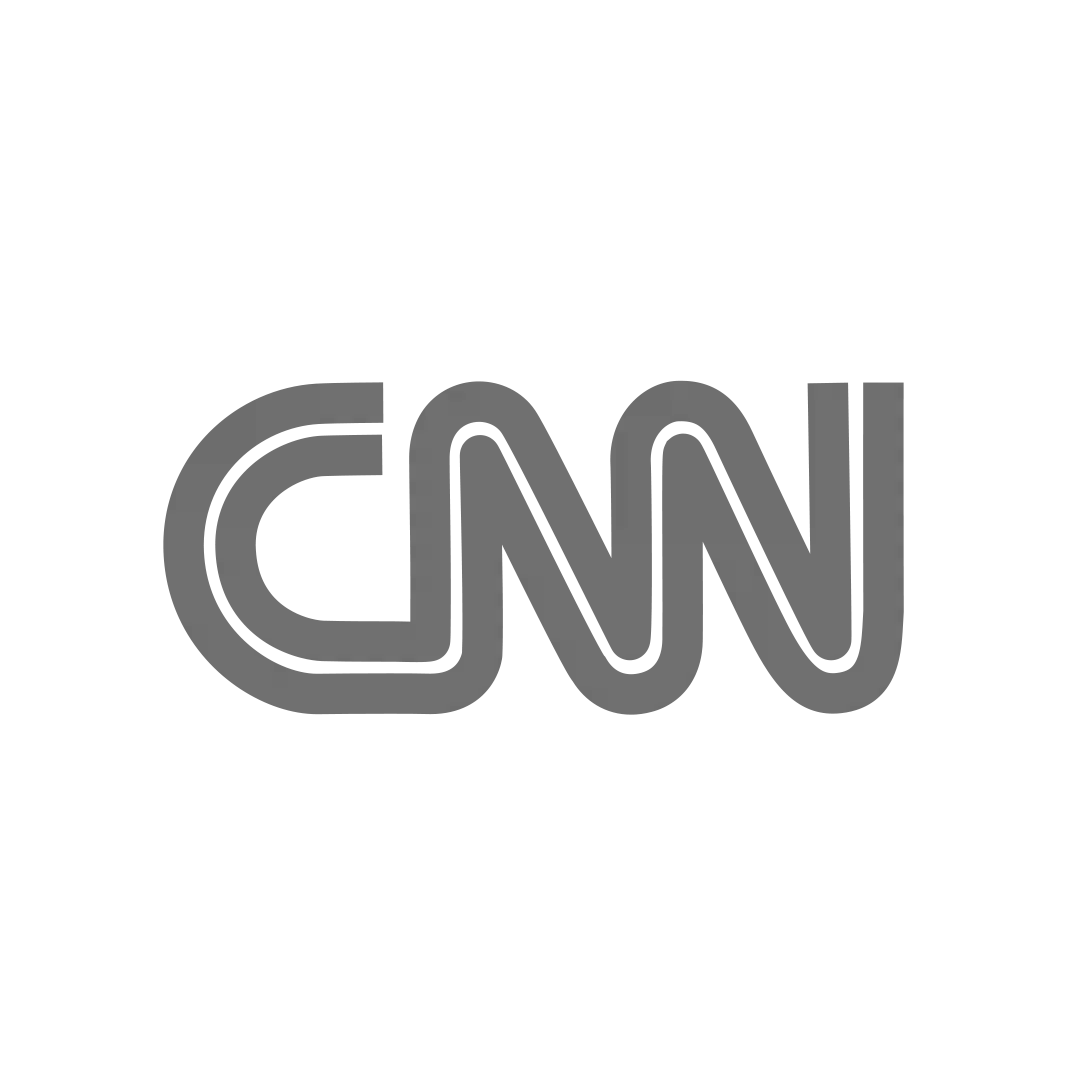
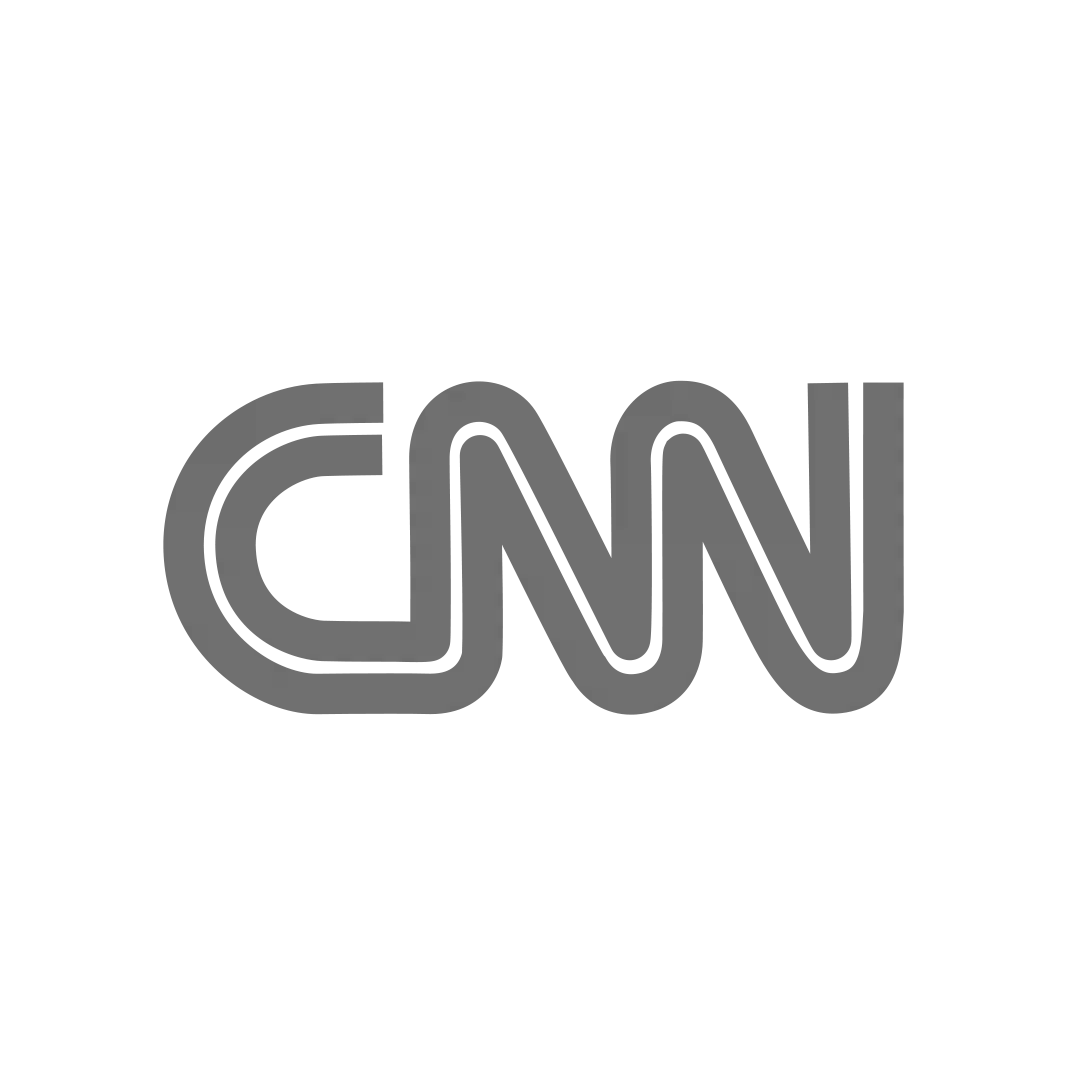
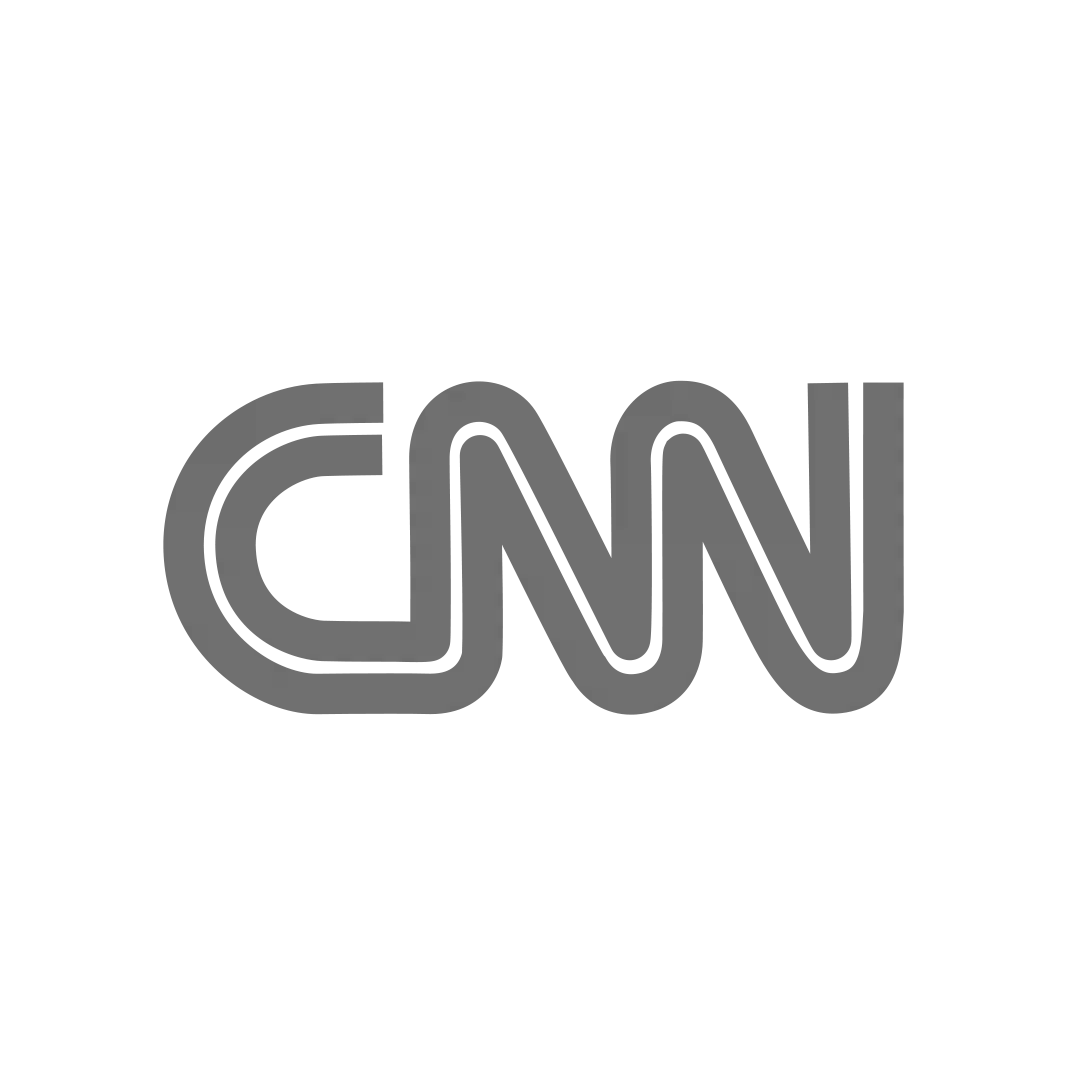
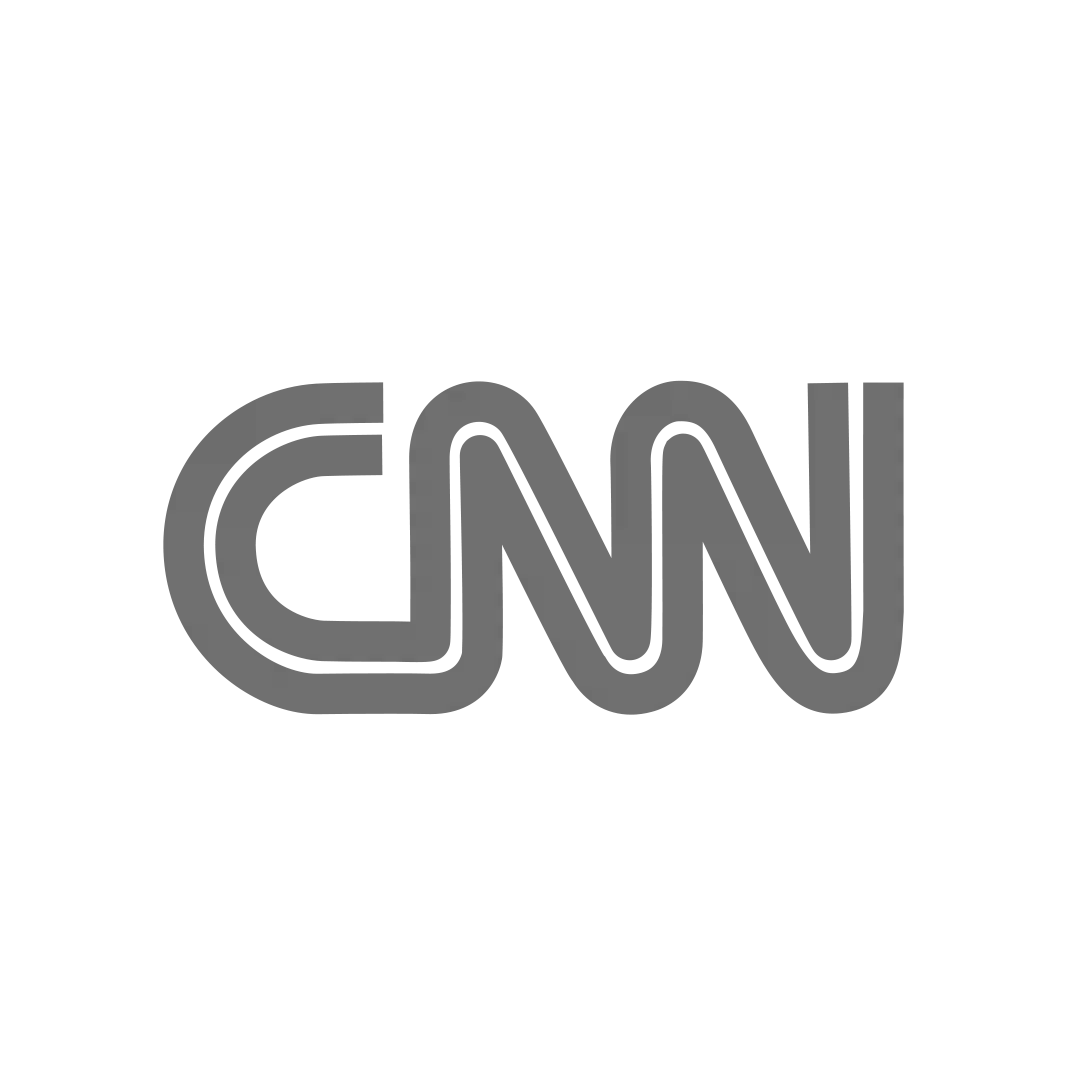
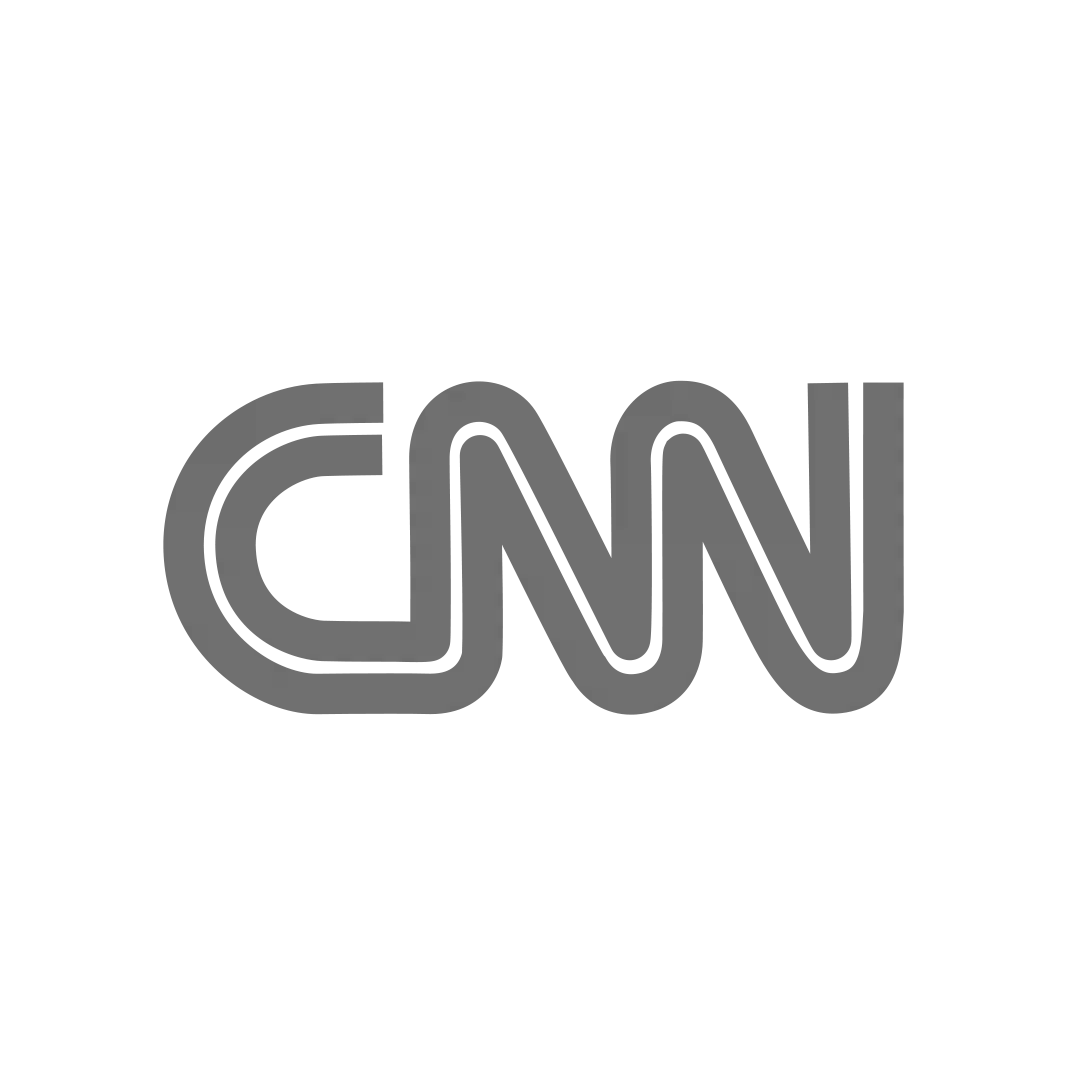
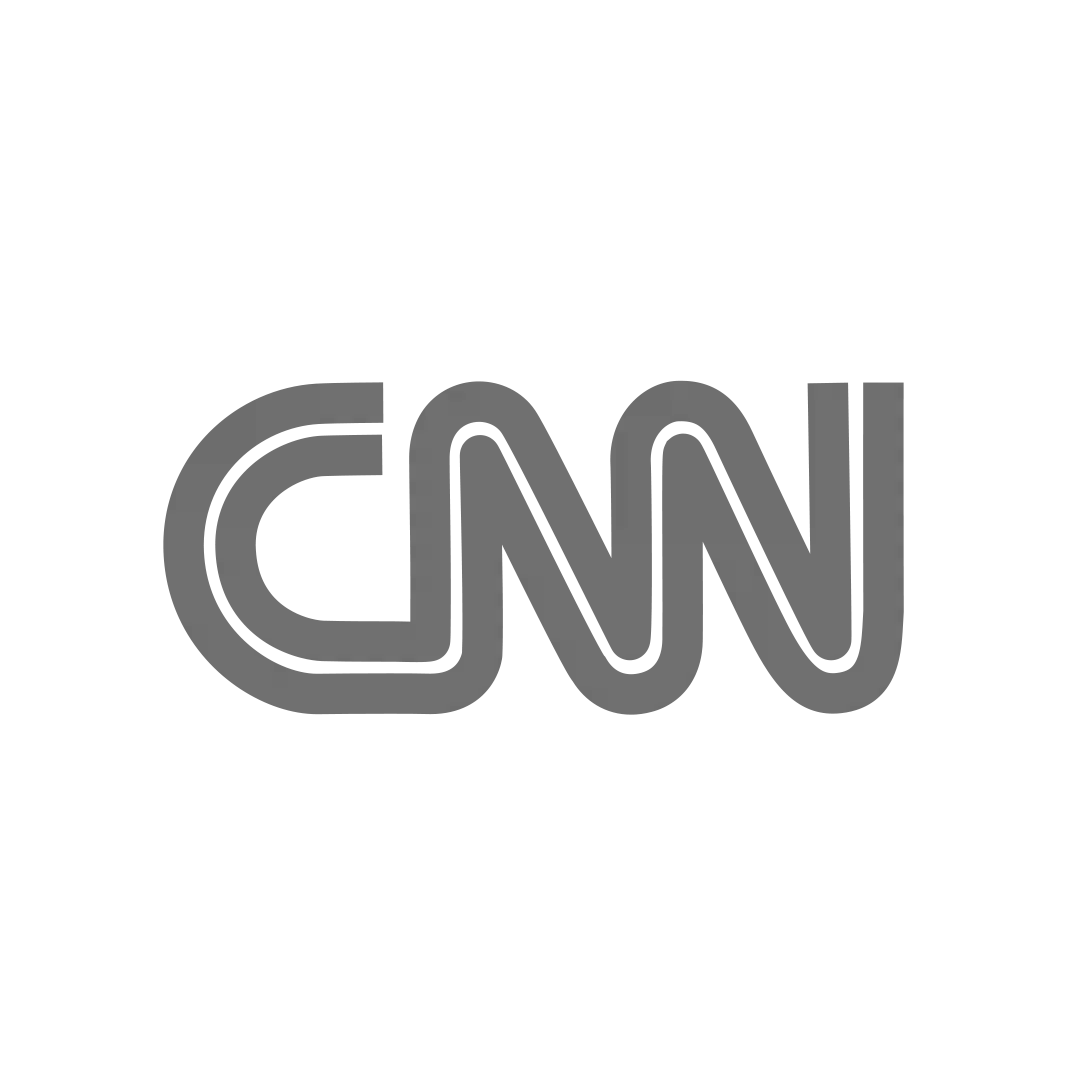
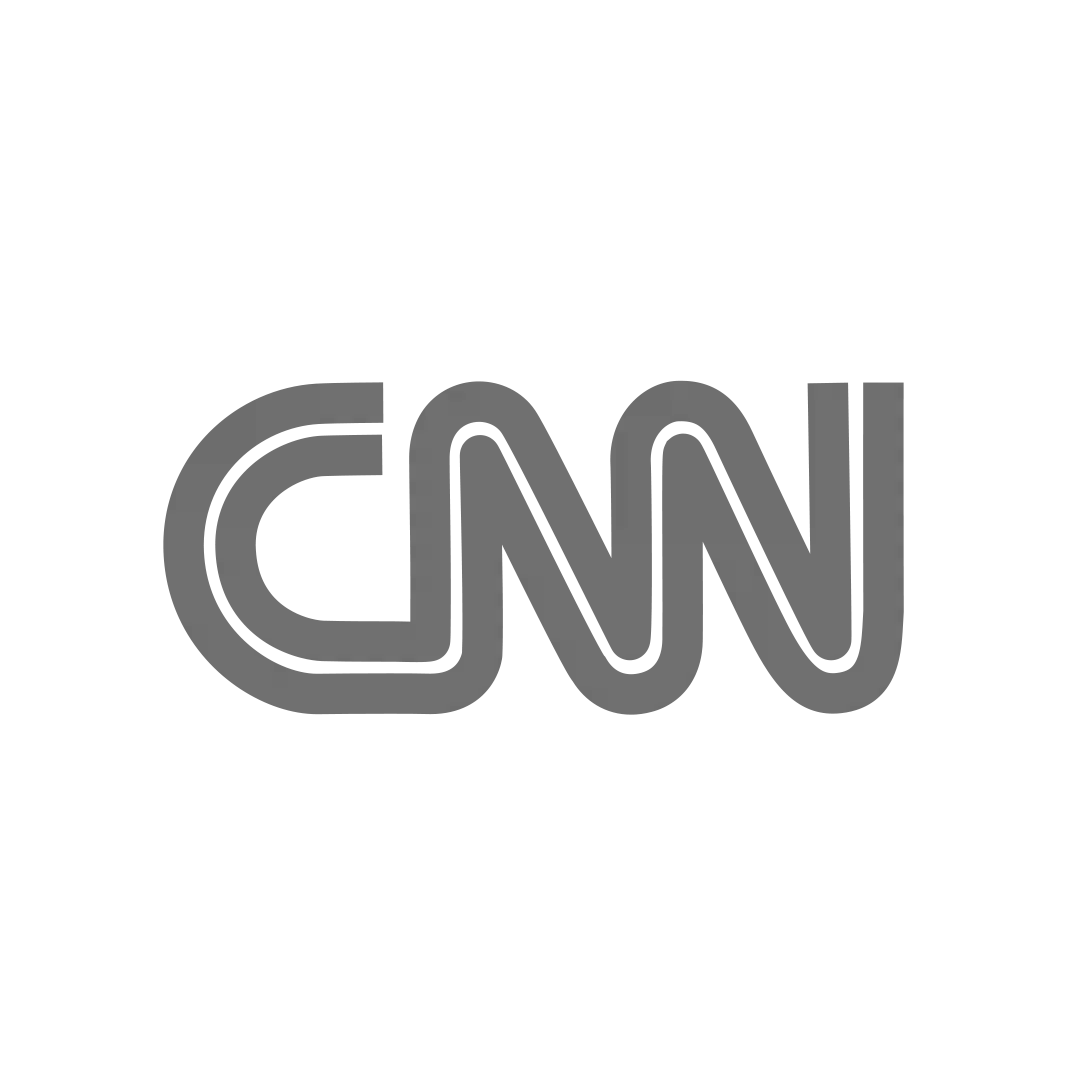
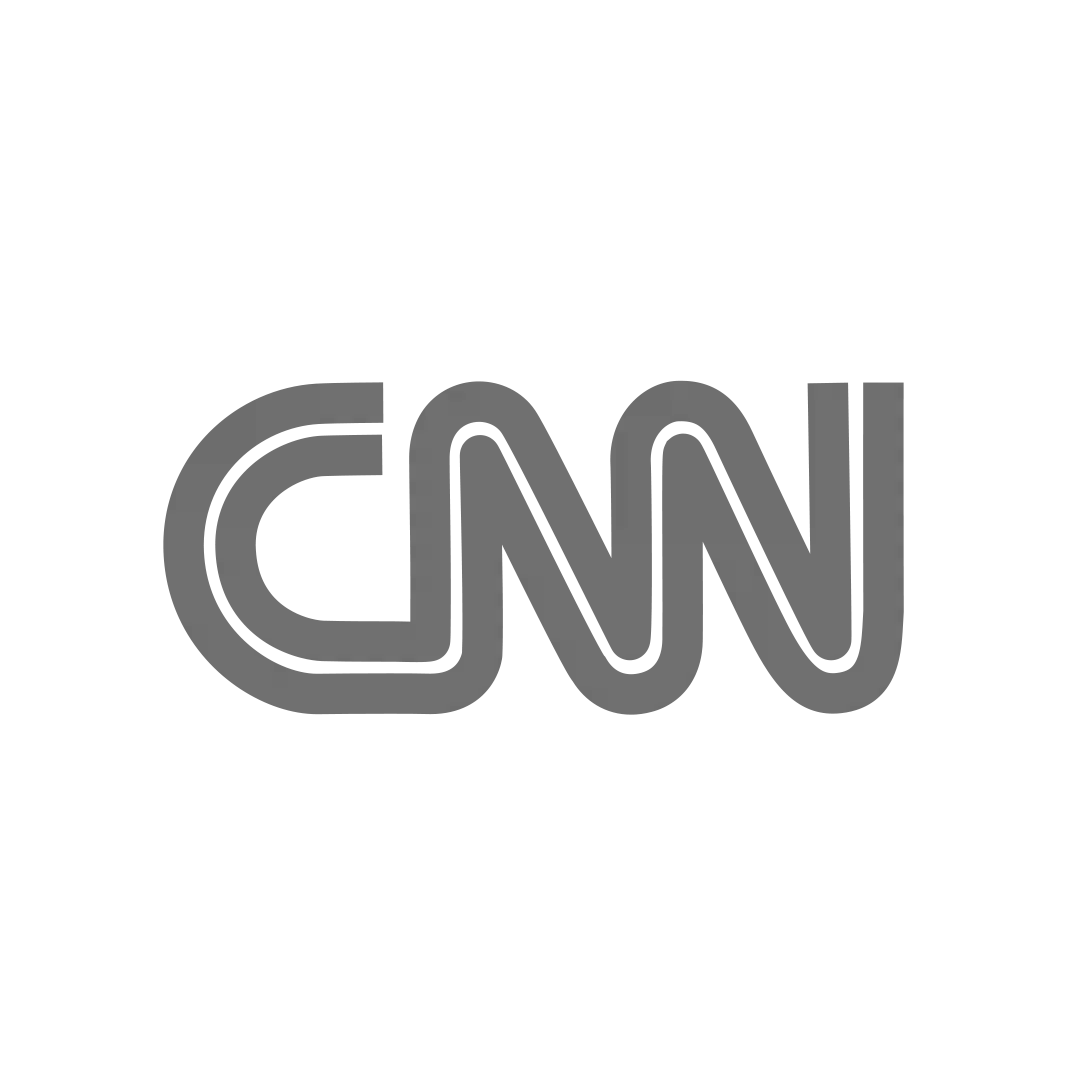
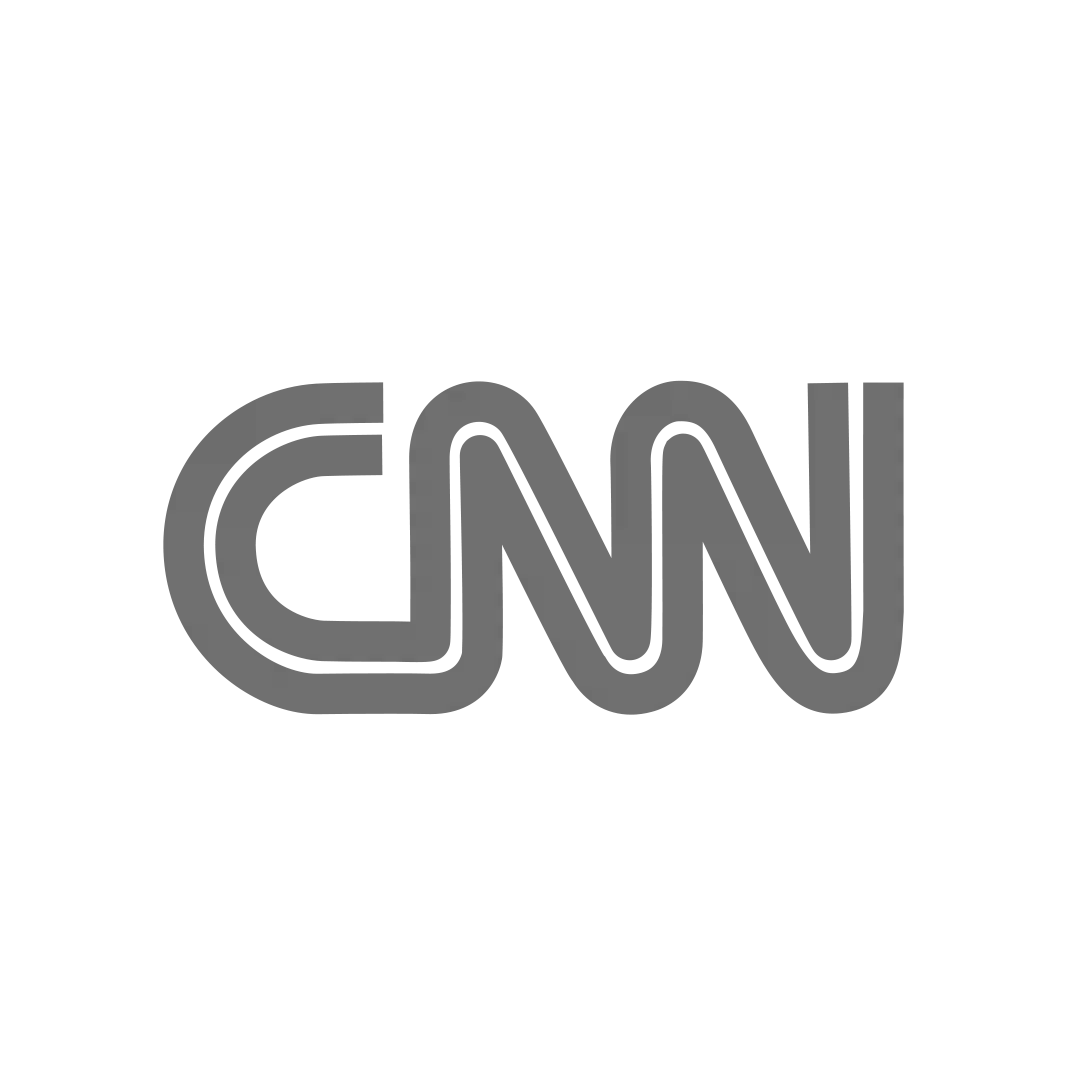
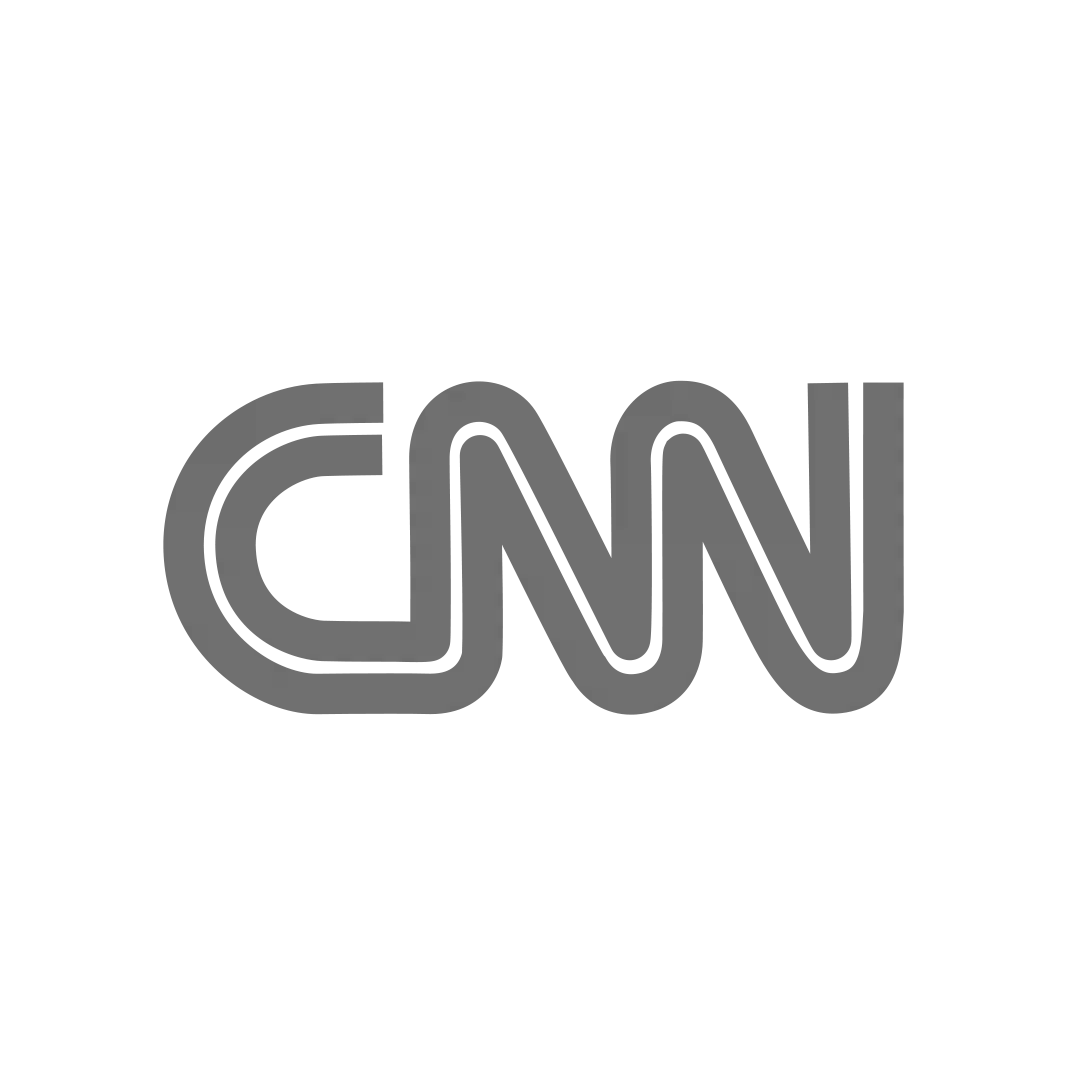
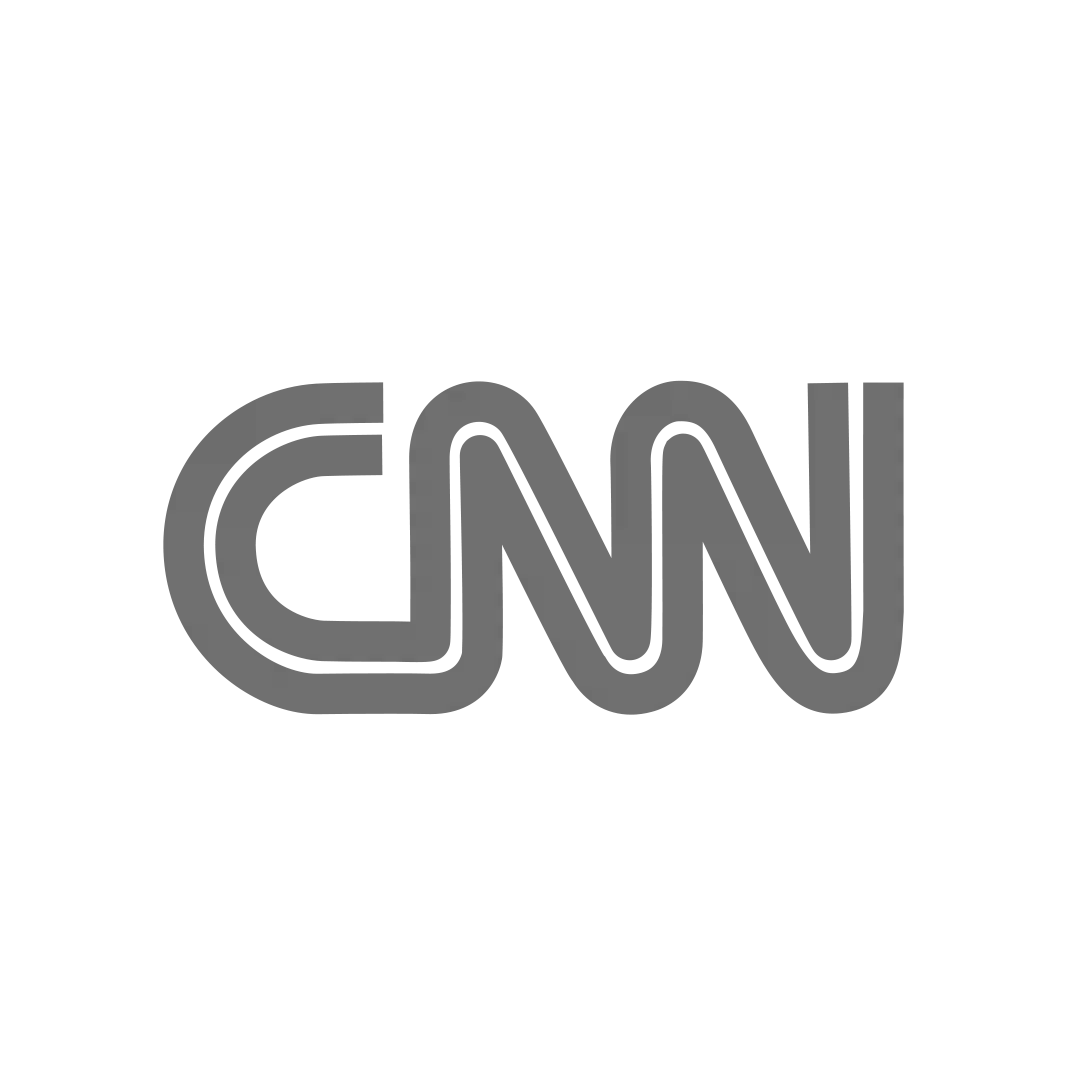
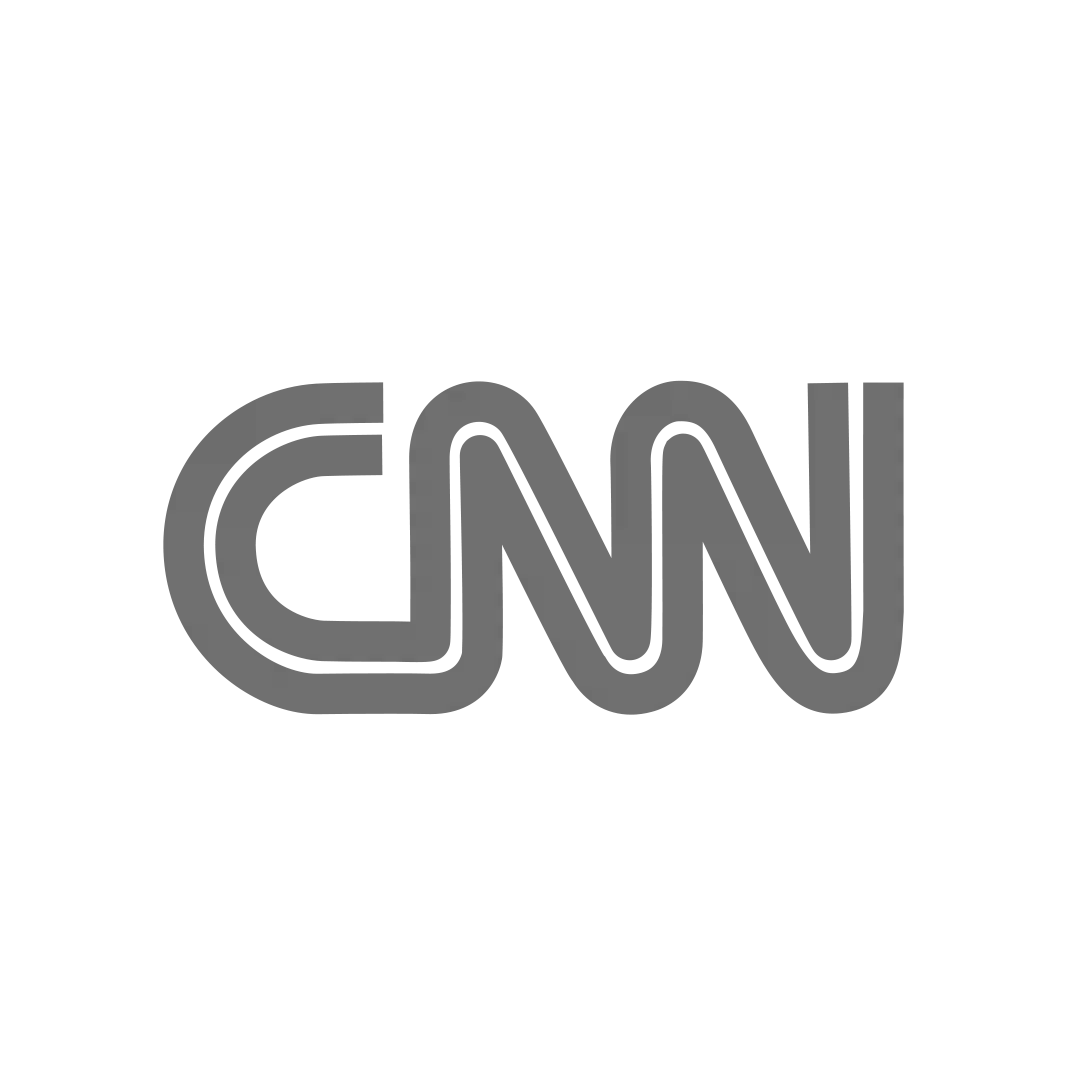
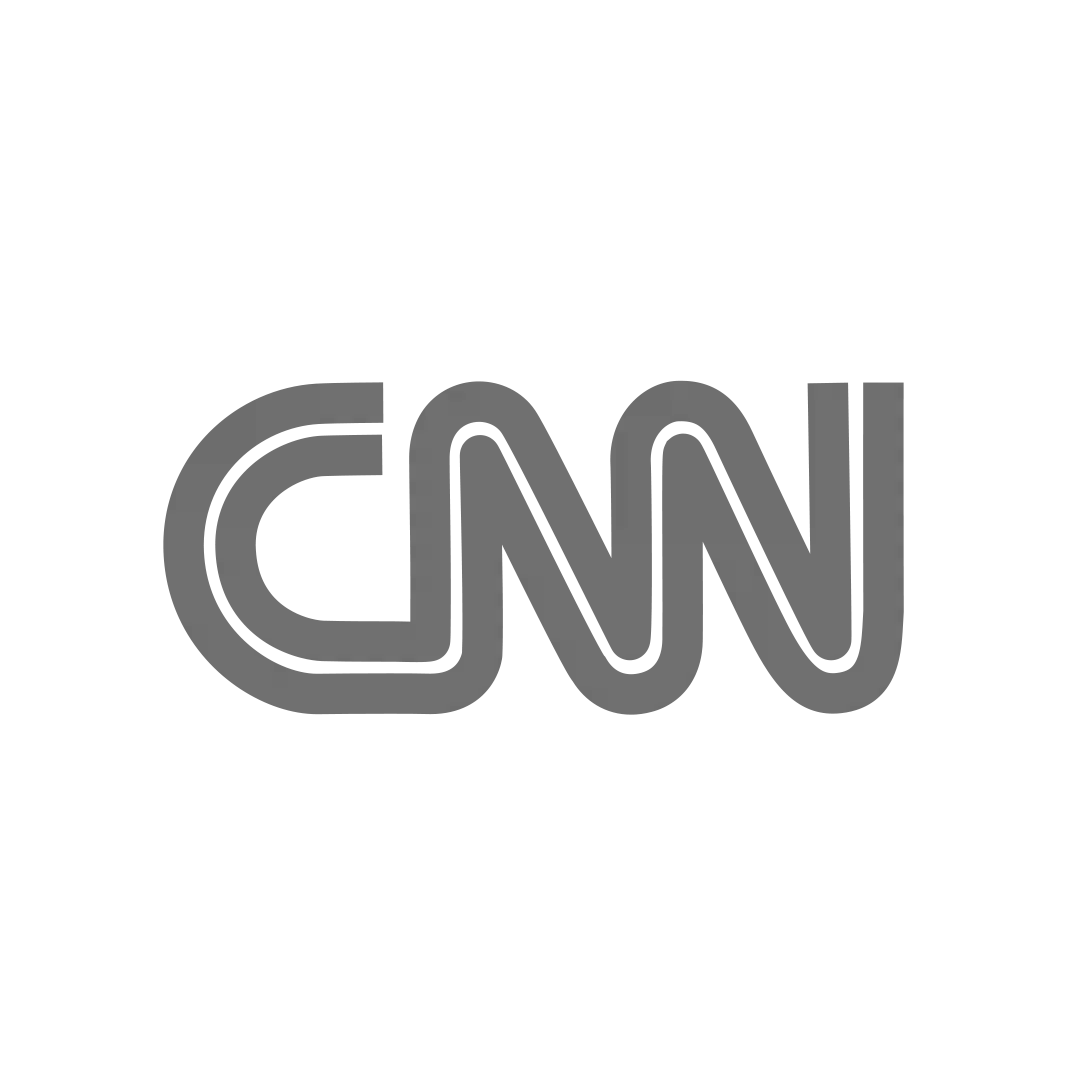
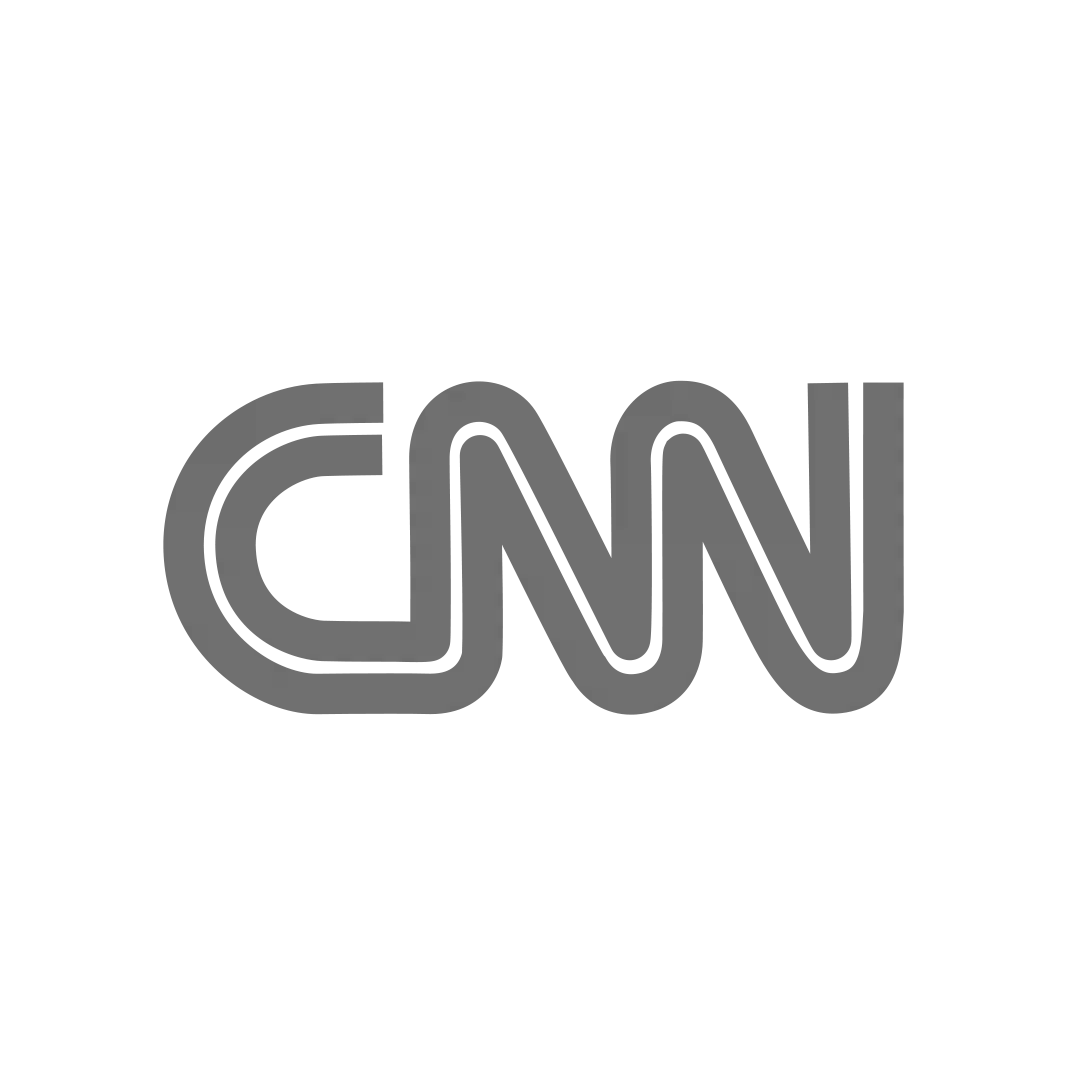
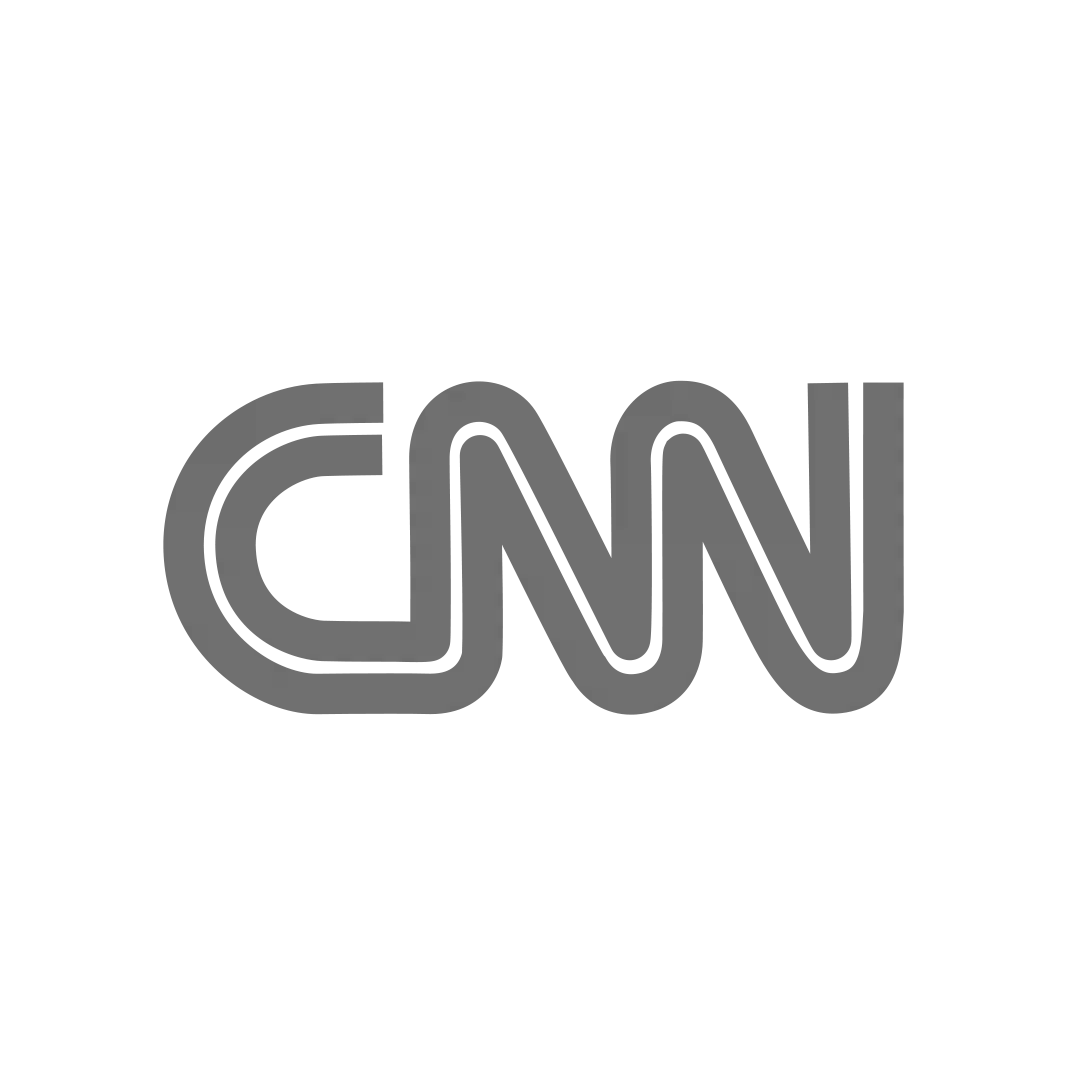
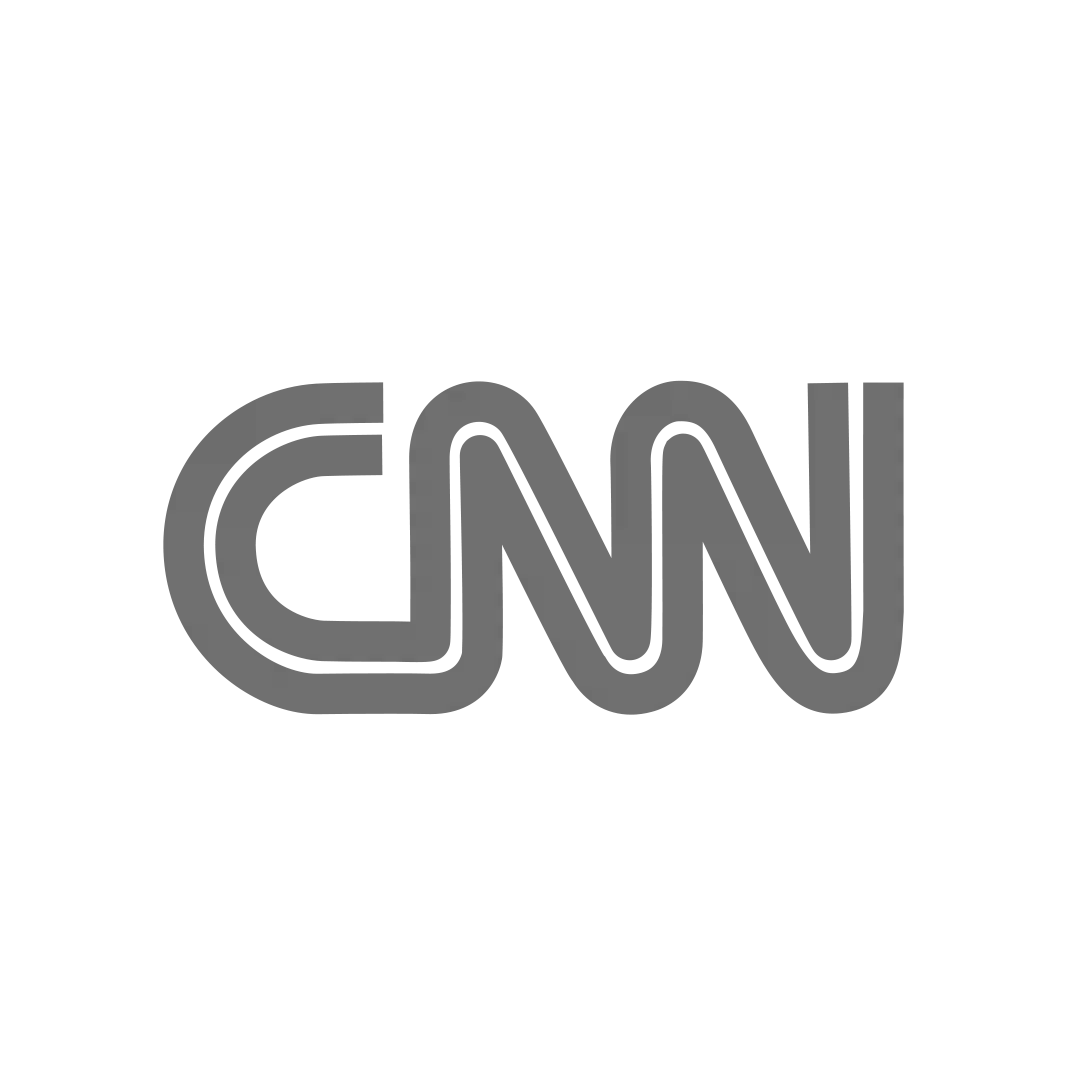
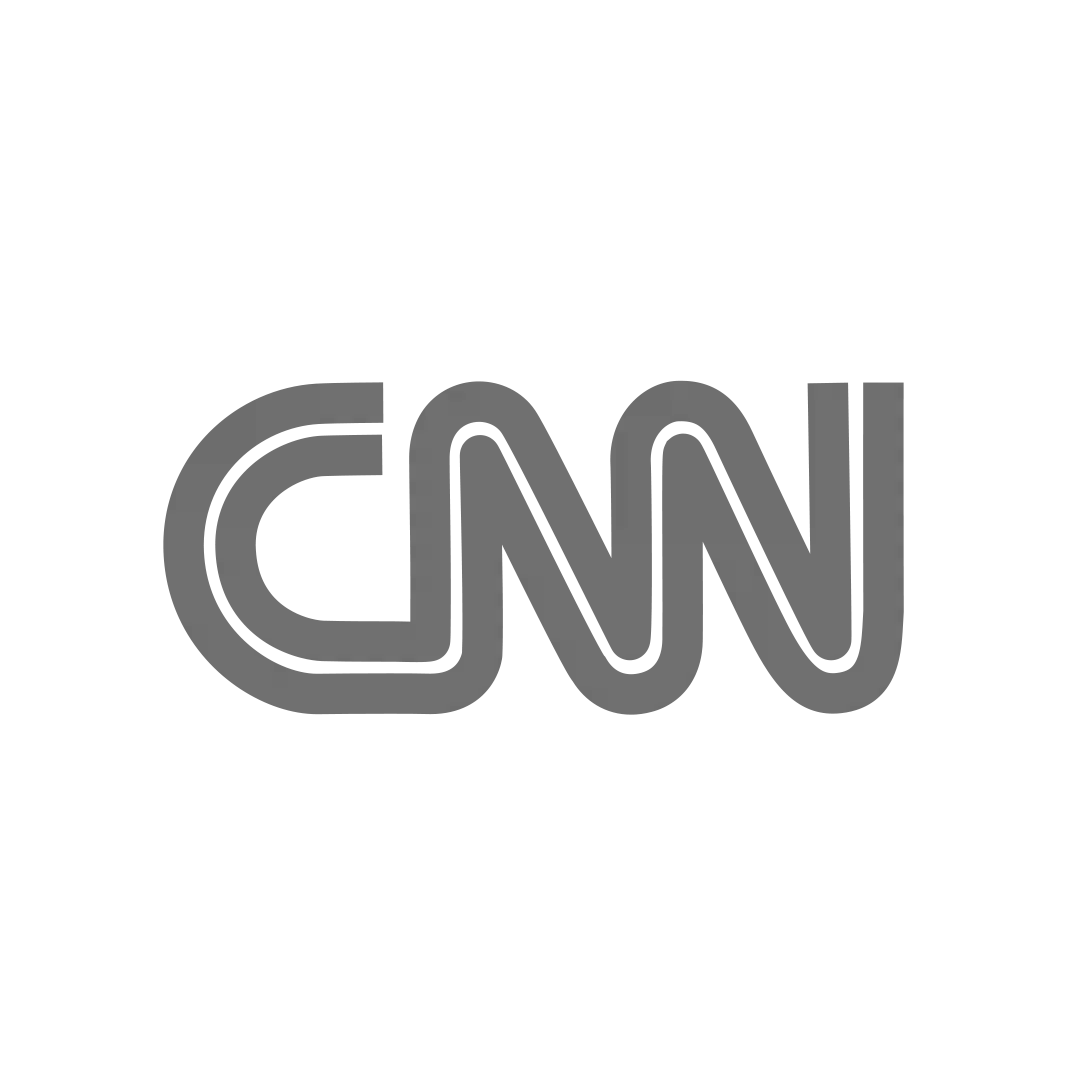
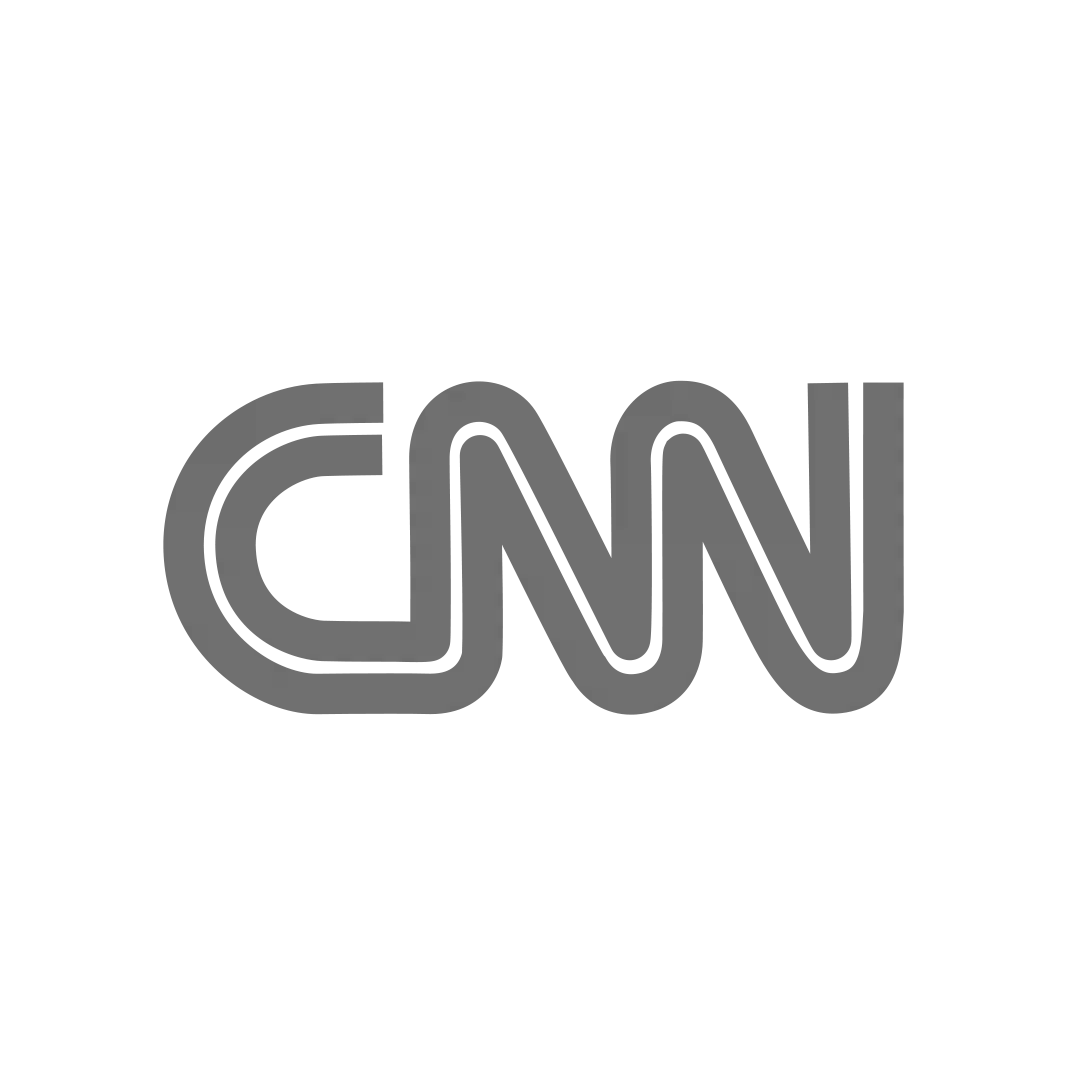
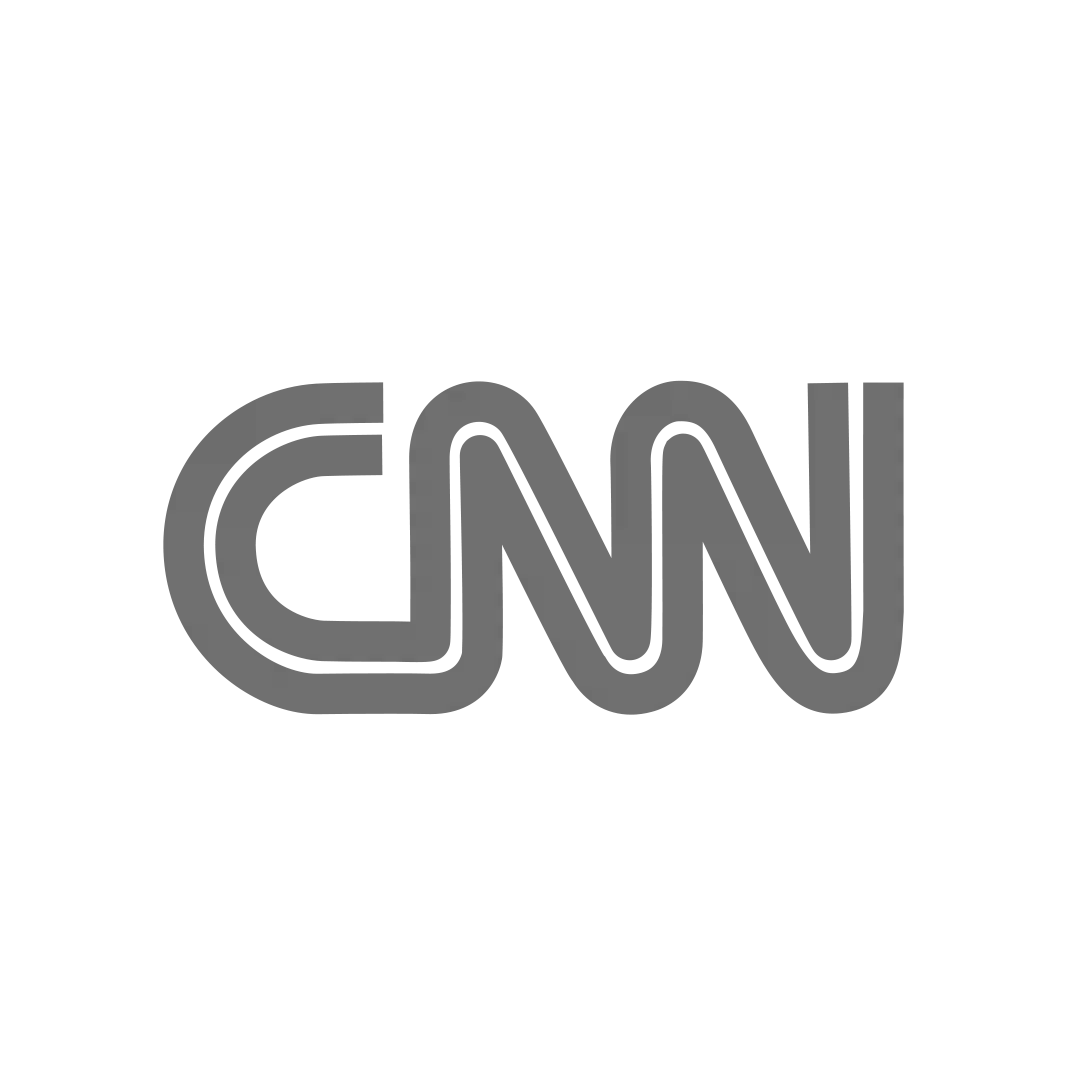
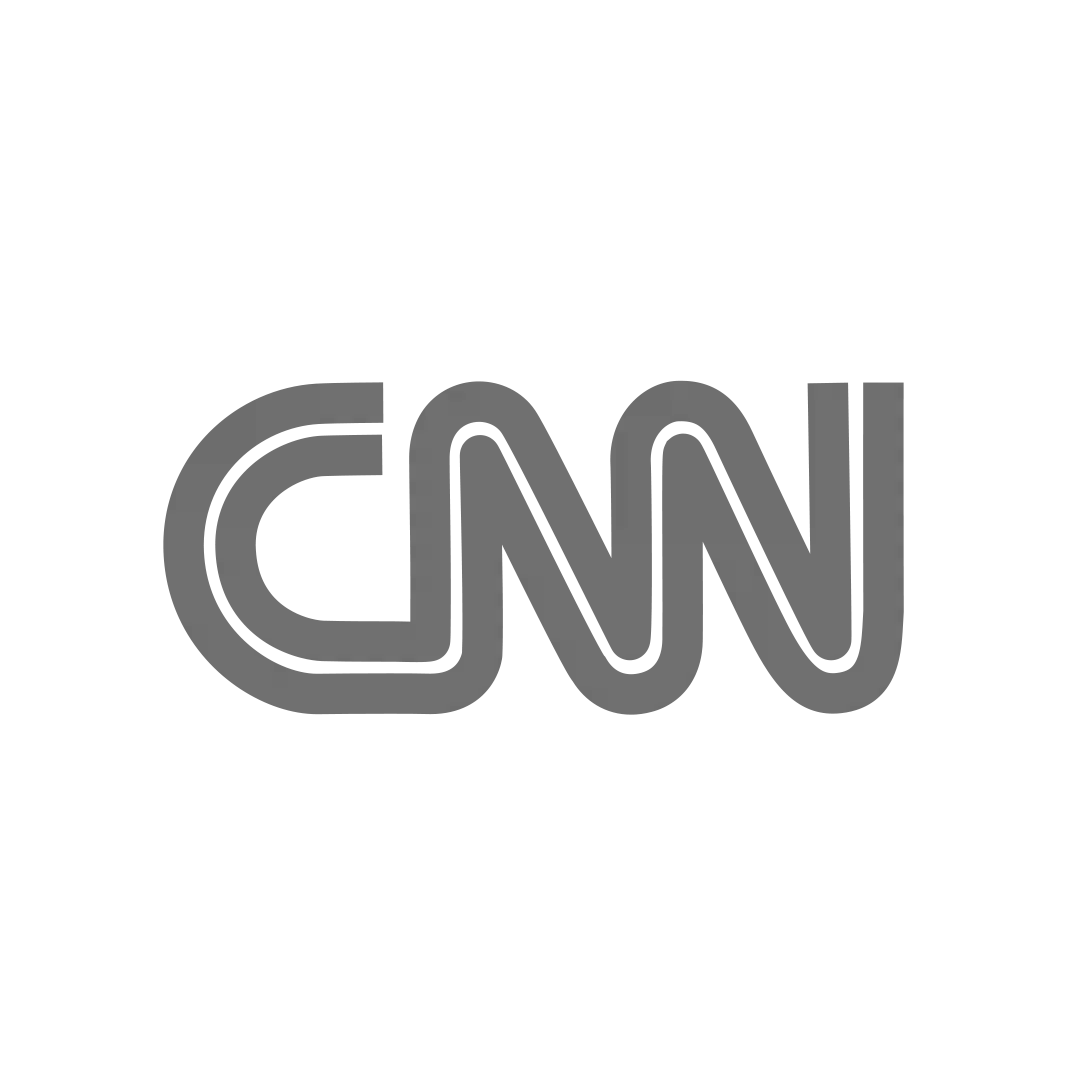
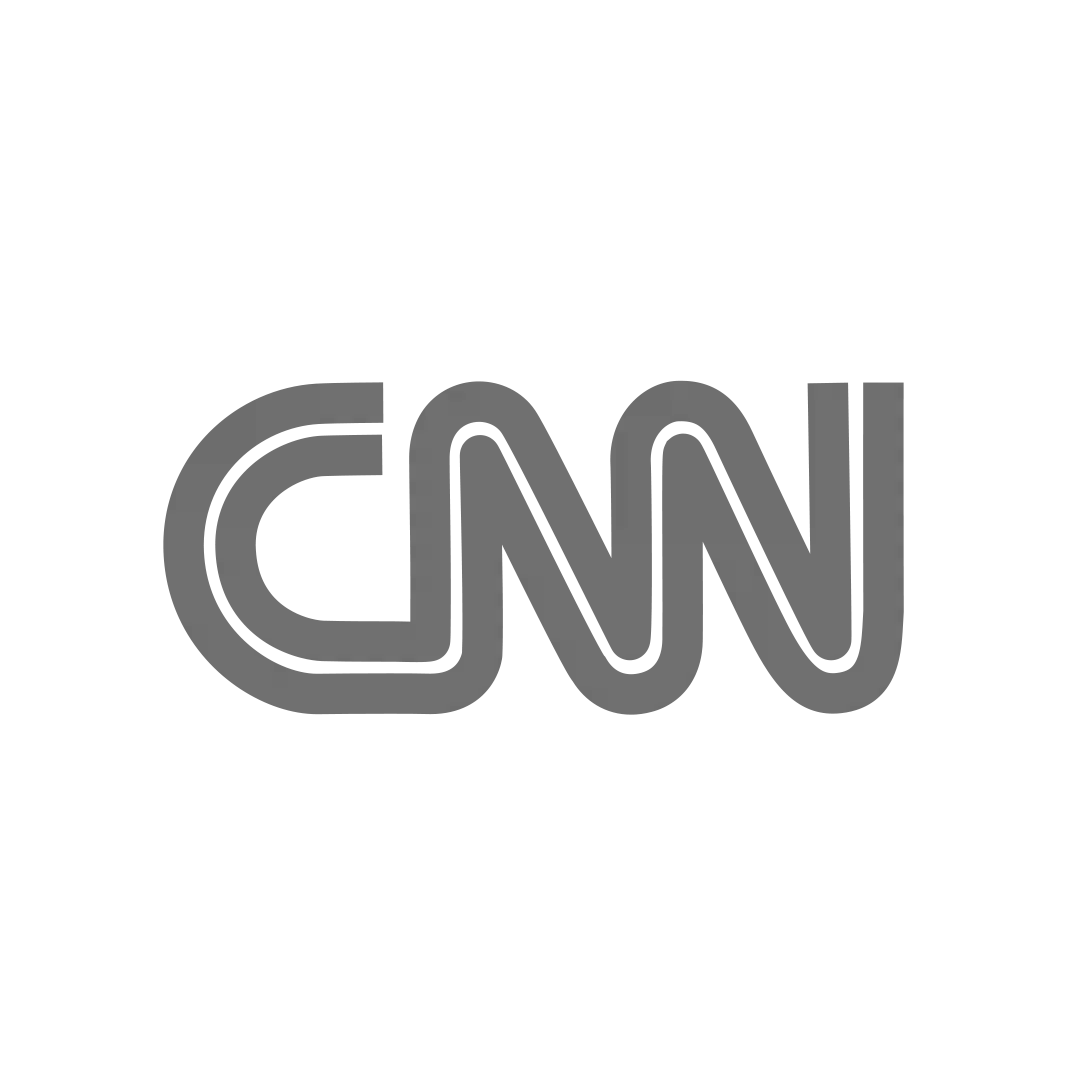
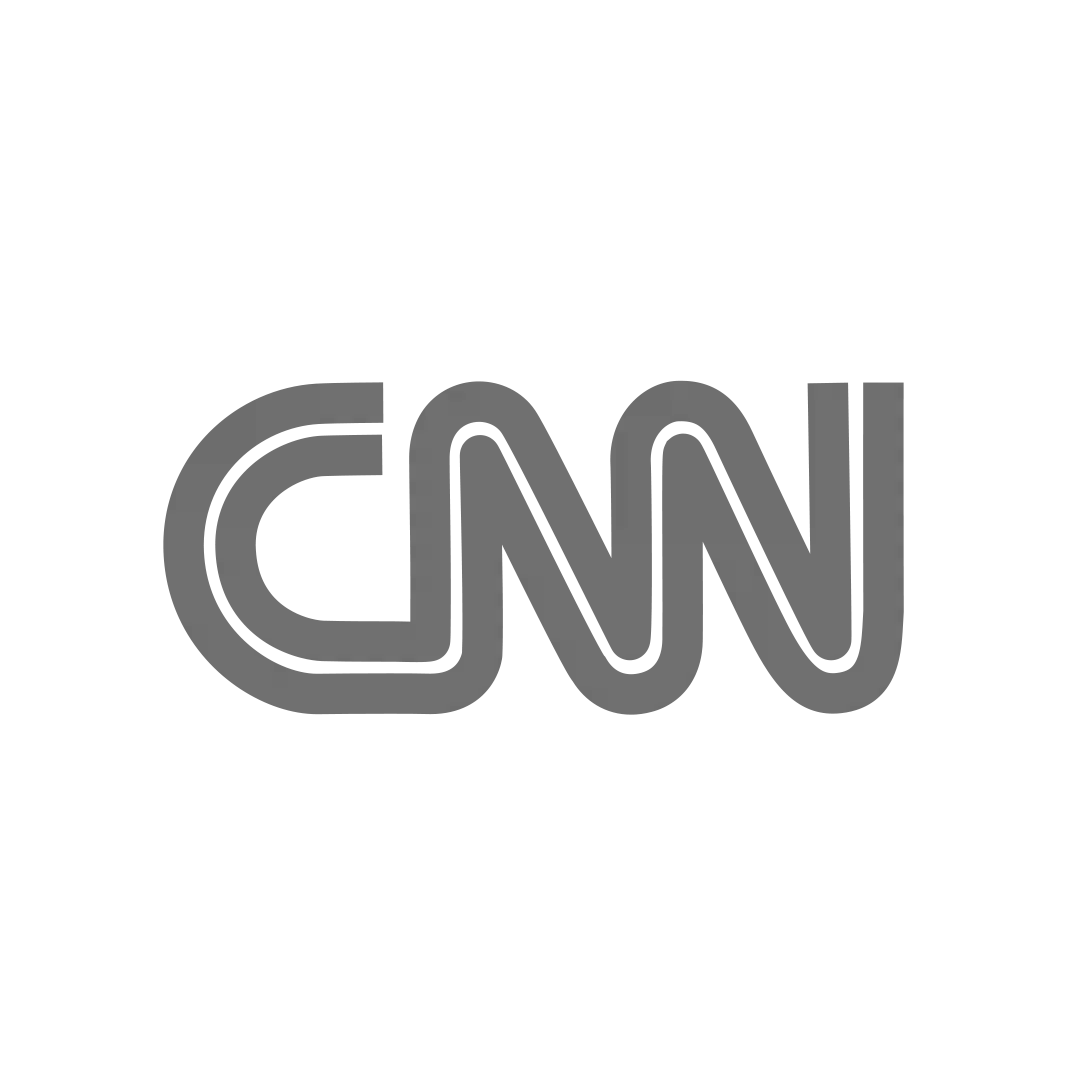
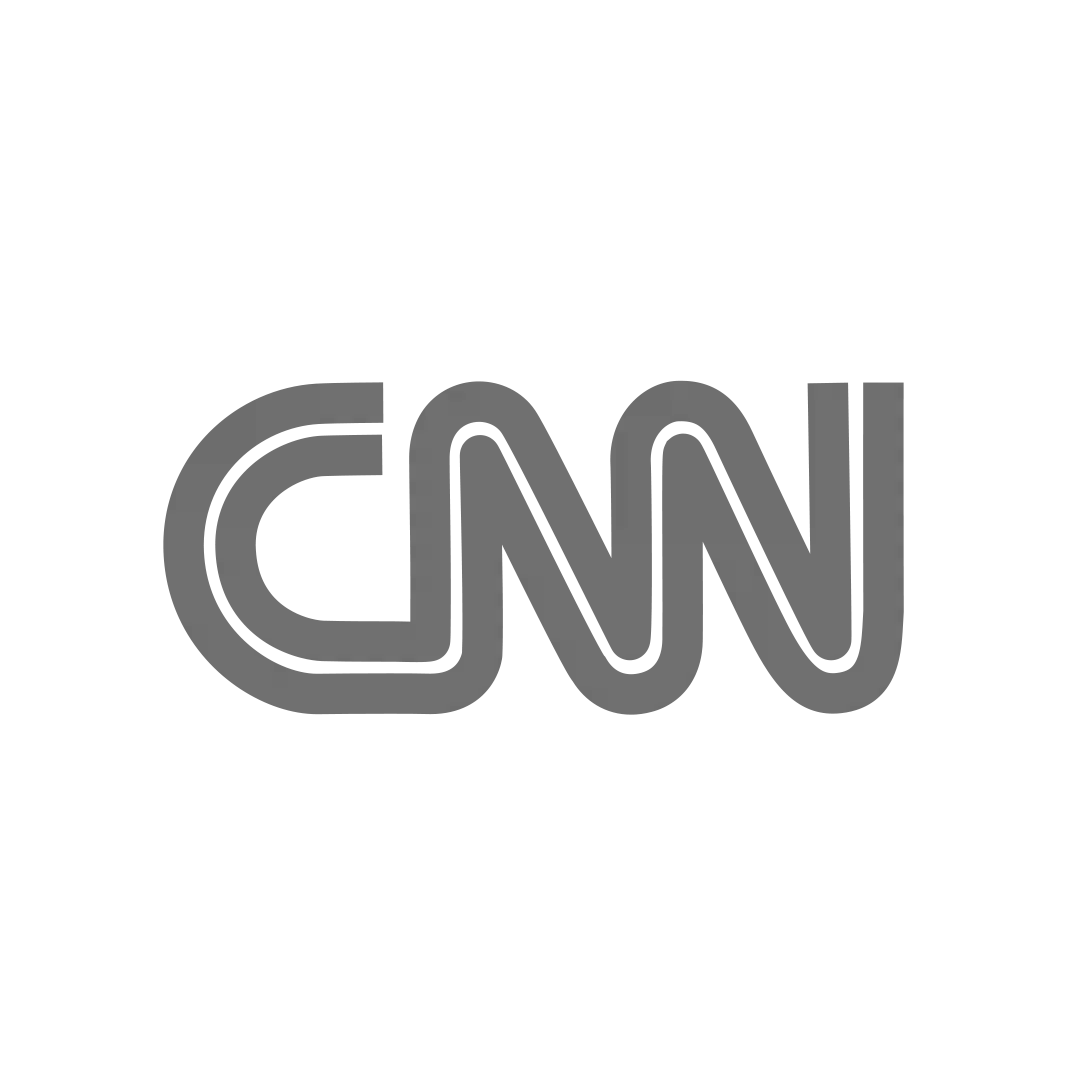
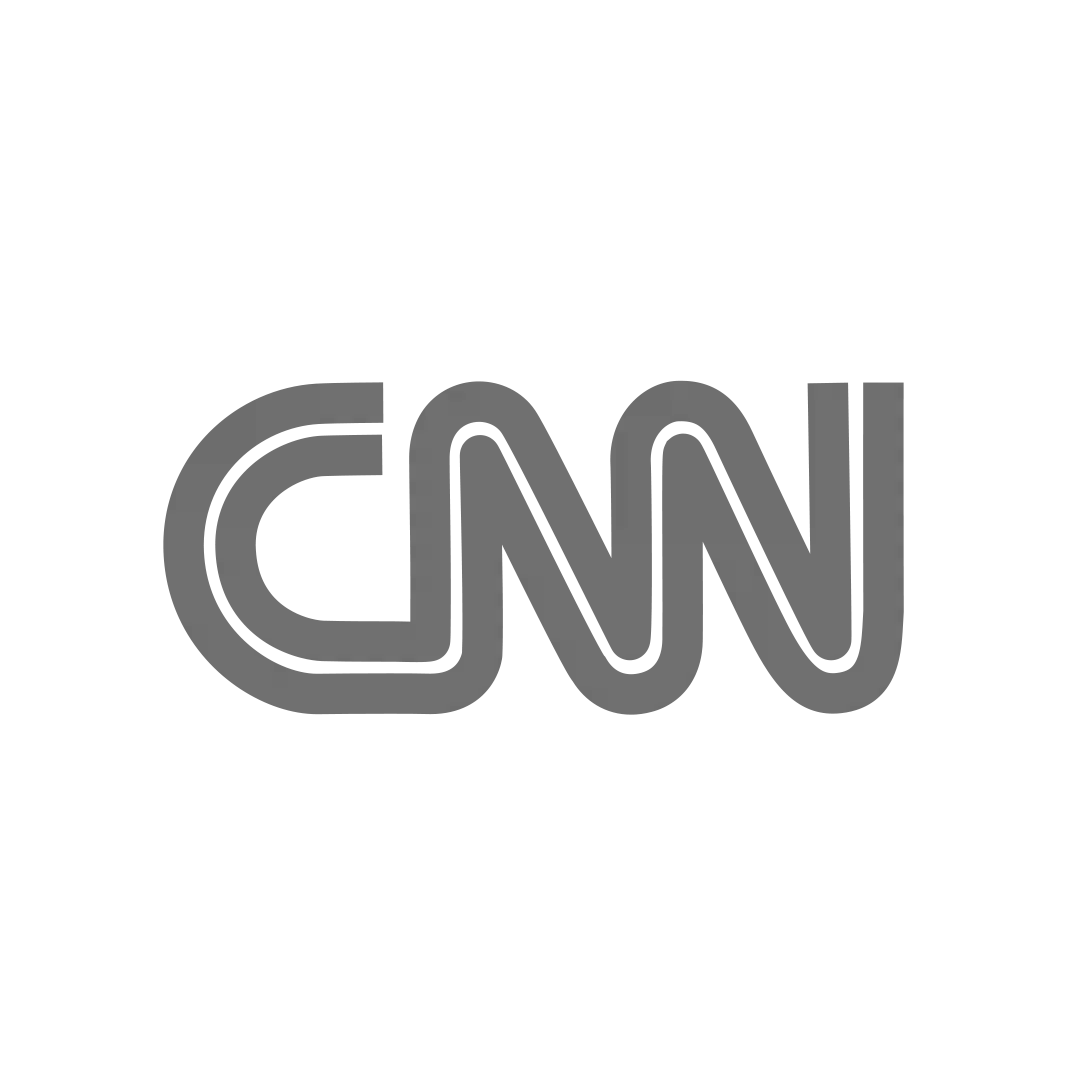
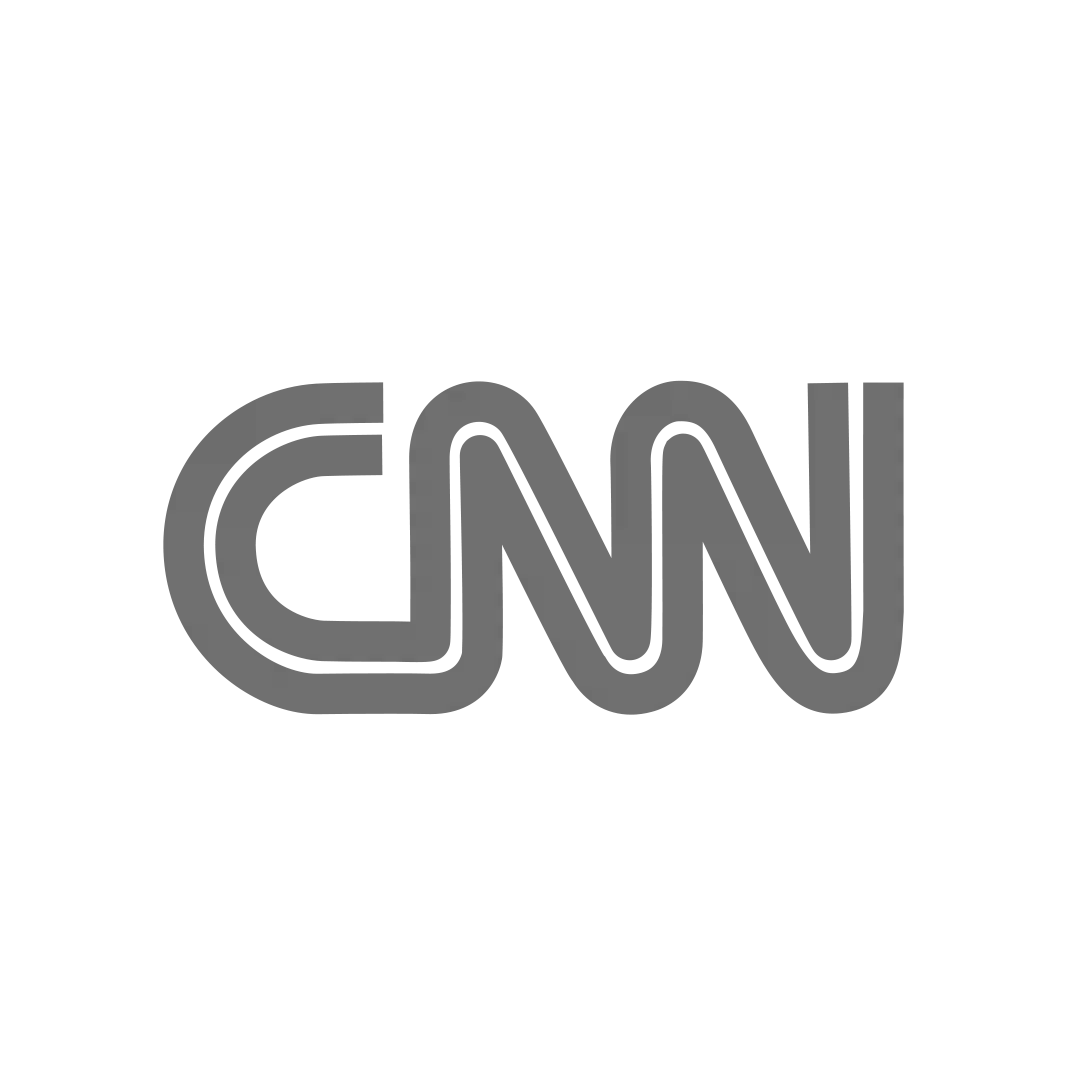
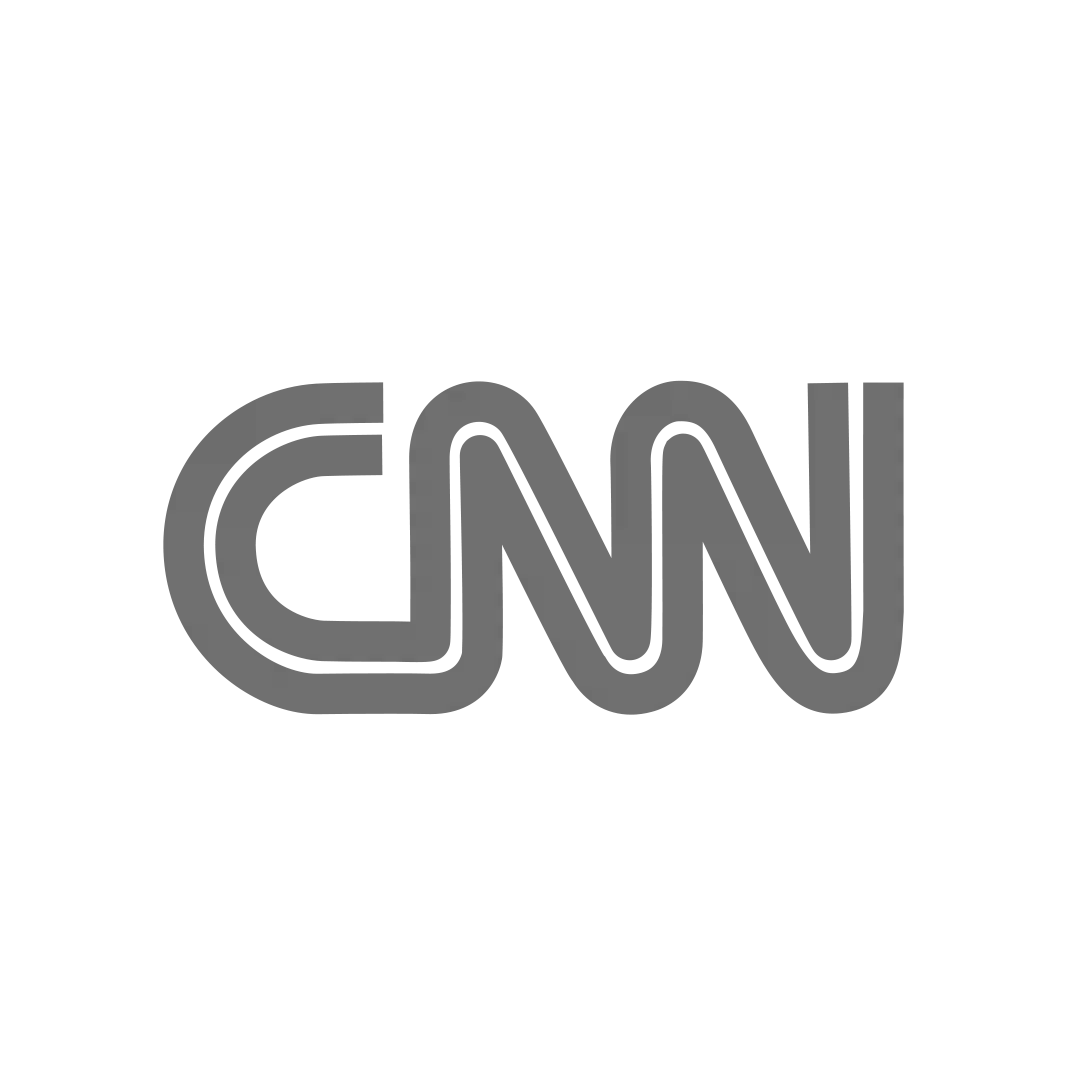
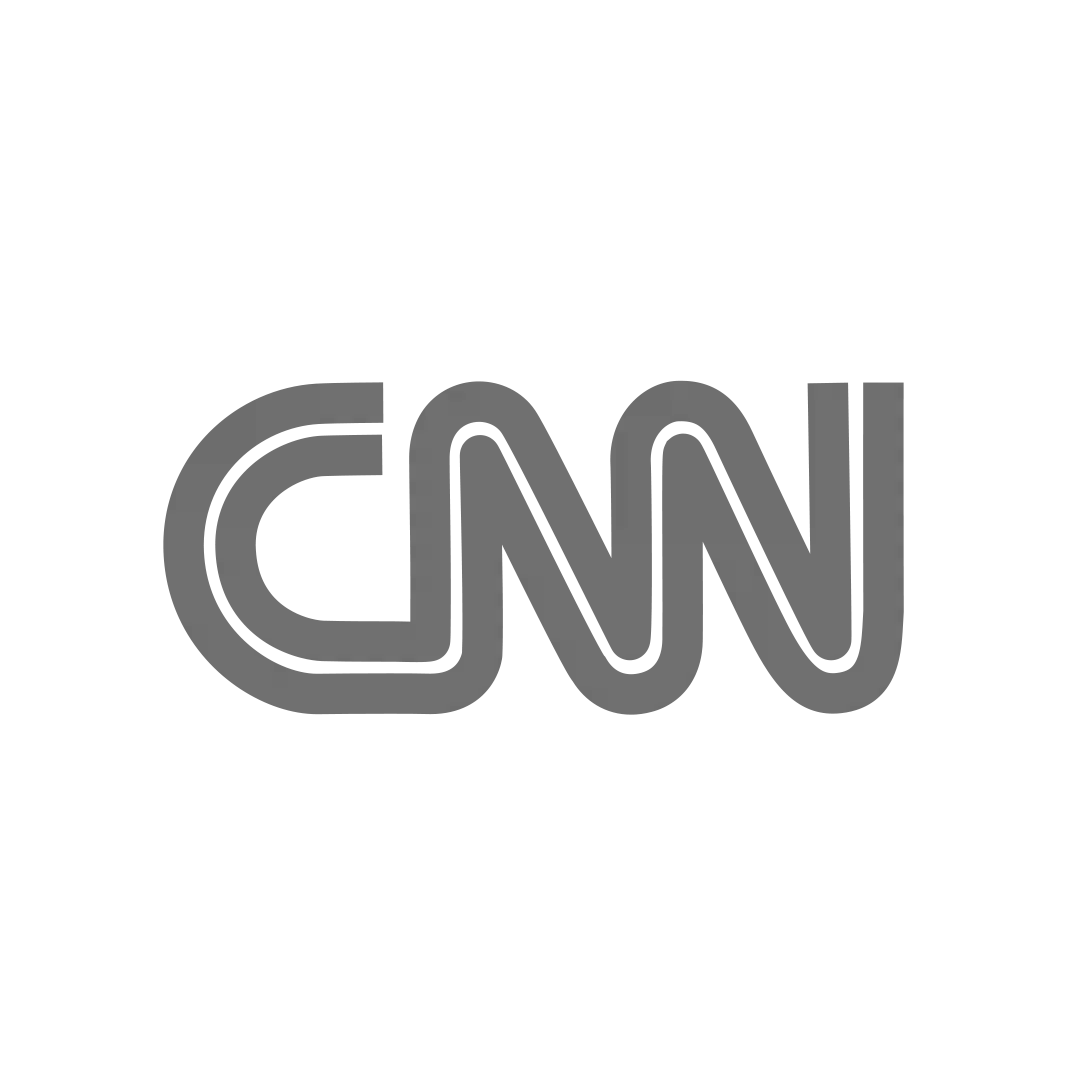
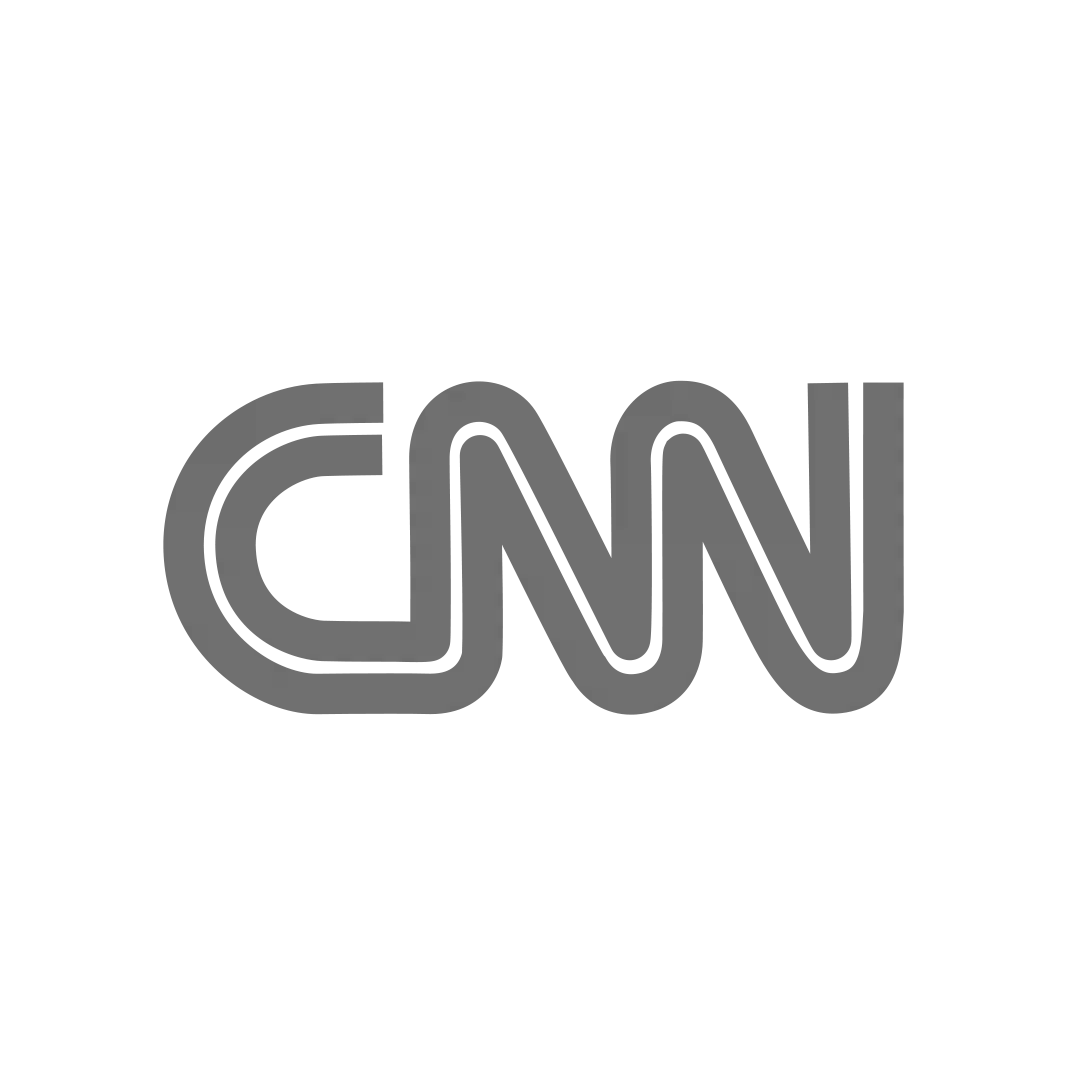
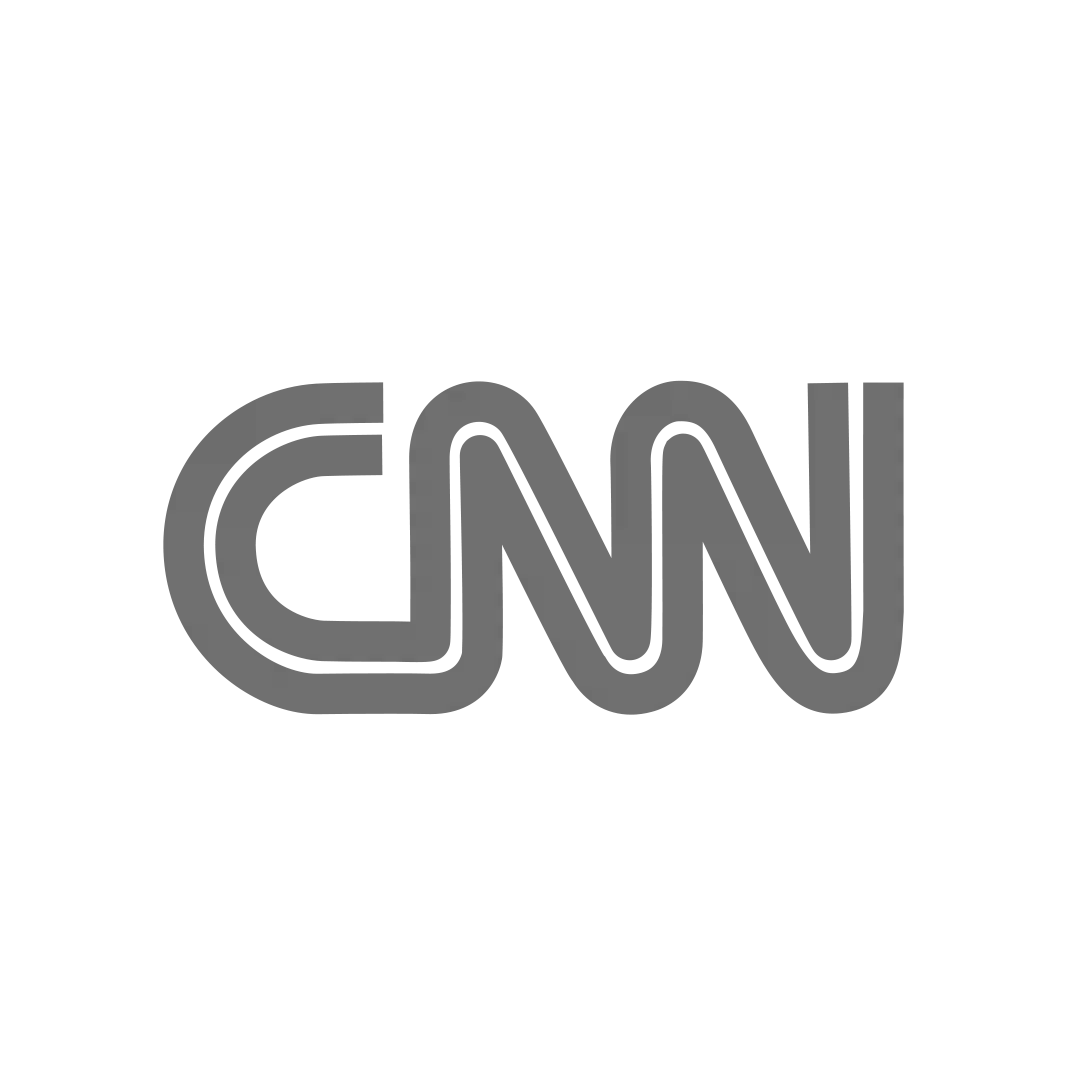
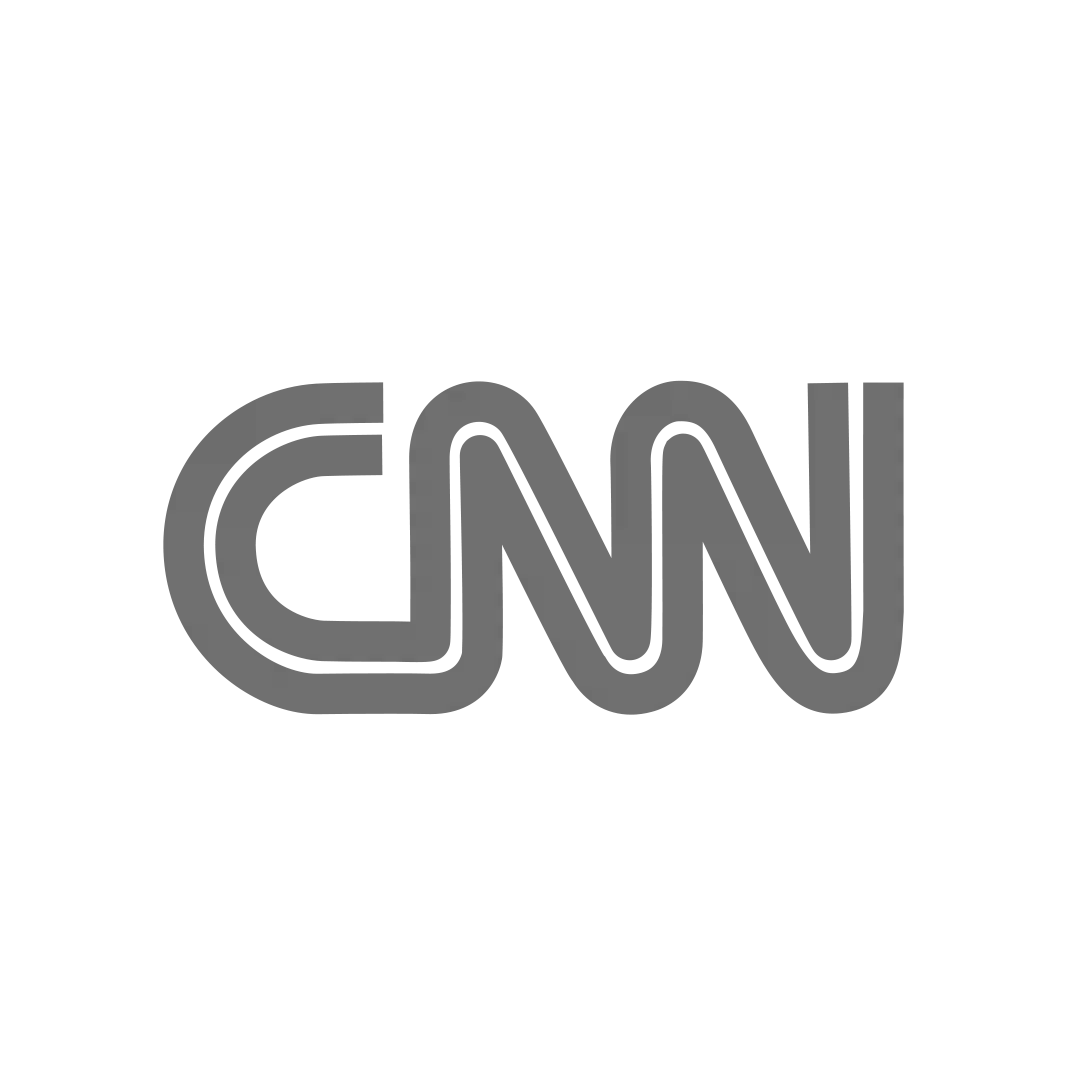

In [158]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'
}
#url = "https://www.tipranks.com/news/blurbs/buy-rating-on-apple-affirmed-by-analyst-erik-woodring-amid-strong-google-deal-and-app-store-resilience?utm_source=edition.cnn.com&utm_medium=referral"
url = "https://edition.cnn.com/markets/stocks/AAPL#news"
request = requests.get(url, headers=headers)
soup = BeautifulSoup(request.text, 'html.parser')
print(soup.prettify())

In [102]:
news_items = []
news_container = soup.find('div', class_='markets-company-news__items')
if news_container:
    news_links = news_container.find_all('a', class_='markets-company-news__item')

    for link in news_links:
        day = link.find('span', class_='markets-company-news__item--day').text.strip() if link.find('span',class_='markets-company-news__item--day') else 'No day'
        time = link.find('span', class_='markets-company-news__item--time').text.strip() if link.find('span', class_='markets-company-news__item--time') else 'No time'
        title = link.find('span', class_='markets-company-news__item--title').text.strip() if link.find('span',class_='markets-company-news__item--title') else 'No title'
        url = link['href'] if 'href' in link.attrs else 'No URL'

        news_items.append({
            'day': day,
            'time': time,
            'title': title,
            'url': url
        })

news_df = pd.DataFrame(news_items)

In [114]:
#scraping info from the actual news article 
request_article = requests.get(news_df['url'][0], headers=headers)
soup_article = BeautifulSoup(request_article.text, 'html.parser')
#print(soup_article.prettify())
json_ld_data = []
script_tag = soup_article.find('script', type='application/ld+json')
if script_tag:
    try:
        json_data = json.loads(script_tag.string)
        json_ld_data.append(json_data)
    except json.JSONDecodeError:
        json_ld_data.append(None)
else:
    json_ld_data.append(None)

In [136]:
json_df = pd.json_normalize(json_ld_data)
json_df.columns = json_df.columns.str.replace(r'\.', '_')

for column in json_df.columns:
   news_df.at[0, column] = json_df.at[0, column]

In [137]:
print(news_df)

          day        time                                              title  \
0       Today   3:30pm ET  Microsoft (NASDAQ:MSFT) Suffers Talent Loss Wi...   
1       Today   2:35pm ET  Buy Rating on Apple Affirmed by Analyst Erik W...   
2       Today  12:30pm ET  Comcast (NASDAQ:CMCSA) Notches Up on New Video...   
3       Today  10:04am ET  Bumble (NASDAQ:BMBL) Stumbles Amid Anti-Celiba...   
4       Today   9:01am ET  Analysts Are Bullish on Top Technology Stocks:...   
5       Today   2:35am ET              Apple (AAPL) Gets a Hold from KeyBanc   
6   Yesterday   2:58pm ET  Meta Platforms (NASDAQ: META) Betting on New Tech   
7   Yesterday   2:30pm ET  Apple (NASDAQ:AAPL) Moving Vision Pro to Forei...   
8   Yesterday   6:07am ET  Apple says no major app developers use outside...   
9   Yesterday   5:58am ET  Apple looks at new compensation regime for Hol...   
10  Yesterday   3:50am ET  Analysts Conflicted on These Technology Names:...   
11     May 12   5:55pm ET  Box Office Ba

In [164]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Referer': 'https://www.google.com/',
    'Connection': 'keep-alive',
    'DNT': '1',
    'Upgrade-Insecure-Requests': '1',
    'TE': 'Trailers'
}

proxy = {
    'http': 'http://201.182.251.142:999',
    'https': 'http://201.182.251.142:999'
}

request_article_all = requests.get(news_df['url'][2], headers=headers, proxies=proxy)
soup_article = BeautifulSoup(request_article.text, 'html.parser')
print(request_article_all.text) #Max retries exceeded i'll try later 

ProxyError: HTTPSConnectionPool(host='www.tipranks.com', port=443): Max retries exceeded with url: /news/comcast-nasdaqcmcsa-notches-up-on-new-video-bundle-plan?utm_source=edition.cnn.com&utm_medium=referral (Caused by ProxyError('Unable to connect to proxy', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x160c45450>: Failed to establish a new connection: [Errno 61] Connection refused')))

In [ ]:
'''
Next steps:
- get this info from news  - done
- make functions for the scripts, for each stock 
- have a df for all news info, add the specific news outlet 
- calculate sentiment score
'''